In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/root/miniconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [8]:
data = pd.read_csv("from_dgx/TS_datasets/electr_load/LD2011_2014.txt", sep=";", decimal=',')

In [10]:
data['target'] = data[data.columns[1:]].mean(axis=1)

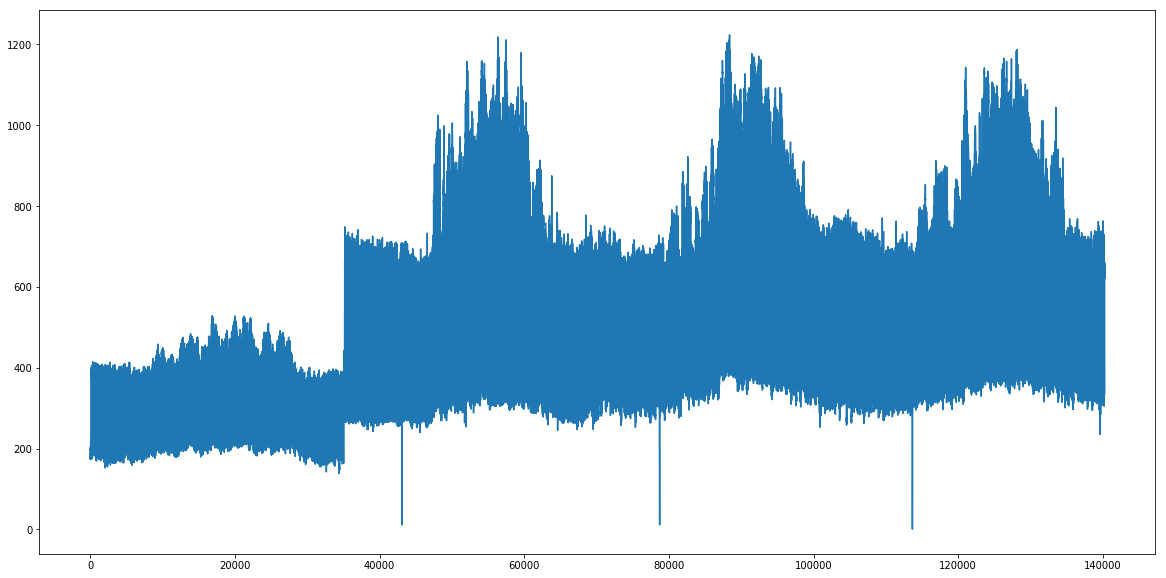

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(data['target'])

In [22]:
from tqdm import tqdm_notebook
from PyEMD import EEMD

In [23]:
eemd = EEMD()

Process ForkPoolWorker-107:
Process ForkPoolWorker-99:
Process ForkPoolWorker-106:
Process ForkPoolWorker-100:
Process ForkPoolWorker-97:
Process ForkPoolWorker-108:
Process ForkPoolWorker-98:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/root/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/root/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/root/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/root/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/root/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/root/miniconda3/lib/python3.6/

In [24]:
imf = eemd(data['target'].values)

In [25]:
imf.shape

(17, 140256)

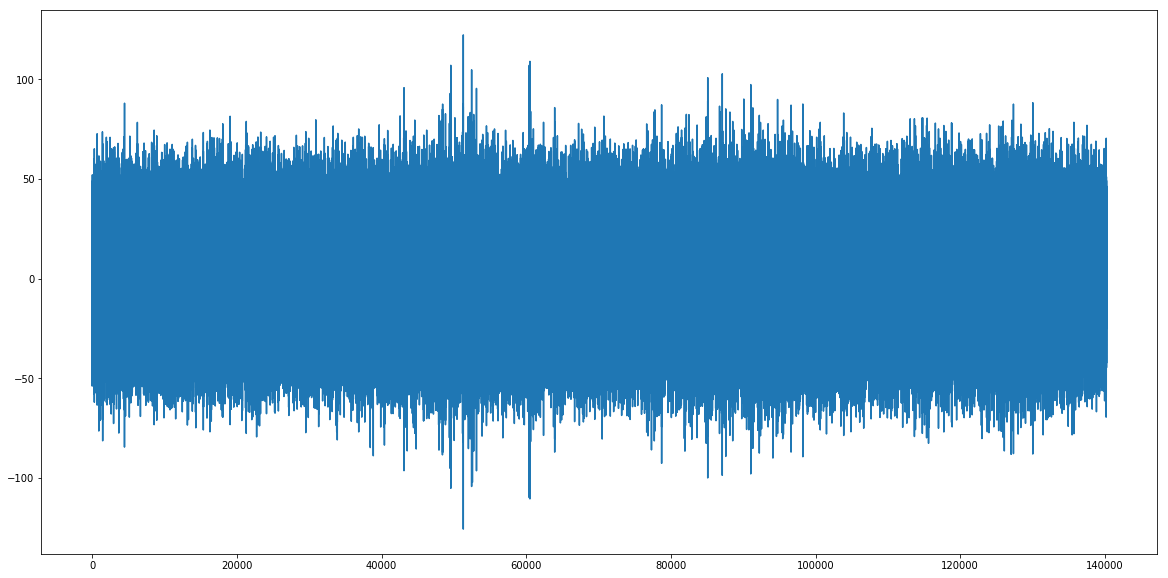

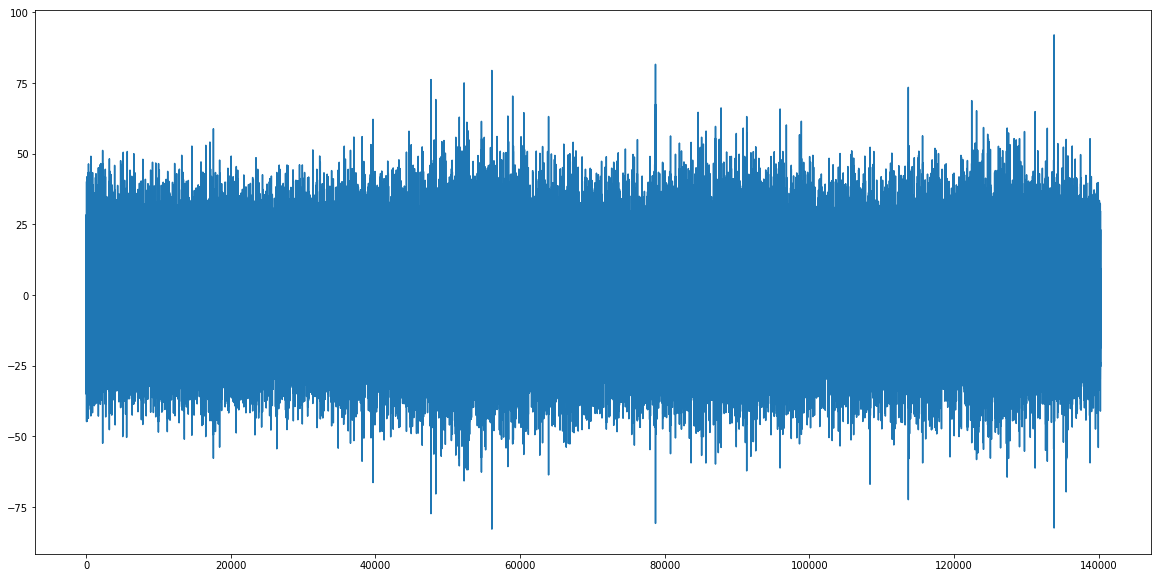

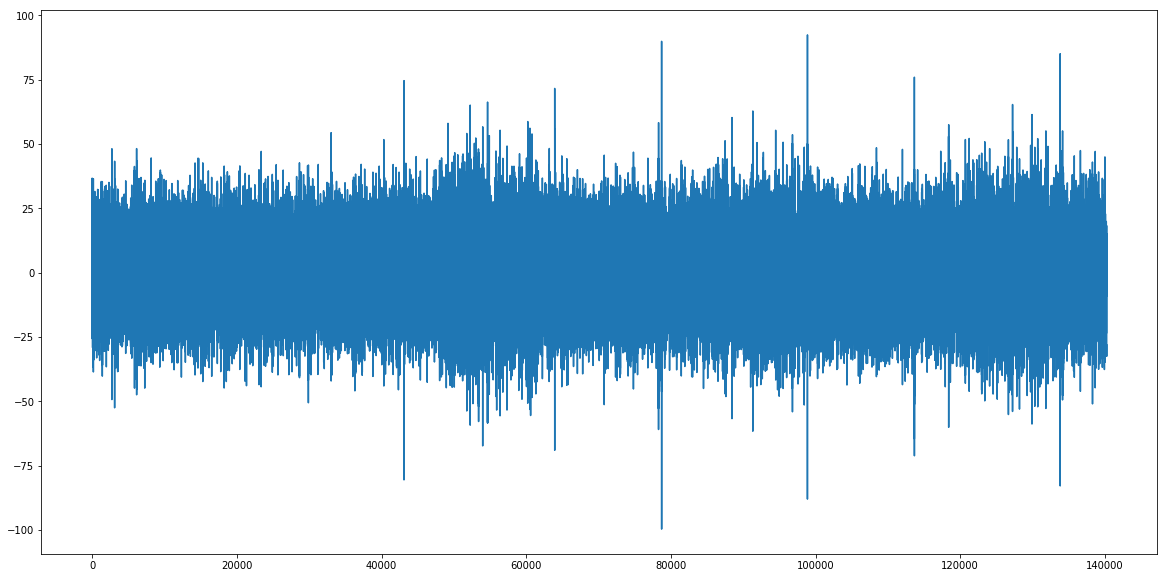

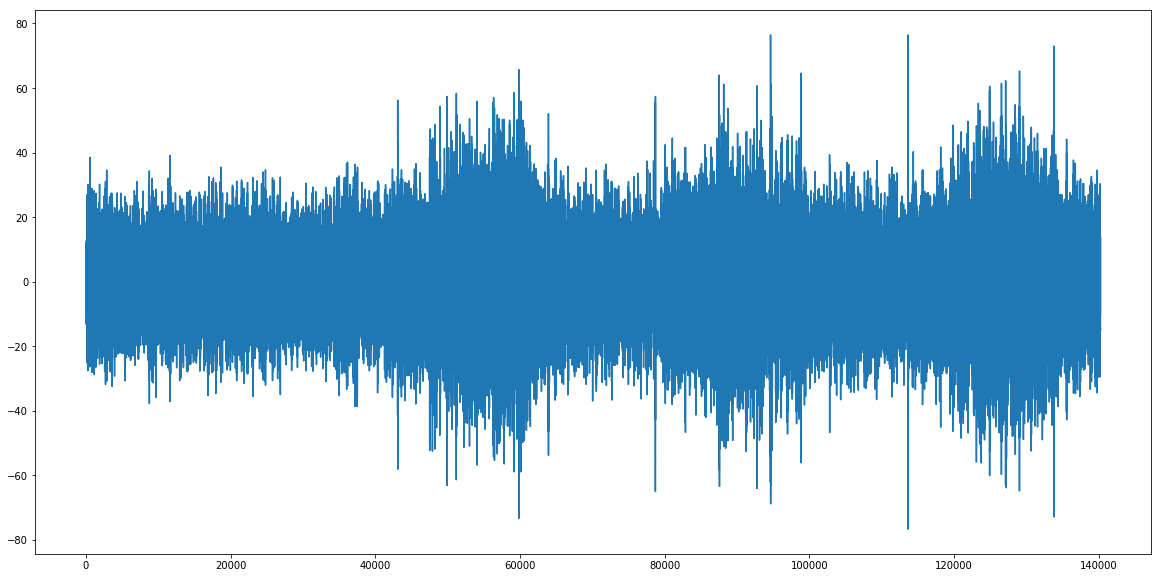

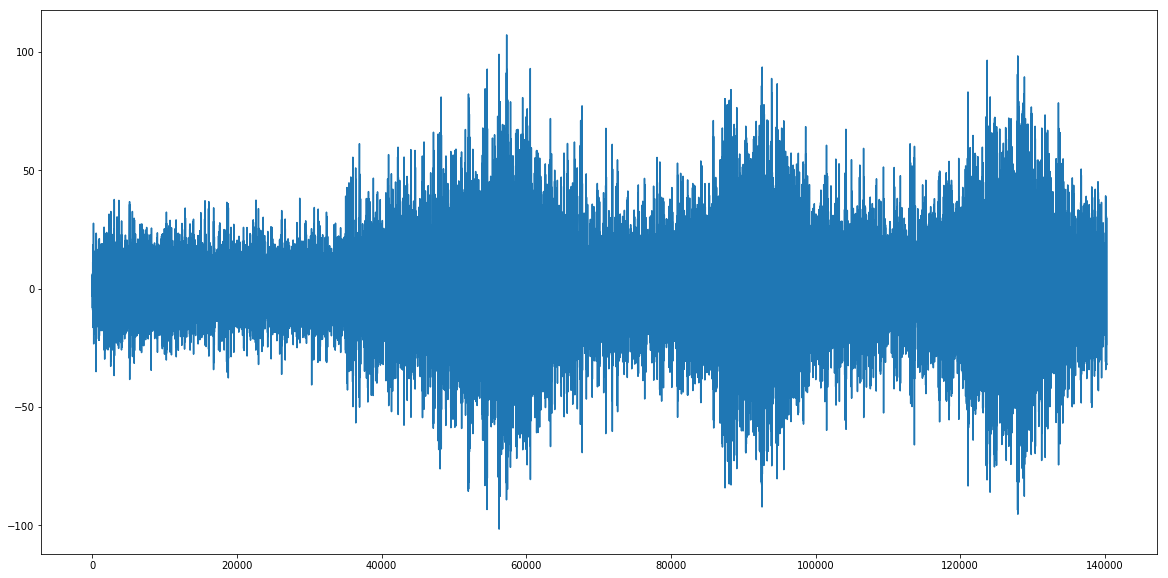

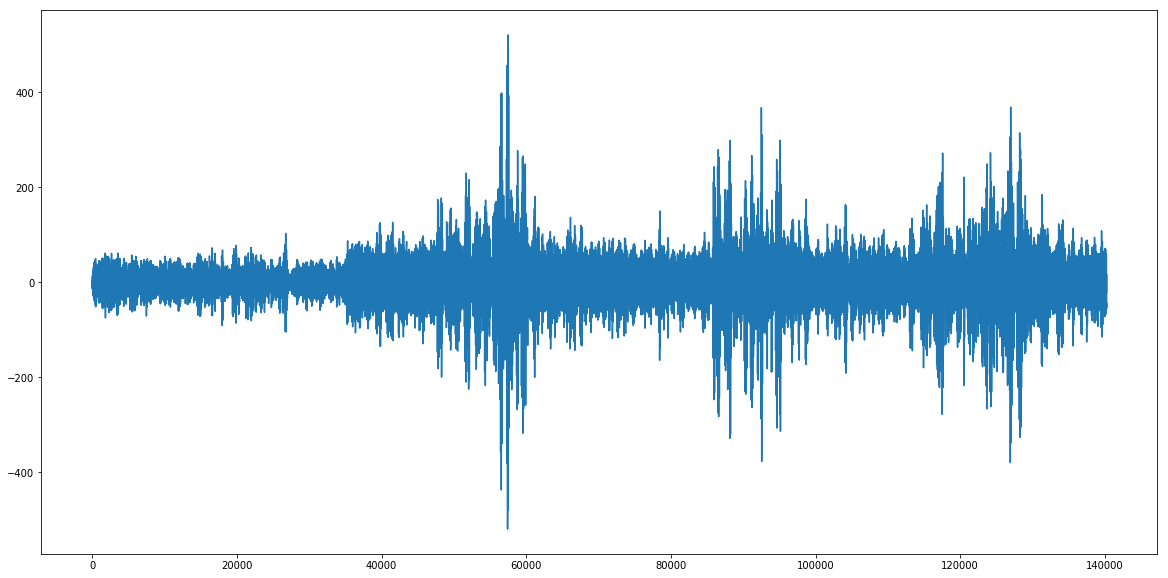

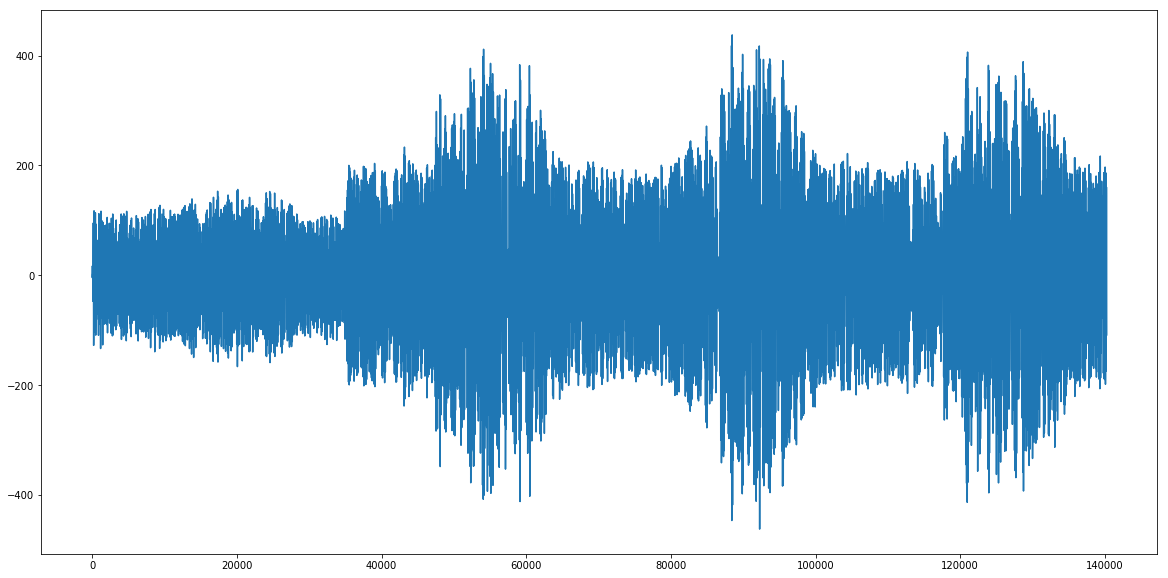

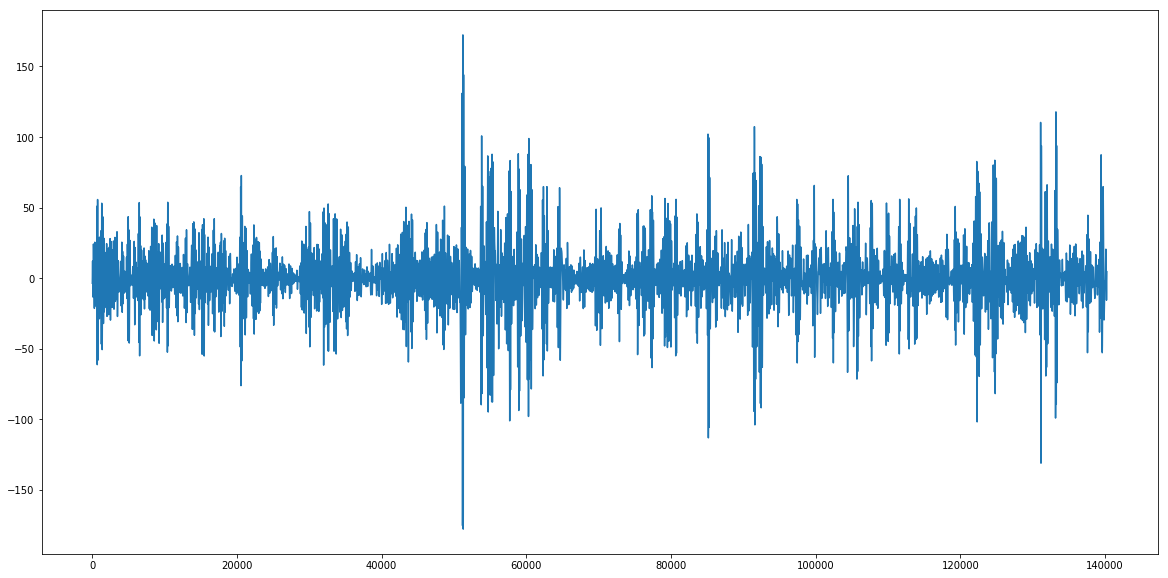

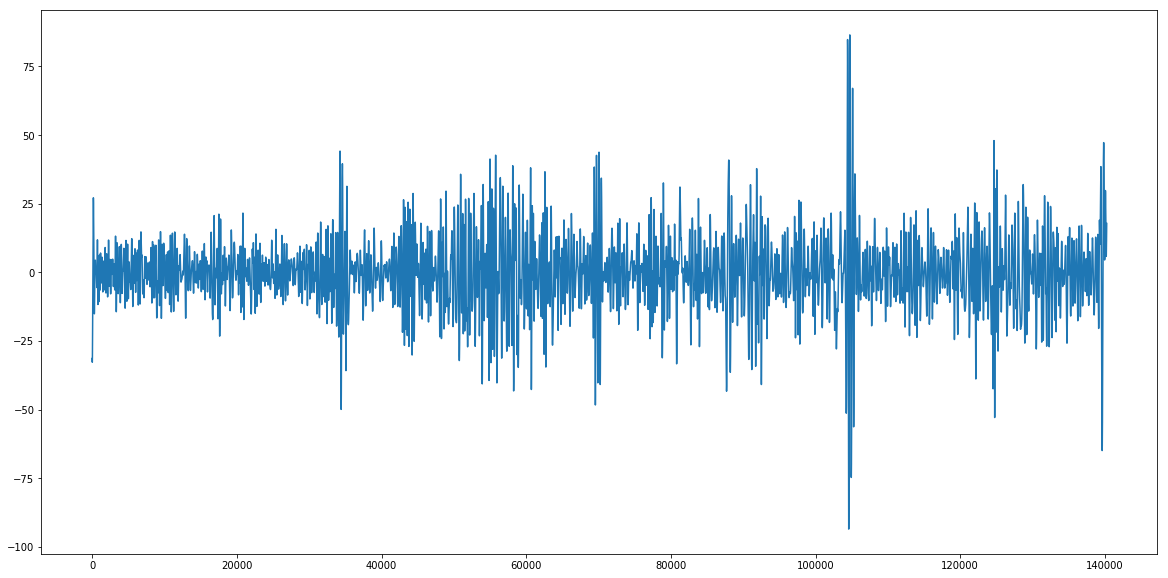

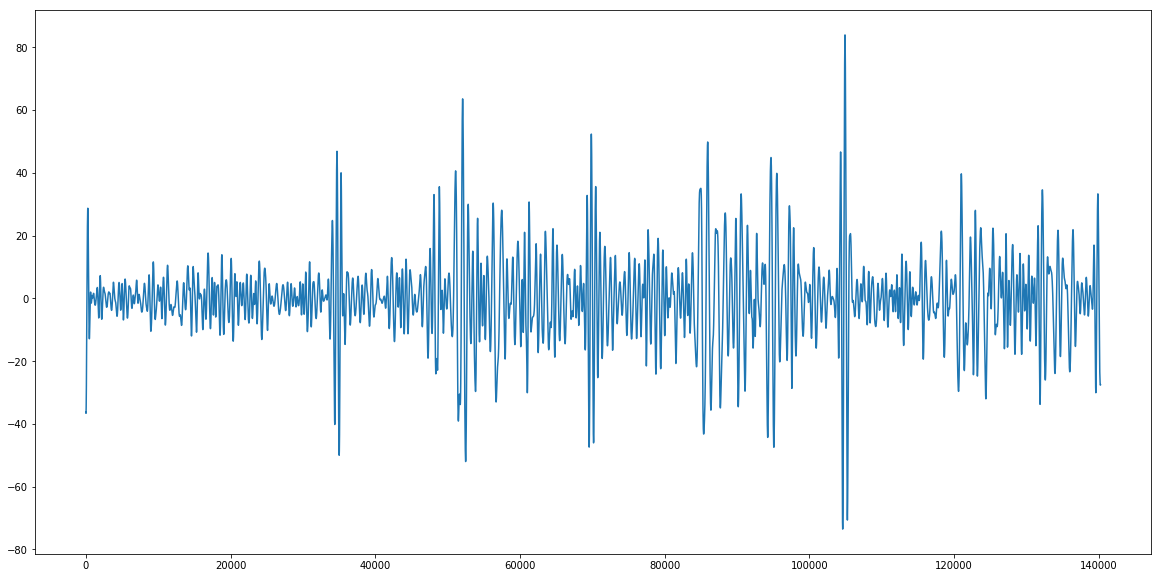

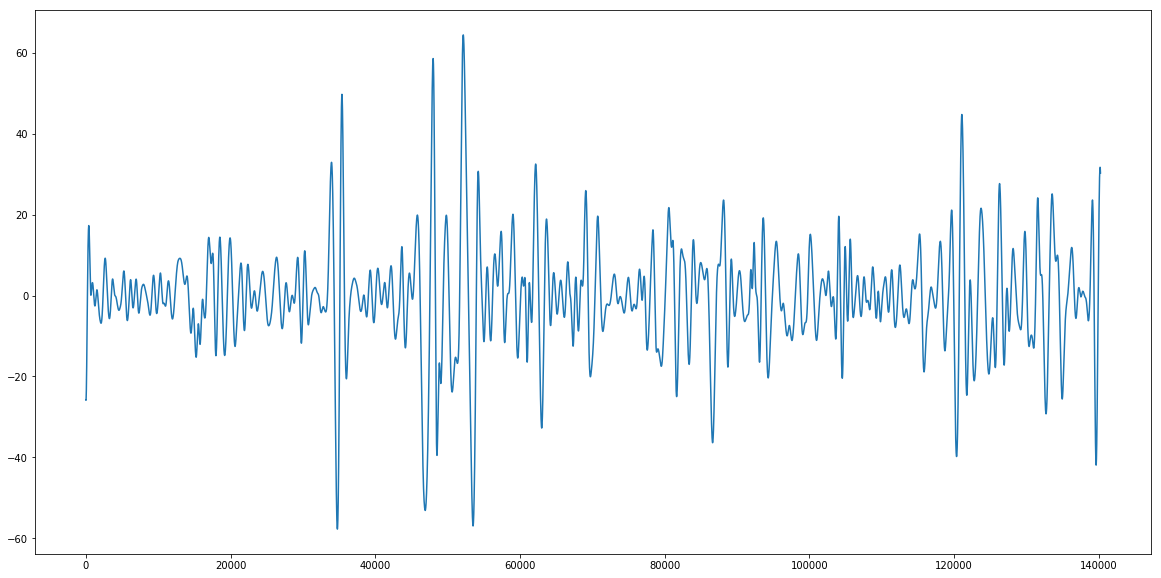

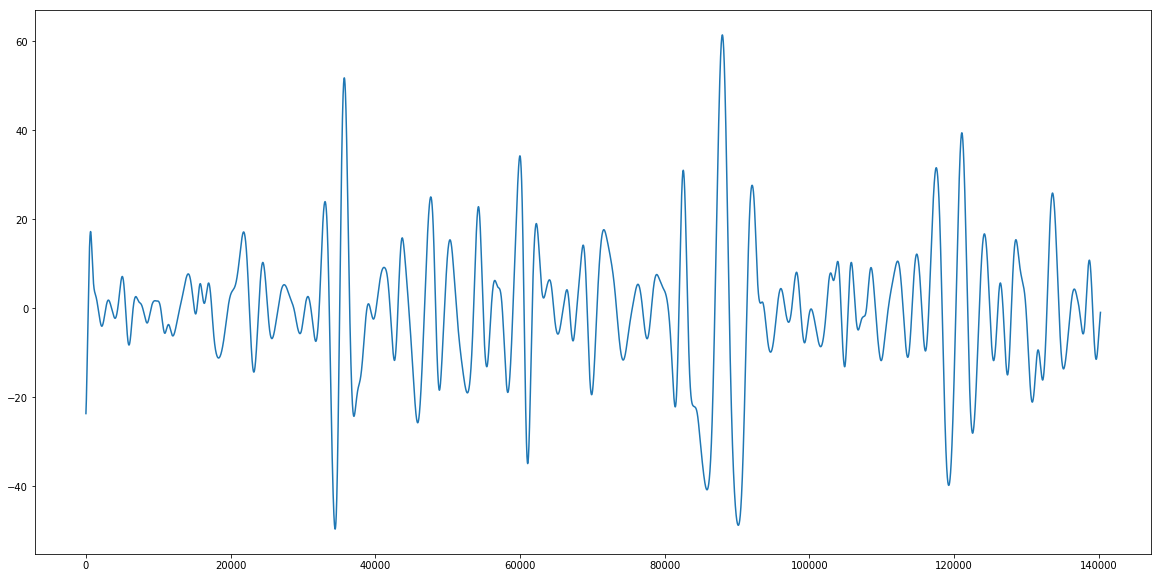

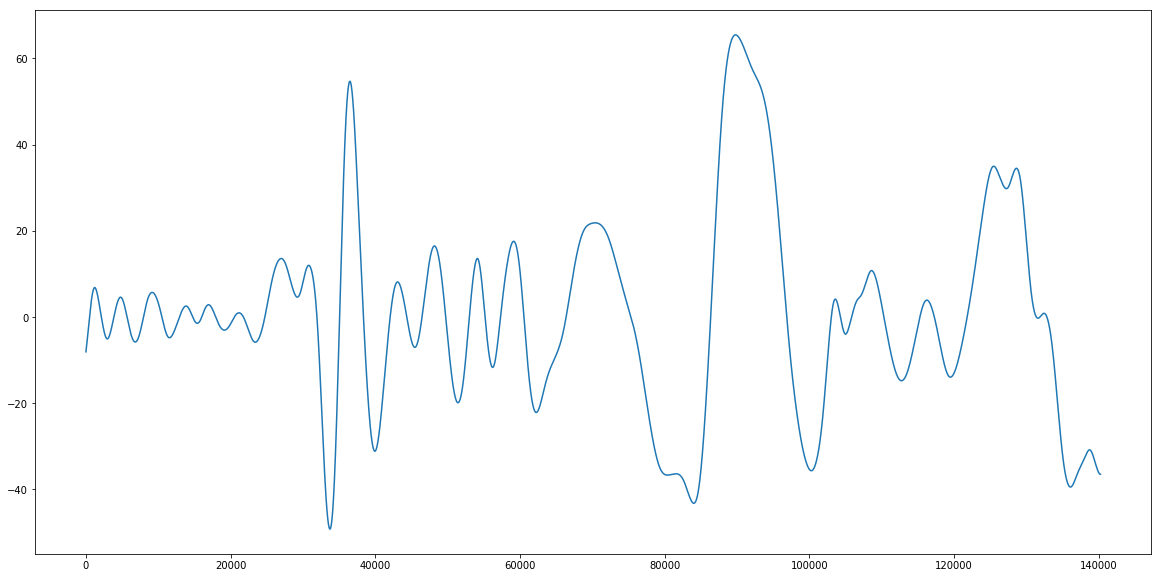

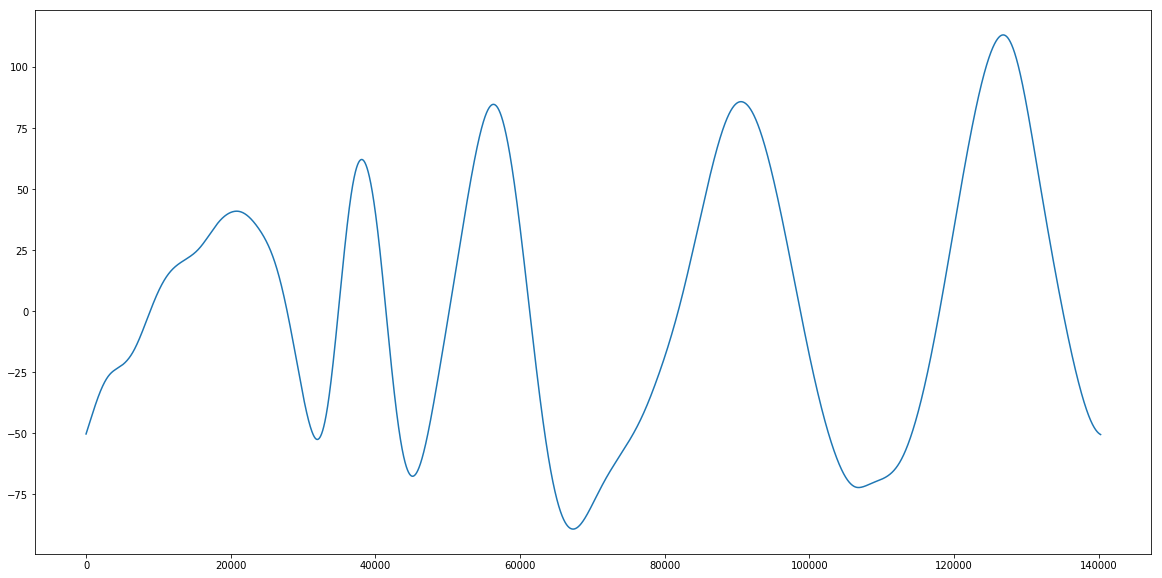

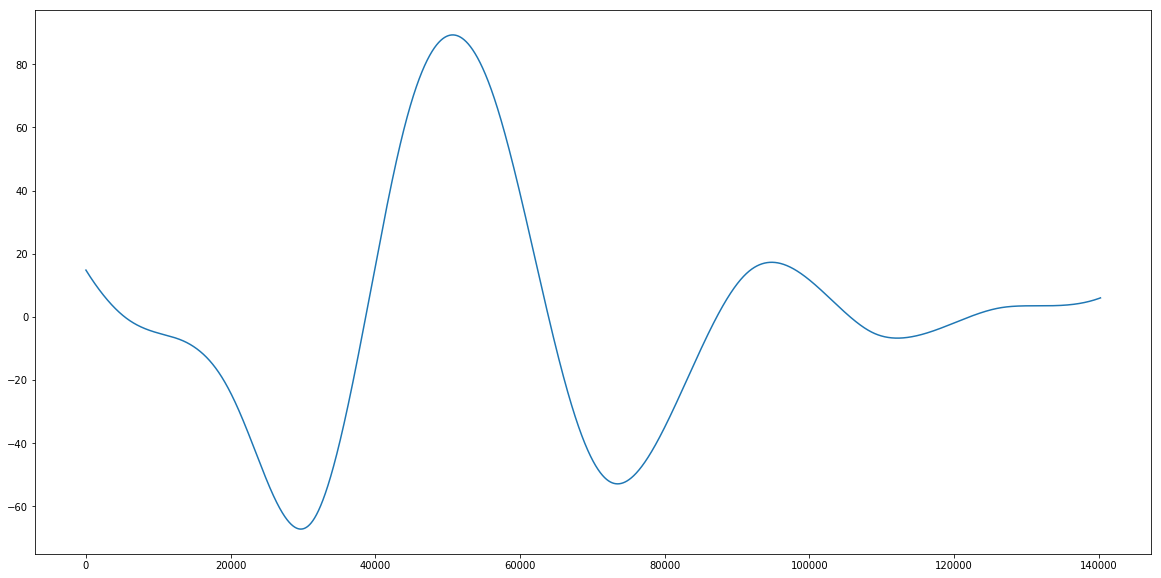

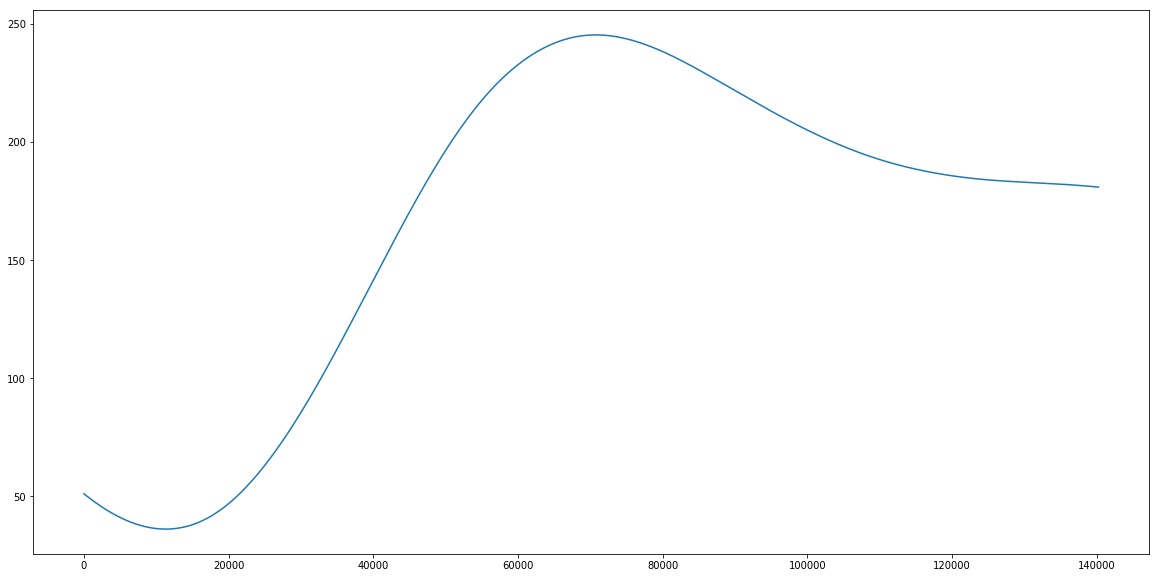

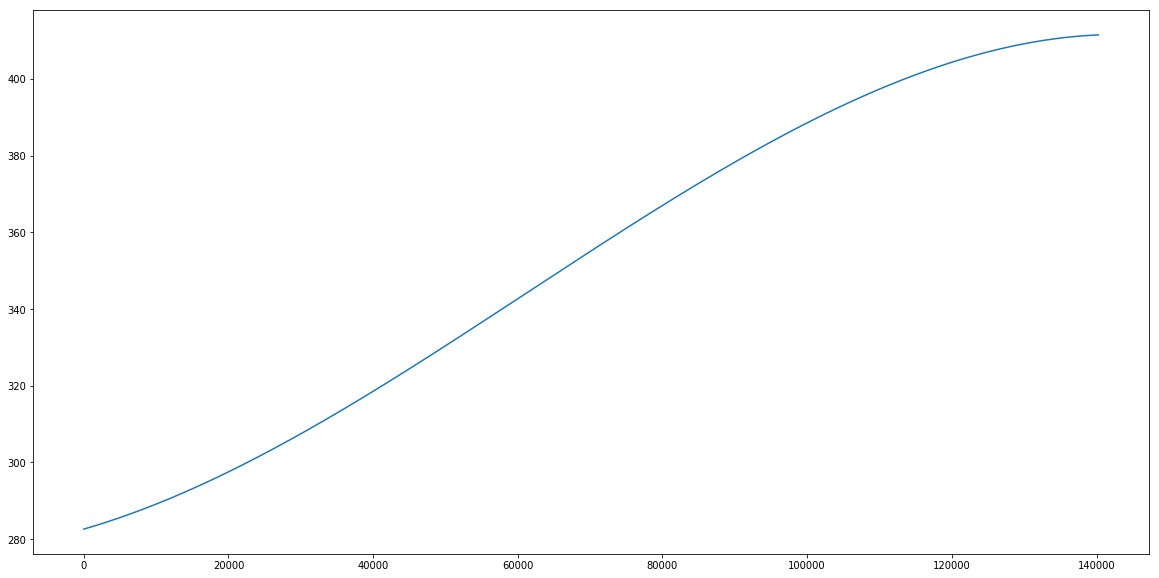

In [27]:
for i in range(17):
    plt.figure(figsize=(20, 10))
    plt.plot(imf[i])
    plt.show()

In [40]:
cols = list(data.columns[1:-17])

In [50]:
class SelfBoostedNet(nn.Module):
    def __init__(self, input_dim, aux_outputs, n_conv_channels, conv_kernel_size, n_gru_units):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, n_conv_channels, conv_kernel_size)
        self.conv2 = nn.Conv1d(n_conv_channels, n_conv_channels, conv_kernel_size)
        self.conv3 = nn.Conv1d(n_conv_channels, n_conv_channels, conv_kernel_size)
        self.maxpool = nn.MaxPool1d(2, 2)
        self.gru = nn.GRU(n_conv_channels, n_gru_units, num_layers=2, batch_first=True)
        self.aux_output = nn.Linear(n_gru_units, aux_outputs)
        self.main_output = nn.Linear(n_gru_units, 1)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.maxpool(x)
        x = x.permute(0, 2, 1)
        output, h = self.gru(x)
        main_output = self.main_output(h[-1])
        aux_output = self.aux_output(h[-1])
        return main_output.squeeze(1), aux_output

In [51]:
depth = 20
alpha = 0.1

In [52]:
imf_cols = ['imf_{}'.format(i) for i in range(imf.shape[0])]

In [53]:
for i, name in enumerate(imf_cols):
    data[name] = imf[i]

In [54]:
train_length = int(0.6*len(data))
val_length = int(0.2*len(data))

In [55]:
y = data["target"].shift(-1).fillna(method='ffill').values

#### Test with imf features and with multitask learning


In [56]:
res = {}
for i in range(1, imf.shape[0]+1):
    print("Step: ", i)
    X = np.zeros((len(data), depth, len(cols) + len(imf_cols[:i])))
    for j, name in enumerate(cols + imf_cols[:i]):
        for k in range(depth):
            X[:, k, j] = data[name].shift(depth - k - 1).fillna(method='bfill')
    y_aux = data[imf_cols[:i]].shift(-1).fillna(method='ffill').values
    
    X_train = X[:train_length]
    X_val = X[train_length:train_length+val_length]
    X_test = X[-val_length:]
    
    y_train = y[:train_length]
    y_val = y[train_length:train_length+val_length]
    y_test = y[-val_length:]
    
    y_aux_train = y_aux[:train_length]
    y_aux_val = y_aux[train_length:train_length+val_length]
    y_aux_test = y_aux[-val_length:]
    
    X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
    X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
    X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
    X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)
    
    y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)
    y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
    y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
    y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)
    
    y_aux_train_min, y_aux_train_max = y_aux_train.min(axis=0), y_aux_train.max(axis=0)
    y_aux_train = (y_aux_train - y_aux_train_min)/(y_aux_train_max - y_aux_train_min + 1e-9)
    y_aux_val = (y_aux_val - y_aux_train_min)/(y_aux_train_max - y_aux_train_min + 1e-9)
    y_aux_test = (y_aux_test - y_aux_train_min)/(y_aux_train_max - y_aux_train_min + 1e-9)
    
    X_train_t = torch.Tensor(X_train)
    X_val_t = torch.Tensor(X_val)
    X_test_t = torch.Tensor(X_test)
    
    y_train_t = torch.Tensor(y_train)
    y_val_t = torch.Tensor(y_val)
    y_test_t = torch.Tensor(y_test)
    
    y_aux_train_t = torch.Tensor(y_aux_train)
    y_aux_val_t = torch.Tensor(y_aux_val)
    y_aux_test_t = torch.Tensor(y_aux_test)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t, y_aux_train_t), shuffle=True, batch_size=64)
    val_loader = DataLoader(TensorDataset(X_val_t, y_val_t, y_aux_val_t), shuffle=False, batch_size=64)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t, y_aux_test_t), shuffle=False, batch_size=64)
    
    model = SelfBoostedNet(X_train_t.shape[2], i, 32, 3, 64).cuda()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    loss = nn.MSELoss()
    val_loss = 99999
    for e in range(100):
        train_main_loss, train_aux_loss = 0, 0
        for batch_x, batch_y, batch_y_aux in tqdm_notebook(train_loader):
            opt.zero_grad()
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_aux = batch_y_aux.cuda()
            main_output, aux_output = model(batch_x)
            main_loss = loss(main_output, batch_y)
            aux_loss = loss(aux_output, batch_y_aux)
            total_loss = main_loss + alpha*aux_loss
            total_loss.backward()
            opt.step()
            train_main_loss += main_loss.item()*batch_x.shape[0]
            train_aux_loss += aux_loss.item()*batch_x.shape[0]
        with torch.no_grad():
            val_main_loss, val_aux_loss = 0, 0
            for batch_x, batch_y, batch_y_aux in val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                batch_y_aux = batch_y_aux.cuda()
                main_output, aux_output = model(batch_x)
                main_loss = loss(main_output, batch_y)
                aux_loss = loss(aux_output, batch_y_aux)
                val_main_loss += main_loss.item()*batch_x.shape[0]
                val_aux_loss += aux_loss.item()*batch_x.shape[0]
            train_main_loss /= X_train_t.shape[0]
            train_aux_loss /= X_train_t.shape[0]
            val_main_loss /= X_val_t.shape[0]
            val_aux_loss /= X_val_t.shape[0]
            if val_loss > val_main_loss:
                val_loss = val_main_loss
                torch.save(model.state_dict(), 'self_boost_electricity_load.pt')
            
        print("Iter: ", e,
              "train main loss: ", train_main_loss, 
              "train aux loss: ", train_aux_loss, 
              "val main loss: ", val_main_loss,
              "val aux loss: ", val_aux_loss)
        
    model.load_state_dict(torch.load('self_boost_electricity_load.pt'))
    
    with torch.no_grad():
        val_main_loss, val_aux_loss = 0, 0
        for batch_x, batch_y, batch_y_aux in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_aux = batch_y_aux.cuda()
            main_output, aux_output = model(batch_x)
            main_loss = loss(main_output, batch_y)
            aux_loss = loss(aux_output, batch_y_aux)
            val_main_loss += main_loss.item()*batch_x.shape[0]
            val_aux_loss += aux_loss.item()*batch_x.shape[0]

        test_main_loss, test_aux_loss = 0, 0
        for batch_x, batch_y, batch_y_aux in test_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_aux = batch_y_aux.cuda()
            main_output, aux_output = model(batch_x)
            main_loss = loss(main_output, batch_y)
            aux_loss = loss(aux_output, batch_y_aux)
            test_main_loss += main_loss.item()*batch_x.shape[0]
            test_aux_loss += aux_loss.item()*batch_x.shape[0]
    
    res[i] = (val_main_loss/len(X_val_t), val_aux_loss/len(X_val_t), test_main_loss/len(X_test_t),
              test_aux_loss/len(X_test_t))

Step:  1



Iter:  0 train main loss:  0.0017435619968354575 train aux loss:  0.013438732536582034 val main loss:  1.2923348852249363 val aux loss:  0.014242537713657013



Iter:  1 train main loss:  0.0003040934942916333 train aux loss:  0.011991118239714629 val main loss:  1.1363789413977192 val aux loss:  0.014036577412727992



Iter:  2 train main loss:  0.00024997852883070897 train aux loss:  0.011966204902204399 val main loss:  1.0648099992072053 val aux loss:  0.015344956073733236



Iter:  3 train main loss:  0.00023003879184607537 train aux loss:  0.011940883496034976 val main loss:  0.9024046677518358 val aux loss:  0.022652239057679217



Iter:  4 train main loss:  0.00020748953564411933 train aux loss:  0.011920822961531808 val main loss:  0.9823237868295293 val aux loss:  0.020289051695722662



Iter:  5 train main loss:  0.00021036699198493462 train aux loss:  0.011898289640823501 val main loss:  0.8621849748968503 val aux loss:  0.013208669637612783



Iter:  6 train main loss:  0.0001971349137019004 train aux loss:  0.011814183373623818 val main loss:  0.8399449067414663 val aux loss:  0.02264752528608251



Iter:  7 train main loss:  0.00019720018946362938 train aux loss:  0.011312659688009024 val main loss:  0.9374651557222632 val aux loss:  0.04402754835369157



Iter:  8 train main loss:  0.00019700681791326482 train aux loss:  0.00991312891255557 val main loss:  1.136951207416738 val aux loss:  0.0452733533374915



Iter:  9 train main loss:  0.00018298648616446212 train aux loss:  0.009432626114394466 val main loss:  1.240297253295651 val aux loss:  0.025831851447970903



Iter:  10 train main loss:  0.00017352881987743555 train aux loss:  0.009299809888378259 val main loss:  1.1941018617817507 val aux loss:  0.045690816587440036



Iter:  11 train main loss:  0.00016616700582524 train aux loss:  0.009222643662024025 val main loss:  1.1862253685550939 val aux loss:  0.025398460984959667



Iter:  12 train main loss:  0.00016636316950801948 train aux loss:  0.009162676573590222 val main loss:  1.1194867612225972 val aux loss:  0.025828197063920477



Iter:  13 train main loss:  0.00015905441764810062 train aux loss:  0.009045746083841169 val main loss:  0.9912974603378787 val aux loss:  0.026703457749947365



Iter:  14 train main loss:  0.0001546438379017246 train aux loss:  0.008984461240211442 val main loss:  0.9391410480466749 val aux loss:  0.02600877853793378



Iter:  15 train main loss:  0.00015692437568031324 train aux loss:  0.008945043427287133 val main loss:  0.9453542942255202 val aux loss:  0.030742710066139795



Iter:  16 train main loss:  0.00015259252314584444 train aux loss:  0.008930719785891893 val main loss:  0.9691669887919442 val aux loss:  0.02487695414522754



Iter:  17 train main loss:  0.00015201070015674248 train aux loss:  0.008880853275369659 val main loss:  0.9828248271195837 val aux loss:  0.017509295483623812



Iter:  18 train main loss:  0.0001540500925198991 train aux loss:  0.008845926941194973 val main loss:  0.8911361746519352 val aux loss:  0.029291687647603797



Iter:  19 train main loss:  0.00015307301572274224 train aux loss:  0.008820725861613341 val main loss:  0.9996524308584871 val aux loss:  0.01610488595644772



Iter:  20 train main loss:  0.00014541244835443163 train aux loss:  0.008791563408377468 val main loss:  0.9155729226998433 val aux loss:  0.023915539853388238



Iter:  21 train main loss:  0.00014877194545513182 train aux loss:  0.008784344684648551 val main loss:  0.8837013063886223 val aux loss:  0.06083469425626653



Iter:  22 train main loss:  0.00014404259876456464 train aux loss:  0.008778667405581293 val main loss:  0.8846441445715014 val aux loss:  0.047119838692422374



Iter:  23 train main loss:  0.00014161099519040434 train aux loss:  0.008714297249588155 val main loss:  0.9544307137298818 val aux loss:  0.03519817480135421



Iter:  24 train main loss:  0.00014861846119040584 train aux loss:  0.008679142866395697 val main loss:  0.9415369468622359 val aux loss:  0.025121262451219928



Iter:  25 train main loss:  0.00014114738188237056 train aux loss:  0.008668493721160703 val main loss:  1.0120050594517602 val aux loss:  0.024829308009838544



Iter:  26 train main loss:  0.00013694305216652587 train aux loss:  0.008651790436906935 val main loss:  0.9577777855565918 val aux loss:  0.031970471784237134



Iter:  27 train main loss:  0.000149050908010647 train aux loss:  0.008630857872483688 val main loss:  0.8693415315642049 val aux loss:  0.036056291245178784



Iter:  28 train main loss:  0.0001379962384189656 train aux loss:  0.008610660146627534 val main loss:  0.8871658384262897 val aux loss:  0.02271135642974246



Iter:  29 train main loss:  0.00013754558570359994 train aux loss:  0.008598861710501306 val main loss:  0.8072602244266394 val aux loss:  0.05025207394247497



Iter:  30 train main loss:  0.0001402836453279524 train aux loss:  0.008567658233403335 val main loss:  0.8198107425412469 val aux loss:  0.028118682995359957



Iter:  31 train main loss:  0.00013453120380821828 train aux loss:  0.00855013616953691 val main loss:  0.9080348768729714 val aux loss:  0.03719385844004893



Iter:  32 train main loss:  0.0001438318544353735 train aux loss:  0.00854138767604557 val main loss:  0.7809646543070423 val aux loss:  0.04846686023458759



Iter:  33 train main loss:  0.00013755646570561133 train aux loss:  0.008526999139291416 val main loss:  0.8412810034205879 val aux loss:  0.1020849853759887



Iter:  34 train main loss:  0.000134513703350874 train aux loss:  0.008520377828676026 val main loss:  0.7378012558378534 val aux loss:  0.09742212077759918



Iter:  35 train main loss:  0.00013461138609682804 train aux loss:  0.008485304830114901 val main loss:  0.6631421746999453 val aux loss:  0.1056806144269812



Iter:  36 train main loss:  0.00013918328164936046 train aux loss:  0.00847235737011686 val main loss:  0.7813919079734531 val aux loss:  0.08711057441640906



Iter:  37 train main loss:  0.00013255309584961168 train aux loss:  0.008468019372454347 val main loss:  0.7671866977247132 val aux loss:  0.08926059564968056



Iter:  38 train main loss:  0.00013382018493522457 train aux loss:  0.00845466543725924 val main loss:  0.5128879992333231 val aux loss:  0.1969658536108406



Iter:  39 train main loss:  0.0001295019318196146 train aux loss:  0.008449017440536168 val main loss:  0.5703965213878482 val aux loss:  0.16611021474252932



Iter:  40 train main loss:  0.00013568715273594938 train aux loss:  0.008431098176672156 val main loss:  0.584886890245347 val aux loss:  0.14643107994597784



Iter:  41 train main loss:  0.00013029340887534918 train aux loss:  0.008415244389307894 val main loss:  0.5217350089227583 val aux loss:  0.16597662137126817



Iter:  42 train main loss:  0.00013309851875408174 train aux loss:  0.008404652105459017 val main loss:  0.5472473801748103 val aux loss:  0.18913318787274364



Iter:  43 train main loss:  0.00013033097905774312 train aux loss:  0.008407368806809423 val main loss:  0.4765894964767568 val aux loss:  0.18892755930017718



Iter:  44 train main loss:  0.00013214246020900325 train aux loss:  0.008393160878019248 val main loss:  0.45290538896871446 val aux loss:  0.1677521709082475



Iter:  45 train main loss:  0.00012947242914298942 train aux loss:  0.008385691970405543 val main loss:  0.439654761478852 val aux loss:  0.10862335453062856



Iter:  46 train main loss:  0.0001261854520011994 train aux loss:  0.00837797734164794 val main loss:  0.5607877914277812 val aux loss:  0.12422014748057615



Iter:  47 train main loss:  0.00012632496753063575 train aux loss:  0.008334585693969358 val main loss:  0.4590105487585759 val aux loss:  0.1294498190064383



Iter:  48 train main loss:  0.0001297911720781546 train aux loss:  0.008322810167749857 val main loss:  0.501521517970814 val aux loss:  0.08577366380415338



Iter:  49 train main loss:  0.00012669157380743113 train aux loss:  0.00832344548522625 val main loss:  0.44721382837132334 val aux loss:  0.1360311170672802



Iter:  50 train main loss:  0.0001253633444331575 train aux loss:  0.008305215629173659 val main loss:  0.4285947702189137 val aux loss:  0.11156402042142967



Iter:  51 train main loss:  0.0001271280013481522 train aux loss:  0.008287339774284398 val main loss:  0.5173796522658005 val aux loss:  0.10732674637605474



Iter:  52 train main loss:  0.00012591505177069539 train aux loss:  0.008282469015210321 val main loss:  0.4720681008780329 val aux loss:  0.16004230950574458



Iter:  53 train main loss:  0.00012346986723771786 train aux loss:  0.008269292172591447 val main loss:  0.406375508284057 val aux loss:  0.06323153408178714



Iter:  54 train main loss:  0.0001240711354004863 train aux loss:  0.008269953970492652 val main loss:  0.4188418891133145 val aux loss:  0.0708347001642521



Iter:  55 train main loss:  0.0001259224589768909 train aux loss:  0.00823864673924793 val main loss:  0.513071857347618 val aux loss:  0.06637482426473344



Iter:  56 train main loss:  0.00012312337981297374 train aux loss:  0.008235408082607861 val main loss:  0.43918741166115277 val aux loss:  0.07548039095922293



Iter:  57 train main loss:  0.00012511043795200284 train aux loss:  0.00819927308799378 val main loss:  0.47208616939628595 val aux loss:  0.053390990514821504



Iter:  58 train main loss:  0.0001227594416791096 train aux loss:  0.008192433024803237 val main loss:  0.43700008552071856 val aux loss:  0.14650153460479165



Iter:  59 train main loss:  0.0001271254703888353 train aux loss:  0.008192191125708556 val main loss:  0.45365974996318964 val aux loss:  0.10712826196073079



Iter:  68 train main loss:  0.00011878447158243068 train aux loss:  0.007987384930392562 val main loss:  0.40908304620135105 val aux loss:  0.03739840547376204



Iter:  69 train main loss:  0.00011870314193263747 train aux loss:  0.007964458001541956 val main loss:  0.40247142865130264 val aux loss:  0.027712246890688685



Iter:  70 train main loss:  0.00011843562552641644 train aux loss:  0.007942115013439683 val main loss:  0.4252401101511008 val aux loss:  0.019486117796342704



Iter:  71 train main loss:  0.00011774754444332499 train aux loss:  0.00792771135365834 val main loss:  0.4255080416094962 val aux loss:  0.03252256868585685



Iter:  72 train main loss:  0.00011633170121271828 train aux loss:  0.007888927848455907 val main loss:  0.40855533457671095 val aux loss:  0.033715866785519716



Iter:  73 train main loss:  0.0001172439187136089 train aux loss:  0.007860704390036503 val main loss:  0.41535953079241694 val aux loss:  0.0318705181616678



Iter:  74 train main loss:  0.00012216712371431528 train aux loss:  0.00784281243911356 val main loss:  0.393396552010942 val aux loss:  0.029118627602400023



Iter:  75 train main loss:  0.00011643925816617166 train aux loss:  0.0078018854775197665 val main loss:  0.3859943392424955 val aux loss:  0.058738886514132574



Iter:  76 train main loss:  0.00011710479101036009 train aux loss:  0.007775452968231647 val main loss:  0.3702925759297624 val aux loss:  0.06009339748092469



Iter:  77 train main loss:  0.00011642096978019219 train aux loss:  0.007752108138951082 val main loss:  0.3992015546036063 val aux loss:  0.043069326764159296



Iter:  78 train main loss:  0.0001182912227404959 train aux loss:  0.007724435149102005 val main loss:  0.38852812164056355 val aux loss:  0.037427896703400035



Iter:  79 train main loss:  0.0001182158495065892 train aux loss:  0.007695210336209528 val main loss:  0.41829677210390104 val aux loss:  0.027306706589314927



Iter:  80 train main loss:  0.00011645368566938118 train aux loss:  0.0076514962538608445 val main loss:  0.4347132403275165 val aux loss:  0.046960100514180717



Iter:  81 train main loss:  0.00011719247219132704 train aux loss:  0.0076348339264797555 val main loss:  0.3435382966602666 val aux loss:  0.030683531070675302


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Iter:  13 train main loss:  0.00015051681552811483 train aux loss:  0.007894571182484779 val main loss:  0.8014023377348621 val aux loss:  0.11534356019405846



Iter:  14 train main loss:  0.0001587631484102776 train aux loss:  0.00750226195030304 val main loss:  0.8008225653002153 val aux loss:  0.15026769681015711



Iter:  15 train main loss:  0.00014584372552330923 train aux loss:  0.0070182027127522265 val main loss:  0.8732287149831468 val aux loss:  0.14491982769147627



Iter:  16 train main loss:  0.00014441342722587986 train aux loss:  0.006798735001732984 val main loss:  0.8464354909905658 val aux loss:  0.11104129019037406



Iter:  17 train main loss:  0.00014795386499012443 train aux loss:  0.006690936292004085 val main loss:  0.8392528982413433 val aux loss:  0.1389771608546738



Iter:  18 train main loss:  0.00013639846273656194 train aux loss:  0.006602603841606466 val main loss:  0.7958518346860377 val aux loss:  0.13857140408851498



Iter:  19 train main loss:  0.00014018359124397852 train aux loss:  0.0065279719580802475 val main loss:  0.7889685622328753 val aux loss:  0.09670715899944458



Iter:  20 train main loss:  0.00013795995158483485 train aux loss:  0.006482102332255499 val main loss:  0.8677685598459726 val aux loss:  0.07866457172891153



Iter:  21 train main loss:  0.00013889876136443367 train aux loss:  0.0064362336157078315 val main loss:  0.8030300258787746 val aux loss:  0.07741463371650437



Iter:  22 train main loss:  0.00013641472020782752 train aux loss:  0.006404009402040527 val main loss:  0.7585526439220668 val aux loss:  0.06398749840420086



Iter:  23 train main loss:  0.0001379588568295867 train aux loss:  0.006389638354026515 val main loss:  0.7698068530637088 val aux loss:  0.049667087151658976



Iter:  24 train main loss:  0.00013459237010894843 train aux loss:  0.006356397647259987 val main loss:  0.7920512959911151 val aux loss:  0.05971016752342078



Iter:  25 train main loss:  0.00013421000528780836 train aux loss:  0.0063367138357318786 val main loss:  0.7583184263394614 val aux loss:  0.05140459637680303



Iter:  26 train main loss:  0.0001274382269531608 train aux loss:  0.006323632878567304 val main loss:  0.804101750264027 val aux loss:  0.060603190426061354



Iter:  27 train main loss:  0.00013074115709238186 train aux loss:  0.006290650641720711 val main loss:  0.7552931490563572 val aux loss:  0.08513275976577488


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  60 train main loss:  0.00010727038904472312 train aux loss:  0.005902275310726646 val main loss:  0.5005406152956774 val aux loss:  0.04007561672665504



Iter:  61 train main loss:  0.00010777632283428924 train aux loss:  0.005888203948794359 val main loss:  0.4874225350913302 val aux loss:  0.03894720529316491



Iter:  62 train main loss:  0.00010911587709440415 train aux loss:  0.005878877037991568 val main loss:  0.4962478847246577 val aux loss:  0.02794949828465235



Iter:  63 train main loss:  0.000108701173482693 train aux loss:  0.005861524308983424 val main loss:  0.5012785933390146 val aux loss:  0.045011175226128394



Iter:  64 train main loss:  0.00010518395266941292 train aux loss:  0.005847531707167357 val main loss:  0.4396930967794351 val aux loss:  0.049784873959773615



Iter:  65 train main loss:  0.0001071339455948679 train aux loss:  0.005834858399631559 val main loss:  0.4918062014812941 val aux loss:  0.03561350943372655



Iter:  66 train main loss:  0.00010427137121414709 train aux loss:  0.0058190057537359 val main loss:  0.4752624408169598 val aux loss:  0.055351589951134456



Iter:  67 train main loss:  0.0001053728626961712 train aux loss:  0.005819748139548441 val main loss:  0.4478098981076364 val aux loss:  0.03723786934849133



Iter:  68 train main loss:  0.0001085732997453413 train aux loss:  0.005816571273936174 val main loss:  0.4414600208497299 val aux loss:  0.019444943805328813



Iter:  69 train main loss:  0.00010350850333433519 train aux loss:  0.0057784496100729815 val main loss:  0.47431247778917357 val aux loss:  0.03625437737871544



Iter:  70 train main loss:  0.00010512635168604702 train aux loss:  0.005775603704014295 val main loss:  0.45628777784870256 val aux loss:  0.06818339557254031



Iter:  71 train main loss:  0.00010488469937730171 train aux loss:  0.005766734570378939 val main loss:  0.4941417228959801 val aux loss:  0.048658327596304396



Iter:  72 train main loss:  0.00010438468805248197 train aux loss:  0.005771008282336767 val main loss:  0.45194651128918845 val aux loss:  0.0398568791365831



Iter:  73 train main loss:  0.00010663376083750454 train aux loss:  0.005771023813471231 val main loss:  0.4816306565415211 val aux loss:  0.05164699343632646



Iter:  74 train main loss:  0.00010964931776316526 train aux loss:  0.005735040211864 val main loss:  0.48192468793055215 val aux loss:  0.07027655877317704


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  7 train main loss:  0.00018143695933972313 train aux loss:  0.007231312061703607 val main loss:  0.27329393422624776 val aux loss:  0.3381270155029617



Iter:  8 train main loss:  0.00016560730535513228 train aux loss:  0.006811826573488151 val main loss:  0.5242556736584323 val aux loss:  0.24615230946306077



Iter:  9 train main loss:  0.00016826745303122277 train aux loss:  0.0064159109449926895 val main loss:  0.30440082658856626 val aux loss:  0.2756339484574531



Iter:  10 train main loss:  0.0001595931083470954 train aux loss:  0.006121283270920068 val main loss:  0.328886275002125 val aux loss:  0.24289308824097977



Iter:  11 train main loss:  0.0001585057202436629 train aux loss:  0.005902966308865848 val main loss:  0.19921208786004269 val aux loss:  0.39587363684450655



Iter:  12 train main loss:  0.00015431666919780122 train aux loss:  0.005747046975768577 val main loss:  0.23117540255161054 val aux loss:  0.35349263549955945



Iter:  13 train main loss:  0.000148174124508761 train aux loss:  0.005580918365460879 val main loss:  0.31830317958775595 val aux loss:  0.3819662454916506



Iter:  14 train main loss:  0.00014812153775643105 train aux loss:  0.005396894862772397 val main loss:  0.24404708189073507 val aux loss:  0.23740718613250647



Iter:  15 train main loss:  0.00014846318269993446 train aux loss:  0.0050704588462365625 val main loss:  0.26701005771937447 val aux loss:  0.23374012471348168



Iter:  16 train main loss:  0.00014263711294504525 train aux loss:  0.004865382153816153 val main loss:  0.23647137657179088 val aux loss:  0.2907730788741493



Iter:  17 train main loss:  0.0001411193343162542 train aux loss:  0.004789391587382918 val main loss:  0.17281904219055136 val aux loss:  0.23766749930578962



Iter:  18 train main loss:  0.00014366721621469127 train aux loss:  0.00473382099654966 val main loss:  0.12540666016894364 val aux loss:  0.2528276349588884



Iter:  19 train main loss:  0.0001348114256805772 train aux loss:  0.004708373634917341 val main loss:  0.1568420861145264 val aux loss:  0.21561320242180654



Iter:  20 train main loss:  0.00013524410689731502 train aux loss:  0.004668513348643555 val main loss:  0.18842557402647914 val aux loss:  0.20396987827182186


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  53 train main loss:  0.00010424742594279103 train aux loss:  0.004244866455771195 val main loss:  0.1002289603687516 val aux loss:  0.08564354029611353



Iter:  54 train main loss:  9.714626176751285e-05 train aux loss:  0.004225189311334305 val main loss:  0.07664983148657138 val aux loss:  0.07581279616975443



Iter:  55 train main loss:  0.00010276254599920606 train aux loss:  0.004225595362078119 val main loss:  0.0701722945627171 val aux loss:  0.06935333734305375



Iter:  56 train main loss:  0.0001011603820460326 train aux loss:  0.004213319964522167 val main loss:  0.08116963867918557 val aux loss:  0.07353091703083807



Iter:  57 train main loss:  0.00010356494997997469 train aux loss:  0.00421483473580006 val main loss:  0.07059476179295575 val aux loss:  0.06326782111650754



Iter:  58 train main loss:  0.00010063074084502102 train aux loss:  0.0041957201579247445 val main loss:  0.0726781042493182 val aux loss:  0.07223088794819922



Iter:  59 train main loss:  9.910550203460784e-05 train aux loss:  0.004205881664430947 val main loss:  0.07597434942104146 val aux loss:  0.066596742793915



Iter:  60 train main loss:  9.697776181311092e-05 train aux loss:  0.004186691402245289 val main loss:  0.06377696372301804 val aux loss:  0.06449063854554789



Iter:  61 train main loss:  9.677597603403234e-05 train aux loss:  0.004185190735306224 val main loss:  0.06944466056116264 val aux loss:  0.06390717523956374



Iter:  62 train main loss:  9.557654965603242e-05 train aux loss:  0.004177757777819613 val main loss:  0.05628057267618911 val aux loss:  0.05283884466313826



Iter:  63 train main loss:  9.768452261855875e-05 train aux loss:  0.004170385589402138 val main loss:  0.05475130063480268 val aux loss:  0.05347022115504277



Iter:  64 train main loss:  9.792160547314566e-05 train aux loss:  0.004164598809294368 val main loss:  0.05664223453316449 val aux loss:  0.057412844050592896



Iter:  65 train main loss:  9.521280302762416e-05 train aux loss:  0.004153076831055762 val main loss:  0.05347927068029301 val aux loss:  0.054764704004874064



Iter:  66 train main loss:  9.45985350750659e-05 train aux loss:  0.004152051149422857 val main loss:  0.05623493524527437 val aux loss:  0.0529394200272426


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  3 train main loss:  0.00022256497386147266 train aux loss:  0.0074487451060257295 val main loss:  1.096769602306463 val aux loss:  0.2543449241789236



Iter:  4 train main loss:  0.00019368289219023974 train aux loss:  0.006970769693911218 val main loss:  0.934002157719077 val aux loss:  0.0842337415781953



Iter:  5 train main loss:  0.00018419558346193806 train aux loss:  0.006716795863653118 val main loss:  0.6577851604925934 val aux loss:  0.12406536256138481



Iter:  6 train main loss:  0.00017816592151687852 train aux loss:  0.006484190218410735 val main loss:  0.4113701588843177 val aux loss:  0.2119353562524402



Iter:  7 train main loss:  0.00016967360914715932 train aux loss:  0.006100818023199408 val main loss:  0.24114175703660268 val aux loss:  0.5577734587764209



Iter:  8 train main loss:  0.00015679575186248258 train aux loss:  0.005691258001790983 val main loss:  0.34856580581115554 val aux loss:  0.5893486453865876



Iter:  9 train main loss:  0.0001579085190910689 train aux loss:  0.005469286627127904 val main loss:  0.4604711985773953 val aux loss:  0.5705390839919929



Iter:  10 train main loss:  0.00015489981109037532 train aux loss:  0.005133847592909444 val main loss:  0.5153146737890392 val aux loss:  0.392798043635817



Iter:  11 train main loss:  0.00014855663398470213 train aux loss:  0.004698669363452509 val main loss:  0.4175169114015811 val aux loss:  0.3976606370019367



Iter:  12 train main loss:  0.00014973940027824607 train aux loss:  0.004512585065949474 val main loss:  0.5618721891039798 val aux loss:  0.42741029313210177



Iter:  13 train main loss:  0.0001396681704633772 train aux loss:  0.004435701767675271 val main loss:  0.6646715095912792 val aux loss:  0.3535533832239852



Iter:  14 train main loss:  0.00014318868758755147 train aux loss:  0.004365358771945869 val main loss:  0.6150479149722775 val aux loss:  0.3846846356239469



Iter:  15 train main loss:  0.0001374473890573121 train aux loss:  0.00431222933339596 val main loss:  0.6493754238461301 val aux loss:  0.31643791803425125



Iter:  16 train main loss:  0.0001377503901573377 train aux loss:  0.0042418851944217 val main loss:  0.6433240489648161 val aux loss:  0.3517500648326081


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  48 train main loss:  0.00010373607730464951 train aux loss:  0.003381885465936676 val main loss:  0.46215027897427774 val aux loss:  0.25789417471897497



Iter:  49 train main loss:  0.00010340651221610432 train aux loss:  0.0033820490215440095 val main loss:  0.43136216979073755 val aux loss:  0.2741408395223671



Iter:  50 train main loss:  0.00010225328251146145 train aux loss:  0.0033748058010200453 val main loss:  0.4087777798146259 val aux loss:  0.26450347041200645



Iter:  51 train main loss:  0.00010501624336007977 train aux loss:  0.0033673530790994492 val main loss:  0.4171266834099555 val aux loss:  0.2807393690905789



Iter:  52 train main loss:  0.00010142633291618586 train aux loss:  0.0033644831786079927 val main loss:  0.3905709350764104 val aux loss:  0.2739559931442243



Iter:  53 train main loss:  0.000100930064750961 train aux loss:  0.0033502932253517124 val main loss:  0.39132974411320315 val aux loss:  0.2543641667000168



Iter:  54 train main loss:  0.00010086426269531044 train aux loss:  0.003340030840199955 val main loss:  0.41237107018523245 val aux loss:  0.2196556954092786



Iter:  55 train main loss:  0.00010041095703505224 train aux loss:  0.003340604409596866 val main loss:  0.37420810099598456 val aux loss:  0.2192332803993734


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  61 train main loss:  9.769595962948078e-05 train aux loss:  0.00330650427141559 val main loss:  0.24027591461767883 val aux loss:  0.12500762180450625



Iter:  62 train main loss:  9.55150822117748e-05 train aux loss:  0.003290332742913667 val main loss:  0.2172011190525435 val aux loss:  0.1210424419133779



Iter:  63 train main loss:  9.645545963207652e-05 train aux loss:  0.003290294135847871 val main loss:  0.24583787064954055 val aux loss:  0.13592740043364024



Iter:  64 train main loss:  9.388816051758918e-05 train aux loss:  0.0032792961424595764 val main loss:  0.2203690660658596 val aux loss:  0.14381118056212197



Iter:  65 train main loss:  9.513189068672133e-05 train aux loss:  0.0032748571924922174 val main loss:  0.2850532872001205 val aux loss:  0.1596463342127152



Iter:  66 train main loss:  9.508767201001845e-05 train aux loss:  0.0032735925810836878 val main loss:  0.25550350302151775 val aux loss:  0.13945487709479903


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  77 train main loss:  8.969226473294555e-05 train aux loss:  0.003216561689814088 val main loss:  0.2096690237075737 val aux loss:  0.11871650278746756



Iter:  78 train main loss:  8.976932337495504e-05 train aux loss:  0.003213456917605867 val main loss:  0.2661681829895494 val aux loss:  0.1156530559749821



Iter:  79 train main loss:  9.181169145796499e-05 train aux loss:  0.0032076361953675705 val main loss:  0.2680453045354878 val aux loss:  0.12332047841674584



Iter:  80 train main loss:  9.019843584549912e-05 train aux loss:  0.0032038733919529166 val main loss:  0.2445351579782671 val aux loss:  0.1069110463586879



Iter:  81 train main loss:  8.658653794766996e-05 train aux loss:  0.003198019726858144 val main loss:  0.26306026218157746 val aux loss:  0.11517736470072262



Iter:  82 train main loss:  8.84548595521333e-05 train aux loss:  0.0031915978295233315 val main loss:  0.24983595912474404 val aux loss:  0.10895128183199383



Iter:  83 train main loss:  8.845770830219023e-05 train aux loss:  0.003194183008541458 val main loss:  0.22668389462988767 val aux loss:  0.11241698874381302



Iter:  84 train main loss:  8.562545329128704e-05 train aux loss:  0.003182411455372305 val main loss:  0.24669686513187794 val aux loss:  0.10902988951844347



Iter:  85 train main loss:  8.912621774960464e-05 train aux loss:  0.0031827743491483814 val main loss:  0.249834505746347 val aux loss:  0.09829065822534207



Iter:  86 train main loss:  8.70612412073902e-05 train aux loss:  0.00317461790915042 val main loss:  0.24004030577528787 val aux loss:  0.10122768294003374



Iter:  87 train main loss:  8.502871121986139e-05 train aux loss:  0.003170203101042314 val main loss:  0.2556680106341236 val aux loss:  0.1021238606497377



Iter:  88 train main loss:  8.621192347367541e-05 train aux loss:  0.0031689865072431294 val main loss:  0.2592443797878896 val aux loss:  0.10727658194970296



Iter:  89 train main loss:  8.582151324413854e-05 train aux loss:  0.0031623570173422576 val main loss:  0.21184051132536735 val aux loss:  0.09526857036716997



Iter:  90 train main loss:  8.512763044984946e-05 train aux loss:  0.003144827023574484 val main loss:  0.23527380059842445 val aux loss:  0.11255302574136399



Iter:  91 train main loss:  8.543798976342952e-05 train aux loss:  0.0031498110266146603 val main loss:  0.2524463770975707 val aux loss:  0.10996182884474216



Iter:  92 train main loss:  8.365523881637082e-05 train aux loss:  0.003137171528969618 val main loss:  0.25536378809846483 val aux loss:  0.12777470271581678



Iter:  93 train main loss:  8.319924836052172e-05 train aux loss:  0.003127268125467512 val main loss:  0.2752331143132317 val aux loss:  0.13183710061342788



Iter:  94 train main loss:  8.248818238120787e-05 train aux loss:  0.0031190046628125096 val main loss:  0.2524111625895948 val aux loss:  0.1357700418824202



Iter:  95 train main loss:  8.183095340761415e-05 train aux loss:  0.003129251938607606 val main loss:  0.2468385633895885 val aux loss:  0.12369639013076925



Iter:  96 train main loss:  8.260024568486888e-05 train aux loss:  0.003113544313699119 val main loss:  0.21285847140093167 val aux loss:  0.11410059952288829



Iter:  97 train main loss:  8.459901787607323e-05 train aux loss:  0.0031175165153851853 val main loss:  0.24847791929549035 val aux loss:  0.12557676692462483



Iter:  98 train main loss:  8.046830652900941e-05 train aux loss:  0.003099216156051201 val main loss:  0.2413862220134894 val aux loss:  0.11850961244137422



Iter:  99 train main loss:  8.323430293363603e-05 train aux loss:  0.0031002145056662667 val main loss:  0.22745955765852202 val aux loss:  0.12341529889566316
Step:  5



Iter:  0 train main loss:  0.0008922854452227791 train aux loss:  0.010902311857516842 val main loss:  0.7887430226308183 val aux loss:  0.02919842682685607



Iter:  1 train main loss:  0.00026410972500978637 train aux loss:  0.008064139084672132 val main loss:  0.47882061644156576 val aux loss:  0.09603020190634318



Iter:  2 train main loss:  0.0002245878853241499 train aux loss:  0.007278440611182488 val main loss:  0.39419970618187267 val aux loss:  0.1469070385970354



Iter:  3 train main loss:  0.00021552347201234231 train aux loss:  0.006565688187062451 val main loss:  0.30920561144529446 val aux loss:  0.48272131929031764



Iter:  4 train main loss:  0.00018416801119397233 train aux loss:  0.005829532521880896 val main loss:  0.4138667300249853 val aux loss:  0.5459180964254398



Iter:  5 train main loss:  0.00017672078952762503 train aux loss:  0.0055037463934108875 val main loss:  0.7267026124947528 val aux loss:  0.44626166433502845



Iter:  6 train main loss:  0.00016430284455468526 train aux loss:  0.005245564538802796 val main loss:  1.0200234493731093 val aux loss:  0.21392183419308905



Iter:  7 train main loss:  0.0001554390899783439 train aux loss:  0.004919216274421998 val main loss:  1.1104881598720633 val aux loss:  0.25717230997962376



Iter:  8 train main loss:  0.00015940804471180104 train aux loss:  0.004631306648507342 val main loss:  0.931292922878034 val aux loss:  0.26819149363887046



Iter:  9 train main loss:  0.00014558268402093237 train aux loss:  0.004383117520522042 val main loss:  0.8730922606108491 val aux loss:  0.35762051207427015



Iter:  10 train main loss:  0.00014673303844753576 train aux loss:  0.004220474991112428 val main loss:  0.8819205289042102 val aux loss:  0.30201137211547086



Iter:  11 train main loss:  0.00014630070386023556 train aux loss:  0.004070038381945066 val main loss:  0.8439097993946645 val aux loss:  0.49615620405957606



Iter:  12 train main loss:  0.00013672562286017615 train aux loss:  0.003888789587805515 val main loss:  0.7481917765291559 val aux loss:  0.6565388416235496



Iter:  13 train main loss:  0.000138101207375951 train aux loss:  0.0038037420882822554 val main loss:  0.6218216634248545 val aux loss:  0.6948347108870291



Iter:  14 train main loss:  0.00013983899858216017 train aux loss:  0.0037152803379778875 val main loss:  0.5477316613134249 val aux loss:  0.7707119790790621



Iter:  15 train main loss:  0.00012857868490404587 train aux loss:  0.003650482341393669 val main loss:  0.589437059255714 val aux loss:  0.8310622999455295



Iter:  16 train main loss:  0.00013141735777386066 train aux loss:  0.0035925778562520606 val main loss:  0.710401697760198 val aux loss:  1.1040496939868196



Iter:  17 train main loss:  0.000128994972902411 train aux loss:  0.0034968669482962674 val main loss:  0.5569683781989749 val aux loss:  1.1867476903242902



Iter:  18 train main loss:  0.00012735544530052869 train aux loss:  0.0034117975064333296 val main loss:  0.6764629356516809 val aux loss:  0.9948303582115754



Iter:  19 train main loss:  0.00012486283683071345 train aux loss:  0.003287316623607659 val main loss:  0.6561118569132441 val aux loss:  1.1174112640549412



Iter:  20 train main loss:  0.00012746327335972667 train aux loss:  0.0031985927636355555 val main loss:  0.6868795690890241 val aux loss:  1.0998696113970567



Iter:  21 train main loss:  0.00012675655812855225 train aux loss:  0.003145856237898412 val main loss:  0.6227608381583529 val aux loss:  1.0250339276366454



Iter:  22 train main loss:  0.0001190011278640434 train aux loss:  0.003068125523524567 val main loss:  0.5950978856016427 val aux loss:  1.050570381901119



Iter:  23 train main loss:  0.00011843525295109535 train aux loss:  0.003036092488688821 val main loss:  0.6248004087976381 val aux loss:  0.9620976374910535



Iter:  24 train main loss:  0.0001169923655318654 train aux loss:  0.0030104538318995416 val main loss:  0.5864221867703334 val aux loss:  0.9635552102382806



Iter:  25 train main loss:  0.00011597014223969782 train aux loss:  0.0029972933220156804 val main loss:  0.5873133829369651 val aux loss:  0.7553809248361183



Iter:  26 train main loss:  0.00011607805791896671 train aux loss:  0.002974215388248034 val main loss:  0.5482431675585279 val aux loss:  0.7690080613798816



Iter:  27 train main loss:  0.0001128771636190954 train aux loss:  0.0029629639593307913 val main loss:  0.5886564824388453 val aux loss:  0.5518794078951591



Iter:  28 train main loss:  0.0001152620574465649 train aux loss:  0.002951531100731953 val main loss:  0.5105618878792879 val aux loss:  0.5695954953839888



Iter:  29 train main loss:  0.00011177169884325061 train aux loss:  0.002926410978011062 val main loss:  0.517611138530477 val aux loss:  0.4828875448590213



Iter:  30 train main loss:  0.0001113755835158342 train aux loss:  0.0029177375415516097 val main loss:  0.5110323148930005 val aux loss:  0.451181155647285



Iter:  31 train main loss:  0.00011153388089054638 train aux loss:  0.0029131861989428027 val main loss:  0.49952825249553 val aux loss:  0.4699795142457318



Iter:  32 train main loss:  0.0001121803077292191 train aux loss:  0.0029005321319948664 val main loss:  0.4191389868386449 val aux loss:  0.3840674986980938



Iter:  33 train main loss:  0.00010941366430759966 train aux loss:  0.0028782672451035975 val main loss:  0.45263616871391205 val aux loss:  0.32273997984711555



Iter:  34 train main loss:  0.00010626766290522814 train aux loss:  0.0028669587422388326 val main loss:  0.38836214276394077 val aux loss:  0.30017173672569386



Iter:  35 train main loss:  0.00011190526975648719 train aux loss:  0.0028812766709263213 val main loss:  0.3680353933054647 val aux loss:  0.23580313861701566



Iter:  36 train main loss:  0.00010719392653413013 train aux loss:  0.002842431293677231 val main loss:  0.4208417106615688 val aux loss:  0.23599264353714516



Iter:  37 train main loss:  0.00010730430267111361 train aux loss:  0.0028566378293625335 val main loss:  0.3760725564672242 val aux loss:  0.22963052503476444



Iter:  38 train main loss:  0.00010908643799769786 train aux loss:  0.002851434132112936 val main loss:  0.34662784853026024 val aux loss:  0.2216089253941771



Iter:  39 train main loss:  0.00010910176092363928 train aux loss:  0.0028329603976077686 val main loss:  0.3172286816093992 val aux loss:  0.22690063125117996



Iter:  40 train main loss:  0.0001041848297181777 train aux loss:  0.0028205605513769456 val main loss:  0.32279770972711447 val aux loss:  0.23893608165934296



Iter:  41 train main loss:  0.00010475015287424897 train aux loss:  0.002827695512322255 val main loss:  0.27201262003475585 val aux loss:  0.1878945456917947



Iter:  42 train main loss:  0.00010676606468041531 train aux loss:  0.0028076872501343283 val main loss:  0.30736162018103325 val aux loss:  0.17181663559282584



Iter:  43 train main loss:  9.968132955863645e-05 train aux loss:  0.002795718676591971 val main loss:  0.2962083002073598 val aux loss:  0.16829370977211278



Iter:  44 train main loss:  0.0001023074844567806 train aux loss:  0.0028012578535185164 val main loss:  0.299089176381336 val aux loss:  0.18940418820919436



Iter:  45 train main loss:  0.0001027639281359747 train aux loss:  0.0027907437422213933 val main loss:  0.270672703324554 val aux loss:  0.19357816445864032



Iter:  46 train main loss:  9.934584981554537e-05 train aux loss:  0.00279328324835453 val main loss:  0.31913819931533033 val aux loss:  0.16033555913405395



Iter:  47 train main loss:  0.00010020864274566602 train aux loss:  0.002783458724232339 val main loss:  0.3037910902906414 val aux loss:  0.22886757576316016



Iter:  48 train main loss:  0.00010039692697647738 train aux loss:  0.0027822931765866883 val main loss:  0.303683868779574 val aux loss:  0.15179775123521652



Iter:  49 train main loss:  0.00010214460992154924 train aux loss:  0.002784464977951539 val main loss:  0.32000830591518187 val aux loss:  0.1988472093833899



Iter:  50 train main loss:  9.965118362598811e-05 train aux loss:  0.0027666379421200015 val main loss:  0.3106329799107163 val aux loss:  0.16465146374910267



Iter:  51 train main loss:  9.952713601207148e-05 train aux loss:  0.0027587664895302247 val main loss:  0.2974561498503594 val aux loss:  0.20514312724632222



Iter:  52 train main loss:  0.0001012038440735504 train aux loss:  0.0027579176927456685 val main loss:  0.27972381585570616 val aux loss:  0.2186849207325605



Iter:  53 train main loss:  9.611074243313018e-05 train aux loss:  0.0027476166690507554 val main loss:  0.32549170939314065 val aux loss:  0.19783152036456764



Iter:  54 train main loss:  9.711056082845751e-05 train aux loss:  0.0027577971191503864 val main loss:  0.3286997691909884 val aux loss:  0.1600660242822641



Iter:  55 train main loss:  9.573118337066813e-05 train aux loss:  0.002731658861975634 val main loss:  0.3566267852020903 val aux loss:  0.16127245741550741



Iter:  56 train main loss:  9.766442561759514e-05 train aux loss:  0.0027425242531675894 val main loss:  0.3028874172768533 val aux loss:  0.15996610729678473



Iter:  57 train main loss:  9.633012419977341e-05 train aux loss:  0.0027288563684691115 val main loss:  0.3220169677006895 val aux loss:  0.13910209853125743



Iter:  58 train main loss:  9.466309743871772e-05 train aux loss:  0.0027313524800782517 val main loss:  0.3363649173421119 val aux loss:  0.13264312373319456



Iter:  59 train main loss:  9.487790696616212e-05 train aux loss:  0.0027258542038924795 val main loss:  0.33599568688075987 val aux loss:  0.10821986006363875



Iter:  60 train main loss:  9.434981678488181e-05 train aux loss:  0.0027296861131481504 val main loss:  0.34799448461707916 val aux loss:  0.10631999987044448



Iter:  61 train main loss:  9.567846378077548e-05 train aux loss:  0.0027246835715756213 val main loss:  0.30897740040578775 val aux loss:  0.09393194998532119



Iter:  62 train main loss:  9.142299021705591e-05 train aux loss:  0.0027106268133203783 val main loss:  0.34080355469033047 val aux loss:  0.1088478006210033



Iter:  63 train main loss:  9.432290030525379e-05 train aux loss:  0.002717027606708356 val main loss:  0.3108244202093964 val aux loss:  0.10484968492545647



Iter:  64 train main loss:  9.375934958859961e-05 train aux loss:  0.0027127731083321062 val main loss:  0.3400631404735584 val aux loss:  0.09179606699740299



Iter:  65 train main loss:  9.238205649177442e-05 train aux loss:  0.0026950821063820465 val main loss:  0.30179934600211233 val aux loss:  0.08523150845076038



Iter:  66 train main loss:  9.238886436455454e-05 train aux loss:  0.0026953682786138673 val main loss:  0.32761798054969266 val aux loss:  0.08923540135946406



Iter:  67 train main loss:  9.009338771542905e-05 train aux loss:  0.002682423968462809 val main loss:  0.30931354811384065 val aux loss:  0.08066320815280492



Iter:  68 train main loss:  9.172878758380498e-05 train aux loss:  0.0026903875839307725 val main loss:  0.26263382371274596 val aux loss:  0.10033128877318095



Iter:  69 train main loss:  9.003242750016982e-05 train aux loss:  0.0026854102713138503 val main loss:  0.29370125246836737 val aux loss:  0.0919508598740885



Iter:  70 train main loss:  8.999626160500358e-05 train aux loss:  0.0026788966587312033 val main loss:  0.23584420522075308 val aux loss:  0.10276515184180893



Iter:  71 train main loss:  8.86628939081863e-05 train aux loss:  0.0026686663080801717 val main loss:  0.268073252066849 val aux loss:  0.10323992457961548



Iter:  72 train main loss:  8.722819642739087e-05 train aux loss:  0.002667561604064908 val main loss:  0.28069208029391063 val aux loss:  0.10407363829678688



Iter:  73 train main loss:  8.756945503105885e-05 train aux loss:  0.002667761936001862 val main loss:  0.24706558582245902 val aux loss:  0.10461507285278938



Iter:  74 train main loss:  8.813664917309139e-05 train aux loss:  0.002668332447939238 val main loss:  0.23412732039347345 val aux loss:  0.12062178994787087



Iter:  75 train main loss:  8.868680030440162e-05 train aux loss:  0.0026615106794359543 val main loss:  0.2025101564990487 val aux loss:  0.10809081130218201



Iter:  76 train main loss:  8.831344948214902e-05 train aux loss:  0.0026623499397287896 val main loss:  0.22656294769566945 val aux loss:  0.09646500318271413



Iter:  77 train main loss:  8.93313258931481e-05 train aux loss:  0.002657550337435085 val main loss:  0.21686392118701803 val aux loss:  0.11700318603703719



Iter:  78 train main loss:  8.588163142585191e-05 train aux loss:  0.00265284952394702 val main loss:  0.24421030335018545 val aux loss:  0.08782612434341192



Iter:  79 train main loss:  8.711854504804129e-05 train aux loss:  0.00265674559060193 val main loss:  0.2972367959853049 val aux loss:  0.08668605838181997



Iter:  80 train main loss:  8.584039271034968e-05 train aux loss:  0.0026550756701997163 val main loss:  0.2447466106331949 val aux loss:  0.08226725552167992



Iter:  81 train main loss:  8.588036337064816e-05 train aux loss:  0.0026445617676541773 val main loss:  0.23993150550681647 val aux loss:  0.10411518721819596



Iter:  82 train main loss:  8.3866078486692e-05 train aux loss:  0.002628996605160562 val main loss:  0.17985116819200725 val aux loss:  0.0980327080260993



Iter:  83 train main loss:  8.485852779468965e-05 train aux loss:  0.002631069296391738 val main loss:  0.21151706418693839 val aux loss:  0.08484669663693313



Iter:  84 train main loss:  8.678494674725274e-05 train aux loss:  0.0026334422439160234 val main loss:  0.2096130252792343 val aux loss:  0.1038375271668256



Iter:  85 train main loss:  8.3806818177672e-05 train aux loss:  0.002626080324524341 val main loss:  0.2125110212724569 val aux loss:  0.09792393461453597



Iter:  86 train main loss:  8.277881204434678e-05 train aux loss:  0.0026237723300070554 val main loss:  0.24605690531969424 val aux loss:  0.08540635429579563



Iter:  87 train main loss:  8.240952772889235e-05 train aux loss:  0.0026130886548695613 val main loss:  0.21131865722449475 val aux loss:  0.07735563410809068



Iter:  88 train main loss:  8.369101385290076e-05 train aux loss:  0.002611858811055361 val main loss:  0.19932260831477608 val aux loss:  0.0697049373087303



Iter:  89 train main loss:  8.361593880909816e-05 train aux loss:  0.002620582374325817 val main loss:  0.23877073901955015 val aux loss:  0.07035758073300348



Iter:  90 train main loss:  8.137281618554193e-05 train aux loss:  0.0026081002116375377 val main loss:  0.20837938875829945 val aux loss:  0.066244107638711



Iter:  91 train main loss:  8.105967211199511e-05 train aux loss:  0.002608341818947581 val main loss:  0.26063545440437497 val aux loss:  0.06961367042620809



Iter:  92 train main loss:  8.322751190524293e-05 train aux loss:  0.002609121981130184 val main loss:  0.25033408171610133 val aux loss:  0.07159172926589616



Iter:  93 train main loss:  8.274215465583575e-05 train aux loss:  0.0026030100271580187 val main loss:  0.2279645808669492 val aux loss:  0.07455044501968035



Iter:  94 train main loss:  8.070507100384032e-05 train aux loss:  0.0025992189629068635 val main loss:  0.2071943937359317 val aux loss:  0.07949643860356972



Iter:  95 train main loss:  8.037576334579646e-05 train aux loss:  0.0025936362305557467 val main loss:  0.2125829700672069 val aux loss:  0.0769554628563592



Iter:  96 train main loss:  8.053861579109149e-05 train aux loss:  0.002586099508671562 val main loss:  0.27414387034211185 val aux loss:  0.0739798109121452



Iter:  97 train main loss:  7.914504482467503e-05 train aux loss:  0.0025850246133643545 val main loss:  0.2182682244445479 val aux loss:  0.08040491490121883



Iter:  98 train main loss:  7.947882077345944e-05 train aux loss:  0.0025771148716420096 val main loss:  0.21030519493712407 val aux loss:  0.07895574547847892



Iter:  99 train main loss:  7.820731545617508e-05 train aux loss:  0.0025717627426395293 val main loss:  0.21462883551102616 val aux loss:  0.07486629576922049
Step:  6



Iter:  0 train main loss:  0.0018888273708557684 train aux loss:  0.012988164704320902 val main loss:  0.5841163813439744 val aux loss:  0.04388066437538306



Iter:  1 train main loss:  0.0002801932439947789 train aux loss:  0.0076350744237708885 val main loss:  0.7966005588106726 val aux loss:  0.05222601757889924



Iter:  2 train main loss:  0.00025398856902294283 train aux loss:  0.007503268291473799 val main loss:  0.5625651635725013 val aux loss:  0.14981501542656211



Iter:  3 train main loss:  0.00022098408934782812 train aux loss:  0.006910085435157457 val main loss:  0.35695449354386083 val aux loss:  0.4779060975427377



Iter:  4 train main loss:  0.0002025500227152882 train aux loss:  0.006177884606886237 val main loss:  0.47693941266400813 val aux loss:  0.5042458875396623



Iter:  5 train main loss:  0.00018587825005734007 train aux loss:  0.005627126103650679 val main loss:  0.5274161122519059 val aux loss:  0.41644778144788386



Iter:  6 train main loss:  0.0001783270001739207 train aux loss:  0.005147165176560197 val main loss:  0.6190227213534494 val aux loss:  0.5545302605959171



Iter:  7 train main loss:  0.00016961268878284036 train aux loss:  0.004882442382915562 val main loss:  0.30495226278224197 val aux loss:  0.807168626786022



Iter:  8 train main loss:  0.0001621627614130615 train aux loss:  0.004616402905290189 val main loss:  0.13677192397800372 val aux loss:  0.7682787402951693



Iter:  9 train main loss:  0.00015717543184549294 train aux loss:  0.00426056915133404 val main loss:  0.2933068556727944 val aux loss:  1.0352076320033088



Iter:  10 train main loss:  0.000153853040403554 train aux loss:  0.003969658604800221 val main loss:  0.2555844204920045 val aux loss:  0.8949490579592897



Iter:  11 train main loss:  0.0001484445062169714 train aux loss:  0.0037640542829537153 val main loss:  0.33914285894573104 val aux loss:  1.1359676768492175



Iter:  12 train main loss:  0.00015091965850537326 train aux loss:  0.0036319852908444296 val main loss:  0.27444992793437684 val aux loss:  1.2671012963481707



Iter:  13 train main loss:  0.0001474625050893464 train aux loss:  0.003524276601496941 val main loss:  0.3865882122705493 val aux loss:  1.3513958195238283



Iter:  14 train main loss:  0.0001410407805960732 train aux loss:  0.003409430787278858 val main loss:  0.24360469885591515 val aux loss:  1.053469636761897



Iter:  15 train main loss:  0.00014220852082755362 train aux loss:  0.003325647848930944 val main loss:  0.20728003779348658 val aux loss:  0.9362295898554912



Iter:  16 train main loss:  0.00014389216408294356 train aux loss:  0.0032645548970422593 val main loss:  0.17265038586753748 val aux loss:  0.876912214195812



Iter:  17 train main loss:  0.00013555823660909596 train aux loss:  0.0031790116159207413 val main loss:  0.08949628668669218 val aux loss:  0.7222044813147858



Iter:  18 train main loss:  0.0001375282552702017 train aux loss:  0.0031458467752845543 val main loss:  0.07501303802339752 val aux loss:  0.6438028464312732



Iter:  19 train main loss:  0.000131852938521268 train aux loss:  0.0030988319289699234 val main loss:  0.07393589963479964 val aux loss:  0.705433427821629



Iter:  20 train main loss:  0.00013299993621712365 train aux loss:  0.0030714610005438247 val main loss:  0.12884849971010556 val aux loss:  0.5690425340360994



Iter:  21 train main loss:  0.0001334958626290985 train aux loss:  0.003036735423556171 val main loss:  0.06709026599603922 val aux loss:  0.7036753046367475



Iter:  22 train main loss:  0.00012727321370261443 train aux loss:  0.0029900022707932 val main loss:  0.06346648874075653 val aux loss:  0.576317216211736



Iter:  23 train main loss:  0.00012802120978859627 train aux loss:  0.0029565773225649905 val main loss:  0.05570987797236446 val aux loss:  0.5594959179021336



Iter:  24 train main loss:  0.00012698135330224884 train aux loss:  0.002916025091479478 val main loss:  0.05137779016277235 val aux loss:  0.5797060015637081



Iter:  25 train main loss:  0.00012287475973970103 train aux loss:  0.002877870523555234 val main loss:  0.05011475939513932 val aux loss:  0.5672762967495522



Iter:  26 train main loss:  0.0001240605913720624 train aux loss:  0.0028442391949394983 val main loss:  0.05977870271795863 val aux loss:  0.5744844535709995



Iter:  27 train main loss:  0.00012153392802744848 train aux loss:  0.0028126412146266665 val main loss:  0.05617411422671483 val aux loss:  0.601183876607181



Iter:  28 train main loss:  0.00012584286301860152 train aux loss:  0.002779742986893318 val main loss:  0.06861020911428249 val aux loss:  0.5940633992700074



Iter:  29 train main loss:  0.00012118470777635164 train aux loss:  0.002735388747600603 val main loss:  0.0797203240360945 val aux loss:  0.7021289672319411



Iter:  30 train main loss:  0.0001187770641061308 train aux loss:  0.002687965548088271 val main loss:  0.09032705275906684 val aux loss:  0.6913150579315223



Iter:  31 train main loss:  0.0001200516932755334 train aux loss:  0.002651441549453911 val main loss:  0.0910550593356844 val aux loss:  0.8287055157978928



Iter:  32 train main loss:  0.00011882068947519217 train aux loss:  0.0026345965118655707 val main loss:  0.10227984577169495 val aux loss:  0.743127651734937



Iter:  33 train main loss:  0.00011574070191907522 train aux loss:  0.0025877505555400903 val main loss:  0.10095285157505429 val aux loss:  0.6719447914378825



Iter:  34 train main loss:  0.00011464613086445054 train aux loss:  0.0025696039365020913 val main loss:  0.11431122352698982 val aux loss:  0.7513889060567047



Iter:  35 train main loss:  0.00011880994316692417 train aux loss:  0.002574492214022946 val main loss:  0.13150431886143696 val aux loss:  0.62765892976971



Iter:  36 train main loss:  0.00011354006487163614 train aux loss:  0.0025404706378693758 val main loss:  0.10231859174766761 val aux loss:  0.671838873563393



Iter:  37 train main loss:  0.00011252856950412653 train aux loss:  0.0025299881105513688 val main loss:  0.11761083369587902 val aux loss:  0.6640089377041088



Iter:  38 train main loss:  0.00011454299595190085 train aux loss:  0.002527760084732056 val main loss:  0.08402271356026186 val aux loss:  0.7112436869555304



Iter:  39 train main loss:  0.00011131896845053366 train aux loss:  0.002508683887870439 val main loss:  0.09887243102616959 val aux loss:  0.6007220014403336



Iter:  40 train main loss:  0.00011274750800047621 train aux loss:  0.002514615375104814 val main loss:  0.08948125368649724 val aux loss:  0.7191001919942601



Iter:  41 train main loss:  0.0001101007096841106 train aux loss:  0.002491383974919387 val main loss:  0.10216051224178373 val aux loss:  0.6317922263457845



Iter:  42 train main loss:  0.00010840957854726599 train aux loss:  0.0024825375069251238 val main loss:  0.10924506764290559 val aux loss:  0.5179111338023821



Iter:  43 train main loss:  0.0001100097534277776 train aux loss:  0.0024855182938676224 val main loss:  0.09490186089979416 val aux loss:  0.6087749088519372



Iter:  44 train main loss:  0.00010793901913246553 train aux loss:  0.002468803635394371 val main loss:  0.13377044232792135 val aux loss:  0.5396077539197417



Iter:  45 train main loss:  0.00010729749604557751 train aux loss:  0.0024617432488290274 val main loss:  0.1164879324479729 val aux loss:  0.6517635918878786



Iter:  46 train main loss:  0.00010773697672433643 train aux loss:  0.002457973577714128 val main loss:  0.16151502803798715 val aux loss:  0.5744167148173418



Iter:  47 train main loss:  0.00010612376063209727 train aux loss:  0.002449379130994872 val main loss:  0.15612495348922167 val aux loss:  0.4903408351511774



Iter:  48 train main loss:  0.00010643247692753028 train aux loss:  0.002443639727469995 val main loss:  0.1480721618600615 val aux loss:  0.6036985929850729



Iter:  49 train main loss:  0.00010609289498072241 train aux loss:  0.0024473703950985953 val main loss:  0.11937191826338694 val aux loss:  0.5845433754558202



Iter:  50 train main loss:  0.00010437931280570931 train aux loss:  0.002432368521933983 val main loss:  0.06826042701201673 val aux loss:  0.6309752535519976



Iter:  51 train main loss:  0.0001053299165384837 train aux loss:  0.002442396797604151 val main loss:  0.07016170750440871 val aux loss:  0.5946188869567602



Iter:  52 train main loss:  0.00010433476050568995 train aux loss:  0.0024287029861249226 val main loss:  0.07948762594738912 val aux loss:  0.5690023279849622



Iter:  53 train main loss:  0.00010578365786910828 train aux loss:  0.0024305878698003733 val main loss:  0.0865854163565867 val aux loss:  0.5548167344418988



Iter:  54 train main loss:  0.00010213301068767358 train aux loss:  0.002422931968452245 val main loss:  0.0829284648671903 val aux loss:  0.48853440574040274



Iter:  55 train main loss:  0.00010060778073355327 train aux loss:  0.002414269870914031 val main loss:  0.05709013150566856 val aux loss:  0.5302287869702295



Iter:  56 train main loss:  0.00010231061453720777 train aux loss:  0.0024063841634380445 val main loss:  0.06657874020879151 val aux loss:  0.5521273308541064



Iter:  57 train main loss:  0.00010198833619579572 train aux loss:  0.0024100764409558583 val main loss:  0.056625303478090055 val aux loss:  0.486475544104852



Iter:  58 train main loss:  0.00010040700511751828 train aux loss:  0.0024078120328009864 val main loss:  0.064195221406528 val aux loss:  0.535528051684678



Iter:  59 train main loss:  0.00010196082362460975 train aux loss:  0.0023924658926355 val main loss:  0.05949147382828731 val aux loss:  0.475562888457067



Iter:  60 train main loss:  9.864395793195191e-05 train aux loss:  0.002390777735750227 val main loss:  0.05901153011038415 val aux loss:  0.5164258863111175



Iter:  61 train main loss:  0.0001020208376324176 train aux loss:  0.002383901947131742 val main loss:  0.05691305029996395 val aux loss:  0.5567015943512432



Iter:  62 train main loss:  9.773343162980715e-05 train aux loss:  0.002371557700738546 val main loss:  0.045730135377311486 val aux loss:  0.48735928307038223



Iter:  63 train main loss:  9.955123689137511e-05 train aux loss:  0.002385251977289743 val main loss:  0.06502497181072772 val aux loss:  0.4992023881886427



Iter:  64 train main loss:  9.707569572939644e-05 train aux loss:  0.0023655019889446682 val main loss:  0.04793240488743079 val aux loss:  0.532241633933694



Iter:  65 train main loss:  9.868378944614287e-05 train aux loss:  0.00237955767911669 val main loss:  0.05433712868784692 val aux loss:  0.5396315366880218



Iter:  66 train main loss:  9.744347225517425e-05 train aux loss:  0.0023694220700664127 val main loss:  0.05920874650010863 val aux loss:  0.5572684035217786



Iter:  67 train main loss:  9.98362590399592e-05 train aux loss:  0.0023741718412708408 val main loss:  0.04766163474710402 val aux loss:  0.47997441552764003



Iter:  68 train main loss:  9.557116389239576e-05 train aux loss:  0.0023621994659457387 val main loss:  0.04420321775118368 val aux loss:  0.5015913144222539



Iter:  69 train main loss:  9.579599281409221e-05 train aux loss:  0.0023618089613017617 val main loss:  0.04631624354677661 val aux loss:  0.44639268473562577



Iter:  70 train main loss:  9.56749373064749e-05 train aux loss:  0.0023649618568923297 val main loss:  0.05496753543710761 val aux loss:  0.4729787558848401



Iter:  71 train main loss:  9.661838087893328e-05 train aux loss:  0.002356822218920651 val main loss:  0.05147516406904679 val aux loss:  0.4854491468643676



Iter:  72 train main loss:  9.318462654469985e-05 train aux loss:  0.0023470354660915286 val main loss:  0.05271589004416617 val aux loss:  0.561908134628114



Iter:  73 train main loss:  9.447218847841366e-05 train aux loss:  0.0023369033136493088 val main loss:  0.04794007925035678 val aux loss:  0.4934588016850575



Iter:  74 train main loss:  9.400206428498729e-05 train aux loss:  0.002352879133559702 val main loss:  0.052433241709230395 val aux loss:  0.4741463483268108



Iter:  75 train main loss:  9.009983275389375e-05 train aux loss:  0.002330960458586651 val main loss:  0.061785261101504396 val aux loss:  0.45881350828665834



Iter:  76 train main loss:  9.518271108852465e-05 train aux loss:  0.002335528448740034 val main loss:  0.06560713866658364 val aux loss:  0.4311850567704781



Iter:  77 train main loss:  9.316313514337403e-05 train aux loss:  0.002330921410035463 val main loss:  0.05482330591129033 val aux loss:  0.44045814071138134



Iter:  78 train main loss:  9.30674956198658e-05 train aux loss:  0.0023297044764318607 val main loss:  0.082258754084911 val aux loss:  0.4751969276047285



Iter:  79 train main loss:  9.261287964543658e-05 train aux loss:  0.002334629028631113 val main loss:  0.06792885163451778 val aux loss:  0.4545195848796207



Iter:  80 train main loss:  9.000879063645367e-05 train aux loss:  0.0023133095456781627 val main loss:  0.10342263419057003 val aux loss:  0.46945062499465606



Iter:  81 train main loss:  9.280560430746238e-05 train aux loss:  0.002326775143346222 val main loss:  0.06853166026475321 val aux loss:  0.47648532911781866



Iter:  82 train main loss:  8.959220701950929e-05 train aux loss:  0.002308682730338222 val main loss:  0.115291479774733 val aux loss:  0.44453338390822283



Iter:  83 train main loss:  9.122512256964148e-05 train aux loss:  0.0023236644471636885 val main loss:  0.09621055373701336 val aux loss:  0.4216923132240783



Iter:  84 train main loss:  8.991708889167511e-05 train aux loss:  0.00231194098537384 val main loss:  0.10643840029254417 val aux loss:  0.4178298159970017



Iter:  85 train main loss:  9.052096520533054e-05 train aux loss:  0.002305138674681804 val main loss:  0.06414302942683665 val aux loss:  0.5151939909579958



Iter:  86 train main loss:  8.91190728955766e-05 train aux loss:  0.002308898836997422 val main loss:  0.11513658154313991 val aux loss:  0.49871839816071106



Iter:  87 train main loss:  8.942479875003679e-05 train aux loss:  0.002297485940453502 val main loss:  0.11871051959358632 val aux loss:  0.45923367561541717



Iter:  88 train main loss:  8.936853835613325e-05 train aux loss:  0.002305967241866337 val main loss:  0.1418234210221567 val aux loss:  0.43857452817653525



Iter:  89 train main loss:  8.748780199537103e-05 train aux loss:  0.0023004657490247756 val main loss:  0.12471595386201627 val aux loss:  0.43720772630292665



Iter:  90 train main loss:  8.824518054537553e-05 train aux loss:  0.002288895817938235 val main loss:  0.11747868873462762 val aux loss:  0.4006525234324482



Iter:  91 train main loss:  8.649420863540057e-05 train aux loss:  0.0022837072684146415 val main loss:  0.13582421649365403 val aux loss:  0.4018261031350632



Iter:  92 train main loss:  8.696249973295555e-05 train aux loss:  0.0022864195067668486 val main loss:  0.1565145060230558 val aux loss:  0.4335543670697559



Iter:  93 train main loss:  8.537129637737874e-05 train aux loss:  0.002277669200833109 val main loss:  0.1508738361454585 val aux loss:  0.4449015640779203



Iter:  94 train main loss:  8.767670514380612e-05 train aux loss:  0.00228978374563471 val main loss:  0.11487330749107282 val aux loss:  0.4800406351158557



Iter:  95 train main loss:  8.746318524809601e-05 train aux loss:  0.002275803524591508 val main loss:  0.13243820054192576 val aux loss:  0.3929005302622936



Iter:  96 train main loss:  8.506608999769953e-05 train aux loss:  0.002268450817721262 val main loss:  0.15482422339140547 val aux loss:  0.4783949584028078



Iter:  97 train main loss:  8.493991989409632e-05 train aux loss:  0.0022845196080201777 val main loss:  0.10712122086292526 val aux loss:  0.4752277047778573



Iter:  98 train main loss:  8.539510399031951e-05 train aux loss:  0.0022708047600171416 val main loss:  0.15395575506263184 val aux loss:  0.48059598524642033



Iter:  99 train main loss:  8.384273478813605e-05 train aux loss:  0.002267093957239094 val main loss:  0.145138413496022 val aux loss:  0.4316173449117765
Step:  7



Iter:  0 train main loss:  0.0009903072889557046 train aux loss:  0.01071421996282768 val main loss:  0.19099602672169802 val aux loss:  0.17465159126681348



Iter:  1 train main loss:  0.0002734289313235144 train aux loss:  0.006722144629475288 val main loss:  0.1491244942274086 val aux loss:  0.5287324075354454



Iter:  2 train main loss:  0.00023880645149302696 train aux loss:  0.005980394745879871 val main loss:  0.10878199582532287 val aux loss:  0.7623321749404095



Iter:  3 train main loss:  0.00021407301353067057 train aux loss:  0.005478699422919706 val main loss:  0.11342591175179081 val aux loss:  0.7366352447806516



Iter:  4 train main loss:  0.0001834628068629976 train aux loss:  0.005061086874928262 val main loss:  0.11351140311900793 val aux loss:  0.9278737639715563



Iter:  5 train main loss:  0.00017800028633480555 train aux loss:  0.004674296197999113 val main loss:  0.12141138769900767 val aux loss:  0.9816641720170997



Iter:  6 train main loss:  0.00016113338614480894 train aux loss:  0.004410513032610961 val main loss:  0.18256547829984007 val aux loss:  0.9331237996165533



Iter:  7 train main loss:  0.00016305317563902183 train aux loss:  0.00421544205880642 val main loss:  0.19421101095177656 val aux loss:  0.7678157586633175



Iter:  8 train main loss:  0.00015741260654589186 train aux loss:  0.0039920649697866165 val main loss:  0.15957561078172972 val aux loss:  0.987516408101904



Iter:  9 train main loss:  0.0001475855396295943 train aux loss:  0.003797475533343359 val main loss:  0.2197422021674585 val aux loss:  0.939407466795605



Iter:  10 train main loss:  0.00014735954960346952 train aux loss:  0.0036406683307621153 val main loss:  0.22421265884110755 val aux loss:  1.08929048890137



Iter:  11 train main loss:  0.0001423544025214388 train aux loss:  0.003503070174509161 val main loss:  0.23096054215708625 val aux loss:  0.9148916143917756



Iter:  12 train main loss:  0.00013802871523069935 train aux loss:  0.003379991483754951 val main loss:  0.17620837842854156 val aux loss:  0.7301586822409973



Iter:  13 train main loss:  0.00014076616318117892 train aux loss:  0.0032768007702294565 val main loss:  0.2309034226003008 val aux loss:  0.8152024188206066



Iter:  14 train main loss:  0.00013182299501834406 train aux loss:  0.0031782155650947985 val main loss:  0.26096279900963276 val aux loss:  0.5858601454225336



Iter:  15 train main loss:  0.00013140200258073798 train aux loss:  0.0031005664816431875 val main loss:  0.27827620792658936 val aux loss:  0.5629501300695758



Iter:  16 train main loss:  0.00013050337594035813 train aux loss:  0.003042427322375314 val main loss:  0.2337721604489653 val aux loss:  0.534151182048763



Iter:  17 train main loss:  0.0001297077066774503 train aux loss:  0.00297808079455206 val main loss:  0.3995678646370521 val aux loss:  0.49844428652331796



Iter:  18 train main loss:  0.00012587656428504192 train aux loss:  0.0029124780119491513 val main loss:  0.37383572476814786 val aux loss:  0.5890480337081409



Iter:  19 train main loss:  0.00012285511055934692 train aux loss:  0.002848253437609269 val main loss:  0.4621052363146249 val aux loss:  0.886861780816202



Iter:  20 train main loss:  0.0001254899708218648 train aux loss:  0.0028113987165985428 val main loss:  0.4837259503054316 val aux loss:  0.8834349169080421



Iter:  21 train main loss:  0.00012139881356614285 train aux loss:  0.002746966031861402 val main loss:  0.4874802185367927 val aux loss:  0.750907039118873



Iter:  22 train main loss:  0.00012046146299816034 train aux loss:  0.0027021211678179458 val main loss:  0.3781073608025724 val aux loss:  0.9239800444212721



Iter:  23 train main loss:  0.0001169412767037457 train aux loss:  0.002638926609377641 val main loss:  0.3869134651809993 val aux loss:  1.038499924727933



Iter:  24 train main loss:  0.00012094300588024284 train aux loss:  0.0026220399868026128 val main loss:  0.4255758430911208 val aux loss:  1.0648161514683554



Iter:  25 train main loss:  0.00011580631994132122 train aux loss:  0.0025771943843208326 val main loss:  0.4486107483604411 val aux loss:  1.1443504681057406



Iter:  26 train main loss:  0.00011789385434157751 train aux loss:  0.0025479881131756756 val main loss:  0.44944085123112454 val aux loss:  1.125468850328635



Iter:  27 train main loss:  0.00011496141125764933 train aux loss:  0.0025054592646572937 val main loss:  0.545930739681092 val aux loss:  1.075078680293262



Iter:  28 train main loss:  0.00011389985227866915 train aux loss:  0.0024794296925270834 val main loss:  0.4993433666924053 val aux loss:  0.9787512597238854



Iter:  29 train main loss:  0.00011148012036793442 train aux loss:  0.0024509655334269327 val main loss:  0.5435195346231081 val aux loss:  0.7104545833204889



Iter:  30 train main loss:  0.00011597223227207526 train aux loss:  0.002435269177969259 val main loss:  0.493227623354134 val aux loss:  0.7070049820895127



Iter:  31 train main loss:  0.00010961441887373841 train aux loss:  0.002392256506344132 val main loss:  0.5037339438946673 val aux loss:  0.8123196756129835



Iter:  32 train main loss:  0.00010951487679443959 train aux loss:  0.002376089353178577 val main loss:  0.4997980308184841 val aux loss:  0.7068731691530926



Iter:  33 train main loss:  0.0001075397791520421 train aux loss:  0.0023535686549246253 val main loss:  0.5656406325592405 val aux loss:  0.7770571791267468



Iter:  34 train main loss:  0.00011026319881994346 train aux loss:  0.0023430542220504594 val main loss:  0.31850596780182117 val aux loss:  0.721082548693437



Iter:  35 train main loss:  0.00010775594986790742 train aux loss:  0.002321071409789703 val main loss:  0.5247370773462525 val aux loss:  0.7632645191733992



Iter:  36 train main loss:  0.00010963855162872765 train aux loss:  0.002317785644521325 val main loss:  0.49977377369570397 val aux loss:  0.689377445875929



Iter:  37 train main loss:  0.00010434224487492344 train aux loss:  0.0022970147132817757 val main loss:  0.3175650515679347 val aux loss:  0.49605941006632304



Iter:  38 train main loss:  0.0001085863566722312 train aux loss:  0.0022933826069375727 val main loss:  0.41633141898229004 val aux loss:  0.6359114753781808



Iter:  39 train main loss:  0.00010650022887419751 train aux loss:  0.00227878911547376 val main loss:  0.17425804111685175 val aux loss:  0.4927478878818975



Iter:  40 train main loss:  0.0001067037331599697 train aux loss:  0.0022721446469093835 val main loss:  0.355772675614942 val aux loss:  0.6135220464949412



Iter:  41 train main loss:  0.00010422655048677383 train aux loss:  0.0022585646040087686 val main loss:  0.26657719344525127 val aux loss:  0.6393612926252632



Iter:  42 train main loss:  0.000104964860816994 train aux loss:  0.0022415458871110523 val main loss:  0.2318751190527984 val aux loss:  0.6557570681042847



Iter:  43 train main loss:  0.00010434175228793271 train aux loss:  0.0022389457697313416 val main loss:  0.12982058195472093 val aux loss:  0.599314721905789



Iter:  44 train main loss:  0.00010376141942442625 train aux loss:  0.0022323033346052183 val main loss:  0.23045963731812416 val aux loss:  0.5697417639949981



Iter:  45 train main loss:  9.968688002021781e-05 train aux loss:  0.002202576943272512 val main loss:  0.13197859623789304 val aux loss:  0.5822830025015964



Iter:  46 train main loss:  0.0001022714650662498 train aux loss:  0.0022111285594622614 val main loss:  0.18103362099493608 val aux loss:  0.6139795911737714



Iter:  47 train main loss:  0.00010238498783745184 train aux loss:  0.002213572176981465 val main loss:  0.18177082107379244 val aux loss:  0.5989007989779258



Iter:  48 train main loss:  9.92120033383725e-05 train aux loss:  0.0021950926825234575 val main loss:  0.17482856999154298 val aux loss:  0.5769833914457759



Iter:  49 train main loss:  9.777673437832721e-05 train aux loss:  0.0021886756452713695 val main loss:  0.2549847167721739 val aux loss:  0.41485180883132466



Iter:  50 train main loss:  0.00010111517748239037 train aux loss:  0.002178617563067814 val main loss:  0.2518872432561782 val aux loss:  0.6025116978967718



Iter:  51 train main loss:  9.923133154345282e-05 train aux loss:  0.0021786831484302592 val main loss:  0.113787215741933 val aux loss:  0.5353708145050653



Iter:  52 train main loss:  9.68268638631853e-05 train aux loss:  0.002162777184899606 val main loss:  0.09431747479821057 val aux loss:  0.36411821421523055



Iter:  53 train main loss:  9.65445894162335e-05 train aux loss:  0.0021617597444956523 val main loss:  0.11454172060209018 val aux loss:  0.25686000027156913



Iter:  54 train main loss:  9.939514810444637e-05 train aux loss:  0.002162908285095788 val main loss:  0.1866776312022343 val aux loss:  0.47538476448140504



Iter:  55 train main loss:  9.543602020448496e-05 train aux loss:  0.0021463571292022646 val main loss:  0.17366690348077746 val aux loss:  0.4591398349503991



Iter:  56 train main loss:  9.666142816536775e-05 train aux loss:  0.002158349163874504 val main loss:  0.14424360204805572 val aux loss:  0.4250217637487484



Iter:  57 train main loss:  9.67705623824671e-05 train aux loss:  0.002146412330455787 val main loss:  0.11936818090259876 val aux loss:  0.3999160649765218



Iter:  58 train main loss:  9.586978382434125e-05 train aux loss:  0.0021374395909467916 val main loss:  0.07668312924125305 val aux loss:  0.38880221068371446



Iter:  59 train main loss:  9.455891958634167e-05 train aux loss:  0.002132934431019521 val main loss:  0.10625580380791612 val aux loss:  0.21515578395131224



Iter:  60 train main loss:  9.319678366225594e-05 train aux loss:  0.002124082212014566 val main loss:  0.10116715000699385 val aux loss:  0.30107907631669995



Iter:  61 train main loss:  9.295690508984364e-05 train aux loss:  0.0021233738674764123 val main loss:  0.10433280879334755 val aux loss:  0.21380314315196422



Iter:  62 train main loss:  9.389554202824924e-05 train aux loss:  0.002112979575089868 val main loss:  0.20046320146218385 val aux loss:  0.4189563677722084



Iter:  63 train main loss:  9.27509807381975e-05 train aux loss:  0.0021114818348812138 val main loss:  0.23900076121756594 val aux loss:  0.3879045971118551



Iter:  64 train main loss:  9.136425058440949e-05 train aux loss:  0.0021022491654901837 val main loss:  0.11010069115512562 val aux loss:  0.18609303769508678



Iter:  65 train main loss:  9.127479959961794e-05 train aux loss:  0.0021070005264755714 val main loss:  0.11700173470792496 val aux loss:  0.19225208939990615



Iter:  66 train main loss:  9.202867465368882e-05 train aux loss:  0.0021114073531349367 val main loss:  0.11707309768060588 val aux loss:  0.32253988055224586



Iter:  67 train main loss:  9.02451053698994e-05 train aux loss:  0.0020857698488342406 val main loss:  0.23543639406614308 val aux loss:  0.2945439844268035



Iter:  68 train main loss:  9.174331797852957e-05 train aux loss:  0.0020942895387310104 val main loss:  0.14776609014189637 val aux loss:  0.2051923346378804



Iter:  69 train main loss:  8.982370852252855e-05 train aux loss:  0.002074648242222858 val main loss:  0.1272301762018186 val aux loss:  0.27597407178049493



Iter:  70 train main loss:  8.896251133075068e-05 train aux loss:  0.002079280451236153 val main loss:  0.1493497279772189 val aux loss:  0.30399598575543346



Iter:  71 train main loss:  9.018781863574202e-05 train aux loss:  0.0020837224139218682 val main loss:  0.13619449378672976 val aux loss:  0.2551728685511879



Iter:  72 train main loss:  8.886401197806524e-05 train aux loss:  0.002079930364020158 val main loss:  0.1017871002387199 val aux loss:  0.2966358795696191



Iter:  73 train main loss:  8.902767982906107e-05 train aux loss:  0.0020733871488609235 val main loss:  0.11128525219886976 val aux loss:  0.2703607438136085



Iter:  74 train main loss:  8.582202687877752e-05 train aux loss:  0.0020671451032781376 val main loss:  0.20464877293714995 val aux loss:  0.17121478869795506



Iter:  75 train main loss:  8.733180217989955e-05 train aux loss:  0.0020612472693141122 val main loss:  0.14684051170691578 val aux loss:  0.25634447751082495



Iter:  76 train main loss:  8.839124854468901e-05 train aux loss:  0.0020666191872916848 val main loss:  0.23218419647011534 val aux loss:  0.20938879238305927



Iter:  77 train main loss:  8.932484132019063e-05 train aux loss:  0.0020658577871190665 val main loss:  0.1546472417847255 val aux loss:  0.20264656606824302



Iter:  78 train main loss:  8.473449436635274e-05 train aux loss:  0.0020470506281979753 val main loss:  0.16682372803475998 val aux loss:  0.22853534590276411



Iter:  79 train main loss:  8.435802138722391e-05 train aux loss:  0.0020481295612104185 val main loss:  0.1274885502955973 val aux loss:  0.20037785555735352



Iter:  80 train main loss:  8.85205570012272e-05 train aux loss:  0.0020553657873666085 val main loss:  0.18011028642933943 val aux loss:  0.21059554412231646



Iter:  81 train main loss:  8.555909638691218e-05 train aux loss:  0.002053411058213812 val main loss:  0.14432211850478413 val aux loss:  0.20146196510669725



Iter:  82 train main loss:  8.511497184033217e-05 train aux loss:  0.002041057086193596 val main loss:  0.11624474713544557 val aux loss:  0.18472801251867818



Iter:  83 train main loss:  8.563097695460859e-05 train aux loss:  0.0020499155980724664 val main loss:  0.12185276442532667 val aux loss:  0.18048736220330275



Iter:  84 train main loss:  8.476317471563692e-05 train aux loss:  0.0020404180064935076 val main loss:  0.20851813653921378 val aux loss:  0.16096724270483434



Iter:  85 train main loss:  8.513127883891406e-05 train aux loss:  0.002045462146340061 val main loss:  0.25026751432759337 val aux loss:  0.18957513496362055



Iter:  86 train main loss:  8.29410591129009e-05 train aux loss:  0.002031262038882426 val main loss:  0.103827642342671 val aux loss:  0.2032198399511987



Iter:  87 train main loss:  8.240784068563799e-05 train aux loss:  0.00202863652867089 val main loss:  0.14545412667124613 val aux loss:  0.21970264569192105



Iter:  88 train main loss:  8.491651364878789e-05 train aux loss:  0.002032011862423992 val main loss:  0.20724845159711078 val aux loss:  0.16728253550579159



Iter:  89 train main loss:  8.332854308548724e-05 train aux loss:  0.0020301882174879903 val main loss:  0.17579598519599837 val aux loss:  0.1828229348916773



Iter:  90 train main loss:  8.314468009551214e-05 train aux loss:  0.0020239057972516244 val main loss:  0.20121835970515461 val aux loss:  0.18643578048061718



Iter:  91 train main loss:  7.930829157892146e-05 train aux loss:  0.002014504160124275 val main loss:  0.20541264298989675 val aux loss:  0.1498269714468992



Iter:  92 train main loss:  8.382794473770504e-05 train aux loss:  0.002023860815149005 val main loss:  0.1565587803502002 val aux loss:  0.18345822864631922



Iter:  93 train main loss:  8.308802782895698e-05 train aux loss:  0.0020291789375403743 val main loss:  0.21970327347589724 val aux loss:  0.14398725841116436



Iter:  94 train main loss:  8.035509473031463e-05 train aux loss:  0.0020191075949326427 val main loss:  0.16179120094056512 val aux loss:  0.19582196731258597



Iter:  95 train main loss:  8.091064516333436e-05 train aux loss:  0.0020123259750128588 val main loss:  0.22658082702134086 val aux loss:  0.159849319199709



Iter:  96 train main loss:  8.034065752682259e-05 train aux loss:  0.0020145280840573867 val main loss:  0.23238644677905804 val aux loss:  0.15036829706521931



Iter:  97 train main loss:  8.061411518595136e-05 train aux loss:  0.0020062012037363095 val main loss:  0.11808043625492945 val aux loss:  0.14315712005367448



Iter:  98 train main loss:  7.877731572961927e-05 train aux loss:  0.002009826970849635 val main loss:  0.20461556956325114 val aux loss:  0.22856443935517112



Iter:  99 train main loss:  8.029889181918249e-05 train aux loss:  0.002005314173262167 val main loss:  0.213192409473549 val aux loss:  0.1330907086952222
Step:  8



Iter:  0 train main loss:  0.0011476466404391652 train aux loss:  0.010214445443025492 val main loss:  1.2917275050622006 val aux loss:  0.17262684245569973



Iter:  1 train main loss:  0.000285088823824677 train aux loss:  0.006306216678657974 val main loss:  1.25228793743931 val aux loss:  0.1775624275649492



Iter:  2 train main loss:  0.00023341512700553144 train aux loss:  0.005835810641610521 val main loss:  1.2798127726265633 val aux loss:  0.20756738995340035



Iter:  3 train main loss:  0.00021083981938384608 train aux loss:  0.005555049185644596 val main loss:  1.2665279130336506 val aux loss:  0.1799866160844202



Iter:  4 train main loss:  0.0001943684901320819 train aux loss:  0.0052313346522621235 val main loss:  1.1101077996938198 val aux loss:  0.1657389399749379



Iter:  5 train main loss:  0.00017164176646132864 train aux loss:  0.004840356562010471 val main loss:  1.1492312443063155 val aux loss:  0.10800811034494753



Iter:  6 train main loss:  0.00017552049428245684 train aux loss:  0.004408473970225231 val main loss:  0.8999594673783626 val aux loss:  0.21189976485283343



Iter:  7 train main loss:  0.00016144364433915275 train aux loss:  0.004089298605880903 val main loss:  0.7656698295264268 val aux loss:  0.31888322716987283



Iter:  8 train main loss:  0.00016099891290812386 train aux loss:  0.0038956484825304204 val main loss:  0.7124138181903927 val aux loss:  0.3811418959919873



Iter:  9 train main loss:  0.0001520082859868644 train aux loss:  0.003709907430418203 val main loss:  0.798492676187719 val aux loss:  0.20212458663052882



Iter:  10 train main loss:  0.00014777563171997952 train aux loss:  0.0035017056060469773 val main loss:  0.6691962361770621 val aux loss:  0.2413063394416059



Iter:  11 train main loss:  0.0001472982951403847 train aux loss:  0.0033271593325138746 val main loss:  0.7036131015498965 val aux loss:  0.2594047512790446



Iter:  12 train main loss:  0.00014457538822971544 train aux loss:  0.0031407035976037563 val main loss:  0.5888613387682018 val aux loss:  0.1888996988098267



Iter:  13 train main loss:  0.00013664789718906972 train aux loss:  0.0029831471818434646 val main loss:  0.6268561383344631 val aux loss:  0.22448087798151364



Iter:  14 train main loss:  0.00013344596228451238 train aux loss:  0.0028926677194409042 val main loss:  0.5580724891584634 val aux loss:  0.2194691250941183



Iter:  15 train main loss:  0.00013648907025333188 train aux loss:  0.002836147274591869 val main loss:  0.5766399370393589 val aux loss:  0.22171004254704665



Iter:  16 train main loss:  0.00012988934985440248 train aux loss:  0.0027367894926680573 val main loss:  0.5584288444379327 val aux loss:  0.22288873983729499



Iter:  17 train main loss:  0.0001284656944786938 train aux loss:  0.00268000914410633 val main loss:  0.5636894188784695 val aux loss:  0.20149392664458024



Iter:  18 train main loss:  0.00012956091279707114 train aux loss:  0.0026182784790560586 val main loss:  0.4768832687349513 val aux loss:  0.1925064112543146



Iter:  19 train main loss:  0.0001267575786917374 train aux loss:  0.0025768679787003534 val main loss:  0.5009667389741752 val aux loss:  0.21868422837970236



Iter:  20 train main loss:  0.00012492739073838709 train aux loss:  0.0025207826880686767 val main loss:  0.5170565908219446 val aux loss:  0.3534307108394458



Iter:  21 train main loss:  0.00012456341544935212 train aux loss:  0.0024904107431775254 val main loss:  0.5013024150725748 val aux loss:  0.3633643808207543



Iter:  22 train main loss:  0.0001194760812727306 train aux loss:  0.002408764344593451 val main loss:  0.5083877069057092 val aux loss:  0.424883998536557



Iter:  23 train main loss:  0.00011979207964739382 train aux loss:  0.002368006110364544 val main loss:  0.4065264436107691 val aux loss:  0.5643391712099204



Iter:  24 train main loss:  0.00011659147787719391 train aux loss:  0.0023282884851170615 val main loss:  0.3600836782868109 val aux loss:  0.6171934038136635



Iter:  25 train main loss:  0.00011624954035430396 train aux loss:  0.0022679561808397757 val main loss:  0.36411492816142293 val aux loss:  0.6068939496762552



Iter:  26 train main loss:  0.00011800889569080789 train aux loss:  0.0022335326709358788 val main loss:  0.331509472516852 val aux loss:  0.6232720850994594



Iter:  27 train main loss:  0.00011446253581280559 train aux loss:  0.0021715795921341432 val main loss:  0.2589169211506803 val aux loss:  0.5902501407422797



Iter:  28 train main loss:  0.00011494418011388483 train aux loss:  0.0021546534182389364 val main loss:  0.22574593310118318 val aux loss:  0.6506271051821775



Iter:  29 train main loss:  0.00011264297364744648 train aux loss:  0.0021043543052170098 val main loss:  0.22005682428228357 val aux loss:  0.6409025428256442



Iter:  30 train main loss:  0.00011237294467347299 train aux loss:  0.0020970441486414487 val main loss:  0.2124565345547292 val aux loss:  0.5818659076920351



Iter:  31 train main loss:  0.00010830439084985012 train aux loss:  0.002064086741447002 val main loss:  0.20508879550074063 val aux loss:  0.6552757180321217



Iter:  32 train main loss:  0.00011307916911206956 train aux loss:  0.0020671572164118286 val main loss:  0.18687692885928053 val aux loss:  0.5503690473673977



Iter:  33 train main loss:  0.00010898844290044202 train aux loss:  0.0020305624199073334 val main loss:  0.18178330418173666 val aux loss:  0.5758047696895036



Iter:  34 train main loss:  0.00011345817132276392 train aux loss:  0.0020515150648039516 val main loss:  0.1782207626013311 val aux loss:  0.534473172055732



Iter:  35 train main loss:  0.00010718990340022027 train aux loss:  0.0020263088186607296 val main loss:  0.20986232060482823 val aux loss:  0.5117058682818769



Iter:  36 train main loss:  0.00010540801402249759 train aux loss:  0.0020015903957846374 val main loss:  0.19706990781826927 val aux loss:  0.5474024319410439



Iter:  37 train main loss:  0.00010626455450050233 train aux loss:  0.0020022551005274424 val main loss:  0.19032658320429605 val aux loss:  0.5369900888340885



Iter:  38 train main loss:  0.00010707021574012507 train aux loss:  0.0020040649349511164 val main loss:  0.19929595856702995 val aux loss:  0.5444090495504975



Iter:  39 train main loss:  0.00010540559324431421 train aux loss:  0.001987173348457089 val main loss:  0.17700188318531745 val aux loss:  0.5958268210230241



Iter:  40 train main loss:  0.00010529125020968315 train aux loss:  0.0019766030299617487 val main loss:  0.1850323254578667 val aux loss:  0.5571739509975837



Iter:  41 train main loss:  0.0001025127330364306 train aux loss:  0.0019659563260578552 val main loss:  0.1754069642204916 val aux loss:  0.5716389501596499



Iter:  42 train main loss:  0.00010380930189426915 train aux loss:  0.001962118207290565 val main loss:  0.20618346458688272 val aux loss:  0.5467777925681836



Iter:  43 train main loss:  0.00010168258702175002 train aux loss:  0.0019562022325399653 val main loss:  0.20524060882975978 val aux loss:  0.5004790971091285



Iter:  44 train main loss:  0.00010328493902807566 train aux loss:  0.001953652643998589 val main loss:  0.20787198247027375 val aux loss:  0.5016779358316512



Iter:  45 train main loss:  0.00010094002079419982 train aux loss:  0.001948447314081963 val main loss:  0.2502612917218573 val aux loss:  0.4807863937306585



Iter:  46 train main loss:  0.00010187358107504112 train aux loss:  0.0019412307292585754 val main loss:  0.23366913103646364 val aux loss:  0.5239000992354708



Iter:  47 train main loss:  9.697152114239526e-05 train aux loss:  0.001928723094268997 val main loss:  0.22832837504609022 val aux loss:  0.4316670430915729



Iter:  48 train main loss:  9.772160843601971e-05 train aux loss:  0.0019305820946280184 val main loss:  0.274601103053876 val aux loss:  0.41974152062845366



Iter:  49 train main loss:  9.940807641765574e-05 train aux loss:  0.0019320614919414907 val main loss:  0.27841355253901706 val aux loss:  0.4055186170752765



Iter:  50 train main loss:  9.757667450493395e-05 train aux loss:  0.001924110017695304 val main loss:  0.26614866309593505 val aux loss:  0.40539242568332573



Iter:  51 train main loss:  9.706106333335986e-05 train aux loss:  0.0019187030439023446 val main loss:  0.25266822344033824 val aux loss:  0.4290177269562617



Iter:  52 train main loss:  9.632448528156718e-05 train aux loss:  0.0019017770486439887 val main loss:  0.28081616396107334 val aux loss:  0.38020468723957335



Iter:  53 train main loss:  9.677198139850936e-05 train aux loss:  0.0019083114143034201 val main loss:  0.25757771057075857 val aux loss:  0.3935979932003712



Iter:  54 train main loss:  9.449642174447204e-05 train aux loss:  0.0019021198455619784 val main loss:  0.2853026770835253 val aux loss:  0.36287582838619453



Iter:  55 train main loss:  9.669663139604113e-05 train aux loss:  0.0019038572313138003 val main loss:  0.27593329634418096 val aux loss:  0.369965742999256



Iter:  56 train main loss:  9.347050148025126e-05 train aux loss:  0.001900988460251417 val main loss:  0.30783731894626243 val aux loss:  0.3795773419795081



Iter:  57 train main loss:  9.412444324289097e-05 train aux loss:  0.001892469447906401 val main loss:  0.32735148838486383 val aux loss:  0.32092467972185434



Iter:  58 train main loss:  9.268099712638199e-05 train aux loss:  0.0018885124836002332 val main loss:  0.2995801051586864 val aux loss:  0.33352474099812857



Iter:  59 train main loss:  9.229338600986668e-05 train aux loss:  0.0018869462616002116 val main loss:  0.3200985222409557 val aux loss:  0.2720578376970454



Iter:  60 train main loss:  9.419781977429308e-05 train aux loss:  0.0018948864627351691 val main loss:  0.30066261354161256 val aux loss:  0.3114339599503323



Iter:  61 train main loss:  9.36553666022479e-05 train aux loss:  0.001877962318897242 val main loss:  0.3573297673708294 val aux loss:  0.27380035097426025



Iter:  62 train main loss:  9.017889201137602e-05 train aux loss:  0.0018692712206620909 val main loss:  0.24480716334381641 val aux loss:  0.3020460881166125



Iter:  63 train main loss:  9.385645658360863e-05 train aux loss:  0.0018933757900075803 val main loss:  0.26611111419417705 val aux loss:  0.29829002063227256



Iter:  64 train main loss:  8.71421807252523e-05 train aux loss:  0.0018612689735166717 val main loss:  0.2943070138087007 val aux loss:  0.28674788474489465



Iter:  65 train main loss:  8.932402649321692e-05 train aux loss:  0.001867118240854686 val main loss:  0.2901485710379116 val aux loss:  0.26967230103696155



Iter:  66 train main loss:  9.14385534814007e-05 train aux loss:  0.0018705076162395219 val main loss:  0.26307553507618786 val aux loss:  0.27671929524621075



Iter:  67 train main loss:  8.871279752748507e-05 train aux loss:  0.0018669339685838165 val main loss:  0.3111744358246869 val aux loss:  0.2687861671691391



Iter:  68 train main loss:  9.026158248978246e-05 train aux loss:  0.0018712221803768795 val main loss:  0.2820818532702303 val aux loss:  0.29696959839631587



Iter:  69 train main loss:  8.797640498580861e-05 train aux loss:  0.001851512969463889 val main loss:  0.21750223018337375 val aux loss:  0.30699243106502827



Iter:  70 train main loss:  8.915175621726184e-05 train aux loss:  0.0018609485465249632 val main loss:  0.2145481883228275 val aux loss:  0.27555137196589796



Iter:  71 train main loss:  8.726646864731094e-05 train aux loss:  0.001848750561746619 val main loss:  0.26237926820729596 val aux loss:  0.341195655773848



Iter:  72 train main loss:  8.649391312714565e-05 train aux loss:  0.001849986117615615 val main loss:  0.2749606839201109 val aux loss:  0.3229068032524674



Iter:  73 train main loss:  8.897137817766875e-05 train aux loss:  0.0018584791442314214 val main loss:  0.23446617634404676 val aux loss:  0.2624354695520857



Iter:  74 train main loss:  8.602740356146903e-05 train aux loss:  0.0018392021819461449 val main loss:  0.23685888351194864 val aux loss:  0.31031505213508903



Iter:  75 train main loss:  8.605687602470897e-05 train aux loss:  0.0018447639428364393 val main loss:  0.22548758607107205 val aux loss:  0.29275338034855736



Iter:  76 train main loss:  8.751513928966925e-05 train aux loss:  0.0018554847293007358 val main loss:  0.21902892897897588 val aux loss:  0.26424775909563253



Iter:  77 train main loss:  8.638034570667387e-05 train aux loss:  0.0018336927899252709 val main loss:  0.1851233775482892 val aux loss:  0.3013077935261746



Iter:  78 train main loss:  8.327601503580778e-05 train aux loss:  0.0018266776085971012 val main loss:  0.20184559031450047 val aux loss:  0.33399855061764727



Iter:  79 train main loss:  8.255921057833342e-05 train aux loss:  0.0018240700441173702 val main loss:  0.19512884834097216 val aux loss:  0.3395580569236556



Iter:  80 train main loss:  8.591796493391104e-05 train aux loss:  0.0018336749045239184 val main loss:  0.16819494838183355 val aux loss:  0.34562806725026046



Iter:  81 train main loss:  8.448595998870064e-05 train aux loss:  0.0018319656709388037 val main loss:  0.15063583148220194 val aux loss:  0.31659106283658567



Iter:  82 train main loss:  8.484593250276841e-05 train aux loss:  0.0018243369551517786 val main loss:  0.16502206358545463 val aux loss:  0.32847340875167286



Iter:  83 train main loss:  8.204291521263454e-05 train aux loss:  0.0018219182311898197 val main loss:  0.15676672677807799 val aux loss:  0.3223573000109101



Iter:  84 train main loss:  8.066141640449919e-05 train aux loss:  0.0018153065244476759 val main loss:  0.17877956373640758 val aux loss:  0.32850364351451283



Iter:  85 train main loss:  8.220341096165801e-05 train aux loss:  0.001829607574328694 val main loss:  0.13120313433952588 val aux loss:  0.31269989259311815



Iter:  86 train main loss:  8.359952291389149e-05 train aux loss:  0.001824743838402166 val main loss:  0.17111743912961694 val aux loss:  0.3202157277364339



Iter:  87 train main loss:  8.267339836132293e-05 train aux loss:  0.0018189860998147876 val main loss:  0.1448234158861017 val aux loss:  0.3107874437479755



Iter:  88 train main loss:  8.318360796214668e-05 train aux loss:  0.001828824471182114 val main loss:  0.14208210639549082 val aux loss:  0.3435923063466266



Iter:  89 train main loss:  7.993707289834692e-05 train aux loss:  0.0018114604938542407 val main loss:  0.10760409675641065 val aux loss:  0.3239775113470584



Iter:  90 train main loss:  8.108093997188068e-05 train aux loss:  0.001811520675513849 val main loss:  0.12304212375424853 val aux loss:  0.3433168619753741



Iter:  91 train main loss:  8.144082786944833e-05 train aux loss:  0.0018230415298375218 val main loss:  0.14127523063103226 val aux loss:  0.36278076576433743



Iter:  92 train main loss:  7.910107189533624e-05 train aux loss:  0.0018003110742801829 val main loss:  0.13196482421544567 val aux loss:  0.35468123391233985



Iter:  93 train main loss:  7.804771981417081e-05 train aux loss:  0.0017977991757335773 val main loss:  0.1319671573470734 val aux loss:  0.3439070497557172



Iter:  94 train main loss:  7.956212654966762e-05 train aux loss:  0.0018028223848915777 val main loss:  0.11614756005634419 val aux loss:  0.3435446638534921



Iter:  95 train main loss:  8.003617095968015e-05 train aux loss:  0.001801408453740491 val main loss:  0.14228559908431568 val aux loss:  0.3133994305724745



Iter:  96 train main loss:  7.777568617834692e-05 train aux loss:  0.0017894523126152277 val main loss:  0.1410417448675856 val aux loss:  0.3399427373912185



Iter:  97 train main loss:  7.842770633847263e-05 train aux loss:  0.0017932835096780022 val main loss:  0.11323786474211749 val aux loss:  0.33463226251636424



Iter:  98 train main loss:  7.869042490961007e-05 train aux loss:  0.001790813874573184 val main loss:  0.09218101659480414 val aux loss:  0.38540637686841733



Iter:  99 train main loss:  7.719634940124528e-05 train aux loss:  0.0017897406544012948 val main loss:  0.09321810718967954 val aux loss:  0.3297625075377507
Step:  9



Iter:  0 train main loss:  0.0014735081531041811 train aux loss:  0.012576644050483454 val main loss:  0.09983738344625193 val aux loss:  0.3809282340217982



Iter:  1 train main loss:  0.00027578123225472837 train aux loss:  0.007354035411051214 val main loss:  0.16897742413520236 val aux loss:  0.4320537989196758



Iter:  2 train main loss:  0.0002328442678903383 train aux loss:  0.006102398493578233 val main loss:  0.2779792669703287 val aux loss:  0.4390821196092377



Iter:  3 train main loss:  0.0002096868681616326 train aux loss:  0.005199354421016476 val main loss:  0.1622533967478372 val aux loss:  0.6679252087188096



Iter:  4 train main loss:  0.00018507593414226263 train aux loss:  0.004926248760379435 val main loss:  0.10006616945855548 val aux loss:  0.834583707093504



Iter:  5 train main loss:  0.0001828253519916377 train aux loss:  0.004612564217080672 val main loss:  0.07811371081104208 val aux loss:  1.1999400488957632



Iter:  6 train main loss:  0.00016645457439990068 train aux loss:  0.004272751983617881 val main loss:  0.08581183239215219 val aux loss:  0.5561519564558004



Iter:  7 train main loss:  0.000155877725256158 train aux loss:  0.004054585709452203 val main loss:  0.08662997335293153 val aux loss:  0.670977319421256



Iter:  8 train main loss:  0.00015332936564185968 train aux loss:  0.0038379520187159614 val main loss:  0.08407426737522557 val aux loss:  0.7166214557978471



Iter:  9 train main loss:  0.00014737143654854168 train aux loss:  0.0035865320055676097 val main loss:  0.09891107007808679 val aux loss:  0.9603224983716078



Iter:  10 train main loss:  0.00014261583643243936 train aux loss:  0.0033955831758607307 val main loss:  0.1242848299986559 val aux loss:  0.958111626195175



Iter:  11 train main loss:  0.00014382999791097566 train aux loss:  0.0032067806047052965 val main loss:  0.0795599332627839 val aux loss:  1.0116417992136695



Iter:  12 train main loss:  0.00013443923152531195 train aux loss:  0.0029904811919341003 val main loss:  0.0782403989529107 val aux loss:  1.1252557470152023



Iter:  13 train main loss:  0.00013511541217359015 train aux loss:  0.0027849513409881955 val main loss:  0.09290621771629323 val aux loss:  1.0807148486589357



Iter:  14 train main loss:  0.0001372946632875419 train aux loss:  0.0026831978148572403 val main loss:  0.11611685387670746 val aux loss:  1.1284462592040045



Iter:  15 train main loss:  0.0001333726886669323 train aux loss:  0.002586303352737024 val main loss:  0.1073998105523487 val aux loss:  1.1408537779033794



Iter:  16 train main loss:  0.00013246627948199972 train aux loss:  0.0025231551318528403 val main loss:  0.0969470092960488 val aux loss:  1.0650668257800215



Iter:  17 train main loss:  0.00012699086653667998 train aux loss:  0.0024379059153694428 val main loss:  0.0952935965837253 val aux loss:  1.1058344652193046



Iter:  18 train main loss:  0.00012633046999111145 train aux loss:  0.002389020649443235 val main loss:  0.07842565922266174 val aux loss:  1.017821184705147



Iter:  19 train main loss:  0.0001280523281010642 train aux loss:  0.002368917594143129 val main loss:  0.08220020866745363 val aux loss:  1.0489109389510225



Iter:  20 train main loss:  0.00012696816265027344 train aux loss:  0.002327841129891141 val main loss:  0.08080506420070012 val aux loss:  1.1570073264129046



Iter:  21 train main loss:  0.00012544184677826289 train aux loss:  0.002331776830213127 val main loss:  0.08375643981474717 val aux loss:  1.0114697205053966



Iter:  22 train main loss:  0.00012404047949300922 train aux loss:  0.002296331020700997 val main loss:  0.07616706934895415 val aux loss:  0.8446018961808872



Iter:  23 train main loss:  0.00011901509347705124 train aux loss:  0.0022564029141473423 val main loss:  0.07980738327203378 val aux loss:  1.1092341883356829



Iter:  24 train main loss:  0.00012066090019136068 train aux loss:  0.0022390651338193915 val main loss:  0.08266889910412822 val aux loss:  1.0956199327015306



Iter:  25 train main loss:  0.0001190481763822016 train aux loss:  0.0022278956997023266 val main loss:  0.081356898253962 val aux loss:  0.9701549473078611



Iter:  26 train main loss:  0.00011906178814588417 train aux loss:  0.0022168125582374804 val main loss:  0.08427585508465682 val aux loss:  0.960093921479586



Iter:  27 train main loss:  0.00011586803663275695 train aux loss:  0.002181335615219426 val main loss:  0.08702634005707371 val aux loss:  0.8841835649372048



Iter:  28 train main loss:  0.00011773116295776142 train aux loss:  0.0021810952676318157 val main loss:  0.14850853318344212 val aux loss:  0.8584332887205074



Iter:  29 train main loss:  0.00011742392108218584 train aux loss:  0.002156020999548131 val main loss:  0.08148690049849712 val aux loss:  0.8395153076927558



Iter:  30 train main loss:  0.00011325672205385016 train aux loss:  0.0021226287485232326 val main loss:  0.132168890683191 val aux loss:  0.8138555100827178



Iter:  31 train main loss:  0.00011390785133278409 train aux loss:  0.0021223108195838475 val main loss:  0.14081662573635606 val aux loss:  0.6465423278315879



Iter:  32 train main loss:  0.00011401576245728432 train aux loss:  0.002108371798428388 val main loss:  0.15775823348499393 val aux loss:  0.6550161697039255



Iter:  33 train main loss:  0.00011271073844663678 train aux loss:  0.0020738025901114536 val main loss:  0.15626486681424573 val aux loss:  0.6833040684016434



Iter:  34 train main loss:  0.00011135878152569302 train aux loss:  0.002058752799897935 val main loss:  0.14180239823403712 val aux loss:  0.5719983512842801



Iter:  35 train main loss:  0.00011192228829215838 train aux loss:  0.002044696323173738 val main loss:  0.17677287058166044 val aux loss:  0.5589138635071556



Iter:  36 train main loss:  0.00011156257405093881 train aux loss:  0.002005964534357146 val main loss:  0.17421703233144317 val aux loss:  0.6568065352411471



Iter:  37 train main loss:  0.0001123599129553428 train aux loss:  0.0019870247324937297 val main loss:  0.19192170855398605 val aux loss:  0.6498233179619664



Iter:  38 train main loss:  0.00010879744334779518 train aux loss:  0.00195875608260452 val main loss:  0.15196687396992775 val aux loss:  0.7110035422191909



Iter:  39 train main loss:  0.00010956253310350443 train aux loss:  0.0019446982625438201 val main loss:  0.1761677055364507 val aux loss:  0.7053628857075384



Iter:  40 train main loss:  0.00010796295618777288 train aux loss:  0.0019195726023682903 val main loss:  0.20619247278383462 val aux loss:  0.7197219652126173



Iter:  41 train main loss:  0.00010914423107263914 train aux loss:  0.001912868219315899 val main loss:  0.20049519792934473 val aux loss:  0.7073573393925898



Iter:  42 train main loss:  0.00010708789159514319 train aux loss:  0.0019121739310760417 val main loss:  0.2336153445144782 val aux loss:  0.7285393235693619



Iter:  43 train main loss:  0.00010767768538020527 train aux loss:  0.0018932672312874897 val main loss:  0.22546999814803692 val aux loss:  0.7758776586191896



Iter:  44 train main loss:  0.0001068384984733567 train aux loss:  0.0018818467858104041 val main loss:  0.22664163517474362 val aux loss:  0.7576005839496401



Iter:  45 train main loss:  0.00010625660663600404 train aux loss:  0.0019001283590055424 val main loss:  0.23060269015928672 val aux loss:  0.6708727354190234



Iter:  46 train main loss:  0.00010559108301764304 train aux loss:  0.0018718595844381004 val main loss:  0.2112380043556467 val aux loss:  0.6719916834325009



Iter:  47 train main loss:  0.0001028151101895223 train aux loss:  0.001863987441273459 val main loss:  0.2172608167649007 val aux loss:  0.69750978529755



Iter:  48 train main loss:  0.00010449719859620968 train aux loss:  0.0018552671285058761 val main loss:  0.21310977959675184 val aux loss:  0.6443202331519281



Iter:  49 train main loss:  0.00010344261518127946 train aux loss:  0.0018612747482508946 val main loss:  0.18409035484066172 val aux loss:  0.7027891499104336



Iter:  50 train main loss:  0.00010399978993135116 train aux loss:  0.0018559620676550305 val main loss:  0.20475709652980364 val aux loss:  0.6494593965737269



Iter:  51 train main loss:  0.00010037178676752895 train aux loss:  0.001838745206999011 val main loss:  0.15240878511608935 val aux loss:  0.6559727070281725



Iter:  52 train main loss:  0.00010112902992029106 train aux loss:  0.0018373863839033402 val main loss:  0.15498341278626787 val aux loss:  0.6512997465857652



Iter:  53 train main loss:  0.00010081252303199103 train aux loss:  0.0018338917107139658 val main loss:  0.16627173741150175 val aux loss:  0.6086876026720042



Iter:  54 train main loss:  0.00010106095222466198 train aux loss:  0.0018332612174839177 val main loss:  0.15208019948865636 val aux loss:  0.6049917486185276



Iter:  55 train main loss:  9.88782590696123e-05 train aux loss:  0.0018316466791716466 val main loss:  0.11552826824022076 val aux loss:  0.6320788009362269



Iter:  56 train main loss:  9.878130629415916e-05 train aux loss:  0.0018341426528000015 val main loss:  0.13492633583009403 val aux loss:  0.6220802223376741



Iter:  57 train main loss:  9.854259927188176e-05 train aux loss:  0.0018175406545437385 val main loss:  0.10070860662044485 val aux loss:  0.6647360668235474



Iter:  58 train main loss:  9.769791158164266e-05 train aux loss:  0.001813063820428802 val main loss:  0.09996649432054315 val aux loss:  0.575280275357991



Iter:  59 train main loss:  9.791250271644618e-05 train aux loss:  0.001811712783252605 val main loss:  0.10209942113087928 val aux loss:  0.5641182773581508



Iter:  60 train main loss:  9.969510398765064e-05 train aux loss:  0.0018068347099394152 val main loss:  0.08816202139687217 val aux loss:  0.49705027895333326



Iter:  61 train main loss:  9.59999137390274e-05 train aux loss:  0.0018016182719691825 val main loss:  0.08340114549670317 val aux loss:  0.6079876219991809



Iter:  62 train main loss:  9.616118716318246e-05 train aux loss:  0.0018009614706443575 val main loss:  0.10627173805008872 val aux loss:  0.5715154194438429



Iter:  63 train main loss:  9.659043844566206e-05 train aux loss:  0.0017994459361131234 val main loss:  0.1095758121383517 val aux loss:  0.5727939846763117



Iter:  64 train main loss:  9.690813696290581e-05 train aux loss:  0.0017991305110652965 val main loss:  0.1018771553899438 val aux loss:  0.5374266759380801



Iter:  65 train main loss:  9.378581739831114e-05 train aux loss:  0.0017925416049569352 val main loss:  0.1235794976829184 val aux loss:  0.5105175811578652



Iter:  66 train main loss:  9.473721050491736e-05 train aux loss:  0.001774968880857648 val main loss:  0.10151447424402009 val aux loss:  0.5224840727761456



Iter:  67 train main loss:  9.414717409905283e-05 train aux loss:  0.0017861024694101667 val main loss:  0.09739059833022204 val aux loss:  0.4945342174079226



Iter:  68 train main loss:  9.349665764487493e-05 train aux loss:  0.0017748027373116885 val main loss:  0.08825798063669747 val aux loss:  0.48997039109955054



Iter:  69 train main loss:  9.450078537747098e-05 train aux loss:  0.0017845230739193933 val main loss:  0.1309306979699676 val aux loss:  0.44562892591252923



Iter:  70 train main loss:  9.225203994759739e-05 train aux loss:  0.0017645902868005075 val main loss:  0.13533798226155572 val aux loss:  0.40991072899923153



Iter:  71 train main loss:  9.327159914074718e-05 train aux loss:  0.0017662306873382427 val main loss:  0.1053806450525072 val aux loss:  0.48904556455178627



Iter:  72 train main loss:  9.14381530229064e-05 train aux loss:  0.0017631022249018477 val main loss:  0.12855826151136576 val aux loss:  0.44998082390527777



Iter:  73 train main loss:  9.294833473095723e-05 train aux loss:  0.0017609895959691565 val main loss:  0.12317673151004914 val aux loss:  0.409199238961087



Iter:  74 train main loss:  8.98204584218721e-05 train aux loss:  0.0017484811086658123 val main loss:  0.1352987773628467 val aux loss:  0.4346597171561046



Iter:  75 train main loss:  9.152932559106516e-05 train aux loss:  0.0017540168271305754 val main loss:  0.12686129679849537 val aux loss:  0.37690337234392535



Iter:  76 train main loss:  9.063808741238234e-05 train aux loss:  0.001753164403808085 val main loss:  0.1434246125305465 val aux loss:  0.327859350370609



Iter:  77 train main loss:  9.02992375324967e-05 train aux loss:  0.0017484191581374126 val main loss:  0.13468250918381156 val aux loss:  0.3654971092454376



Iter:  78 train main loss:  8.995475123749574e-05 train aux loss:  0.0017481099917304546 val main loss:  0.13482469321889232 val aux loss:  0.41134849140910407



Iter:  79 train main loss:  8.874201780049887e-05 train aux loss:  0.0017459698887499946 val main loss:  0.10927124208920794 val aux loss:  0.42526876932956087



Iter:  80 train main loss:  8.908161924358417e-05 train aux loss:  0.0017455312908259523 val main loss:  0.10438541355350771 val aux loss:  0.39855264144704955



Iter:  81 train main loss:  8.756432743020546e-05 train aux loss:  0.0017368818590791436 val main loss:  0.10154185850132198 val aux loss:  0.39284235635396314



Iter:  82 train main loss:  8.913626201727716e-05 train aux loss:  0.0017403530336809385 val main loss:  0.09407297690288398 val aux loss:  0.4016463270981356



Iter:  83 train main loss:  8.700759201809186e-05 train aux loss:  0.001732977304626322 val main loss:  0.09712632637584376 val aux loss:  0.38087249117063793



Iter:  84 train main loss:  8.744874054108084e-05 train aux loss:  0.0017325165115407775 val main loss:  0.10797549127324024 val aux loss:  0.39760672435079986



Iter:  85 train main loss:  8.703777962713282e-05 train aux loss:  0.001734098542572178 val main loss:  0.10760999280695552 val aux loss:  0.37182575498485576



Iter:  86 train main loss:  8.707827811949515e-05 train aux loss:  0.001733474661550634 val main loss:  0.08427455171093162 val aux loss:  0.3768393507484344



Iter:  87 train main loss:  8.69287108245696e-05 train aux loss:  0.001727456481926199 val main loss:  0.11222653291378588 val aux loss:  0.38321094142245776



Iter:  88 train main loss:  8.630686454753214e-05 train aux loss:  0.00173396581900526 val main loss:  0.14051304382821642 val aux loss:  0.4102266499009907



Iter:  89 train main loss:  8.636757638653553e-05 train aux loss:  0.0017204165355482045 val main loss:  0.09281185056434138 val aux loss:  0.3616911717050577



Iter:  90 train main loss:  8.385802402590866e-05 train aux loss:  0.0017190442695325173 val main loss:  0.12089878436997238 val aux loss:  0.39595631951460425



Iter:  91 train main loss:  8.483269470625708e-05 train aux loss:  0.0017165102889887957 val main loss:  0.087529158255187 val aux loss:  0.36305146773731994



Iter:  92 train main loss:  8.342755341966755e-05 train aux loss:  0.0017065269697084196 val main loss:  0.09294603766738949 val aux loss:  0.38369524284938555



Iter:  93 train main loss:  8.267808756474166e-05 train aux loss:  0.001722390327663261 val main loss:  0.11473653441642842 val aux loss:  0.4122457865011135



Iter:  94 train main loss:  8.418436348050502e-05 train aux loss:  0.0017123517380725677 val main loss:  0.08414985420137724 val aux loss:  0.4023161763624475



Iter:  95 train main loss:  8.135987023868576e-05 train aux loss:  0.001702093934973815 val main loss:  0.07191059020798464 val aux loss:  0.3550782995205874



Iter:  96 train main loss:  8.220263718661194e-05 train aux loss:  0.0017069669894092057 val main loss:  0.08359866409739922 val aux loss:  0.37029813696631925



Iter:  97 train main loss:  8.377307838937076e-05 train aux loss:  0.0017149764683361704 val main loss:  0.10988572258151309 val aux loss:  0.37239154155570076



Iter:  98 train main loss:  8.22989331824081e-05 train aux loss:  0.0017131966291744694 val main loss:  0.07825125630368332 val aux loss:  0.33338690472586874



Iter:  99 train main loss:  8.228452474477023e-05 train aux loss:  0.001701569563775369 val main loss:  0.07664882750269157 val aux loss:  0.38010383965211486
Step:  10

Iter:  6 train main loss:  0.00017178721450198398 train aux loss:  0.004845617056883575 val main loss:  0.7157966845077309 val aux loss:  0.30121861661703575



Iter:  7 train main loss:  0.0001649427004834982 train aux loss:  0.00430103352643931 val main loss:  0.7124162689928066 val aux loss:  0.26235274841897327



Iter:  8 train main loss:  0.00015889214066488422 train aux loss:  0.0040387844599451585 val main loss:  0.6254561004698983 val aux loss:  0.28529479852980977



Iter:  9 train main loss:  0.000155540782065291 train aux loss:  0.003922394343467886 val main loss:  0.5447247639345053 val aux loss:  0.41906768275925976



Iter:  10 train main loss:  0.00015429177209522055 train aux loss:  0.0038034676508277576 val main loss:  0.5253994767764101 val aux loss:  0.4751224528350982



Iter:  11 train main loss:  0.0001515680845779575 train aux loss:  0.0037045851208062155 val main loss:  0.46177196610710136 val aux loss:  0.4976540545897324



Iter:  12 train main loss:  0.0001498505451330385 train aux loss:  0.003652429549632217 val main loss:  0.5034084109007808 val aux loss:  0.4405719494351958



Iter:  13 train main loss:  0.00015137649104508857 train aux loss:  0.003576768222376667 val main loss:  0.4065734411222498 val aux loss:  0.6174330655863219



Iter:  14 train main loss:  0.00014448663709364508 train aux loss:  0.0034606375513906006 val main loss:  0.3432580683289262 val aux loss:  0.5735925274338766



Iter:  15 train main loss:  0.00014103968719930124 train aux loss:  0.0033397671677976625 val main loss:  0.36521844301292555 val aux loss:  0.513305705000188



Iter:  16 train main loss:  0.00013856284780547953 train aux loss:  0.0032359810300397053 val main loss:  0.36039397314653754 val aux loss:  0.5068356848416246



Iter:  17 train main loss:  0.00014005848720749777 train aux loss:  0.0031450272044715737 val main loss:  0.3268569255456746 val aux loss:  0.4040662965368984



Iter:  18 train main loss:  0.00013269926144444087 train aux loss:  0.0030583831920365273 val main loss:  0.29842965216365763 val aux loss:  0.38014437826911096



Iter:  19 train main loss:  0.00013524910165909262 train aux loss:  0.0030015222891241885 val main loss:  0.33017479274982364 val aux loss:  0.3287183960283433


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  53 train main loss:  0.00010665906293086829 train aux loss:  0.0021917268120233337 val main loss:  0.2949819360197796 val aux loss:  0.2992472095669117



Iter:  54 train main loss:  0.00010771936401165779 train aux loss:  0.002192252244364599 val main loss:  0.2328128108356939 val aux loss:  0.3132187328649151



Iter:  55 train main loss:  0.00010631950660480705 train aux loss:  0.00217742597979178 val main loss:  0.23405045493380097 val aux loss:  0.3020487098059617



Iter:  56 train main loss:  0.00010599542097805228 train aux loss:  0.002157313295795111 val main loss:  0.2770877473312396 val aux loss:  0.3438763484671674



Iter:  57 train main loss:  0.00010601123031143951 train aux loss:  0.0021438569370377876 val main loss:  0.29811942340464287 val aux loss:  0.351969566029534



Iter:  58 train main loss:  0.00010587805185550426 train aux loss:  0.002131272818415741 val main loss:  0.20617965482053702 val aux loss:  0.38189658439736085



Iter:  59 train main loss:  0.00010590763157732096 train aux loss:  0.0021397626160678533 val main loss:  0.17128045090767122 val aux loss:  0.44736572144696696



Iter:  60 train main loss:  0.00010538780539827319 train aux loss:  0.002114961928551456 val main loss:  0.1481158268223573 val aux loss:  0.46190259222771657



Iter:  61 train main loss:  0.00010315338866961577 train aux loss:  0.0021029668257538455 val main loss:  0.23348671828956818 val aux loss:  0.3687126724649923



Iter:  62 train main loss:  0.00010521859493134553 train aux loss:  0.0021053639155800643 val main loss:  0.17115015250705612 val aux loss:  0.4277560148401561



Iter:  63 train main loss:  0.00010330107066244414 train aux loss:  0.0020894017064943004 val main loss:  0.1205519827000315 val aux loss:  0.45405878448697967



Iter:  64 train main loss:  0.00010374299640232108 train aux loss:  0.002093637471735793 val main loss:  0.11943449229944576 val aux loss:  0.46635937044403436



Iter:  65 train main loss:  0.00010339082772211295 train aux loss:  0.0020733801394641417 val main loss:  0.23972312086538872 val aux loss:  0.33446676426361194



Iter:  66 train main loss:  0.00010281104665620643 train aux loss:  0.002075763964570048 val main loss:  0.25905687570094665 val aux loss:  0.3170555870230876


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  75 train main loss:  9.558104090348141e-05 train aux loss:  0.0020193483524798667 val main loss:  0.29397227242831364 val aux loss:  0.36105427670587614



Iter:  76 train main loss:  9.906977146015944e-05 train aux loss:  0.002028677882409518 val main loss:  0.2567617802503109 val aux loss:  0.3448836756505935



Iter:  77 train main loss:  9.761526948684562e-05 train aux loss:  0.0020179544564163186 val main loss:  0.2158650662383798 val aux loss:  0.3655247962202096



Iter:  78 train main loss:  9.717665915296095e-05 train aux loss:  0.002001097876259817 val main loss:  0.30575318987043737 val aux loss:  0.3105275923114831



Iter:  79 train main loss:  9.788304614578668e-05 train aux loss:  0.0020207977052928297 val main loss:  0.2721419409548413 val aux loss:  0.320480102624633



Iter:  80 train main loss:  9.800390414858807e-05 train aux loss:  0.0020105463095770205 val main loss:  0.26006445592829536 val aux loss:  0.31732011054175063



Iter:  81 train main loss:  9.445245333397734e-05 train aux loss:  0.0019926006039563487 val main loss:  0.24460737656914225 val aux loss:  0.34427978519647373



Iter:  82 train main loss:  9.502085587377365e-05 train aux loss:  0.0019910956803331574 val main loss:  0.23585589414145444 val aux loss:  0.3394206027056732



Iter:  83 train main loss:  9.554895250435737e-05 train aux loss:  0.0019977302439585748 val main loss:  0.24880791172513173 val aux loss:  0.32408796606655704



Iter:  92 train main loss:  9.121093899167242e-05 train aux loss:  0.0019527646871543615 val main loss:  0.1900660062861106 val aux loss:  0.33734686403520003



Iter:  93 train main loss:  9.205134147013188e-05 train aux loss:  0.0019558062264465018 val main loss:  0.22565027970312954 val aux loss:  0.3405996795946496



Iter:  94 train main loss:  9.159244908349744e-05 train aux loss:  0.001949424190843675 val main loss:  0.20168059525271895 val aux loss:  0.3642969801952922



Iter:  95 train main loss:  9.186543348525922e-05 train aux loss:  0.0019417081533365903 val main loss:  0.1909347921375645 val aux loss:  0.3639056367375928



Iter:  96 train main loss:  9.129625524579363e-05 train aux loss:  0.001938899036767588 val main loss:  0.22321849871360552 val aux loss:  0.37249370621807676



Iter:  97 train main loss:  9.142885804917654e-05 train aux loss:  0.001951395051393418 val main loss:  0.22759109506400005 val aux loss:  0.37159803801350216



Iter:  98 train main loss:  8.928678354419158e-05 train aux loss:  0.0019302207952243298 val main loss:  0.20502654505661314 val aux loss:  0.40457675177081376



Iter:  99 train main loss:  9.0581023383068e-05 train aux loss:  0.0019496132888231178 val main loss:  0.21296789623433854 val aux loss:  0.35629378760836516
Step:  11



Iter:  0 train main loss:  0.0017442696477587756 train aux loss:  0.012757941905661027 val main loss:  1.0443767422586687 val aux loss:  0.04374196792441653



Iter:  1 train main loss:  0.0002825092712999995 train aux loss:  0.008102383615584243 val main loss:  1.0353379710195119 val aux loss:  0.10080742003449075



Iter:  2 train main loss:  0.00022507428139541605 train aux loss:  0.006895104697361703 val main loss:  1.082468780660156 val aux loss:  0.17792024260835637



Iter:  3 train main loss:  0.00021845898666538553 train aux loss:  0.0063613835951483386 val main loss:  1.2963885619518025 val aux loss:  0.23352237597433523



Iter:  4 train main loss:  0.00018599568008219441 train aux loss:  0.005400789561746136 val main loss:  1.2376409164313438 val aux loss:  0.4120052695127737



Iter:  5 train main loss:  0.00018944768573343814 train aux loss:  0.004834512420240438 val main loss:  1.1256922973918968 val aux loss:  0.4558132150737042



Iter:  6 train main loss:  0.0001731109413803976 train aux loss:  0.004444530270920446 val main loss:  0.9357239281708399 val aux loss:  0.5131810469566355


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  39 train main loss:  0.00011189861177134766 train aux loss:  0.0019417787989896075 val main loss:  0.07355299939850558 val aux loss:  0.9125194797134115



Iter:  40 train main loss:  0.00010890645601845464 train aux loss:  0.0019190601020963624 val main loss:  0.0673040301470784 val aux loss:  0.9392265233811726



Iter:  41 train main loss:  0.00010778456130634312 train aux loss:  0.0018998096910371313 val main loss:  0.06494888882466154 val aux loss:  0.8162361393454203



Iter:  42 train main loss:  0.00010589361163909968 train aux loss:  0.0018904688609719823 val main loss:  0.07039855480025961 val aux loss:  0.8469646625415467



Iter:  43 train main loss:  0.00011007807096241098 train aux loss:  0.0018991561803538622 val main loss:  0.06002195862589127 val aux loss:  0.8022750949961931



Iter:  44 train main loss:  0.0001068510038274454 train aux loss:  0.0018712168214138373 val main loss:  0.060780929141469715 val aux loss:  0.7600228753158559



Iter:  45 train main loss:  0.00010900192753645031 train aux loss:  0.0018777415128912707 val main loss:  0.058316890393614186 val aux loss:  0.7435262082622381



Iter:  46 train main loss:  0.00010562703015759395 train aux loss:  0.0018429934409684766 val main loss:  0.06088676482954753 val aux loss:  0.7315601969797094



Iter:  47 train main loss:  0.00010516305705733395 train aux loss:  0.0018402389476269154 val main loss:  0.06109247872152593 val aux loss:  0.7345143541040822



Iter:  48 train main loss:  0.00010518707656700967 train aux loss:  0.001827855042762695 val main loss:  0.061520740797267166 val aux loss:  0.6737230610258991



Iter:  49 train main loss:  0.00010473057885423526 train aux loss:  0.0018325391268268678 val main loss:  0.06080672735393697 val aux loss:  0.6654831707522192



Iter:  50 train main loss:  0.00010173198798411129 train aux loss:  0.0018005381054825014 val main loss:  0.06675851157076267 val aux loss:  0.5930826809633237



Iter:  51 train main loss:  0.00010608991459880224 train aux loss:  0.0018125612054823144 val main loss:  0.055481557609574295 val aux loss:  0.5755742879681445



Iter:  52 train main loss:  0.00010343900857166907 train aux loss:  0.0017855995595692114 val main loss:  0.05444375445667117 val aux loss:  0.5895406276272889


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  84 train main loss:  8.92753818289656e-05 train aux loss:  0.0016163861727436389 val main loss:  0.039208869167756066 val aux loss:  0.4952753903272891



Iter:  85 train main loss:  8.825968277834939e-05 train aux loss:  0.0016161554559829918 val main loss:  0.04561251433802471 val aux loss:  0.487806259971964



Iter:  86 train main loss:  8.80100727237738e-05 train aux loss:  0.001608515812935896 val main loss:  0.049244527828156436 val aux loss:  0.5126314783937442



Iter:  87 train main loss:  8.947888385974688e-05 train aux loss:  0.001611229665756808 val main loss:  0.0489549217690216 val aux loss:  0.530562203458363



Iter:  88 train main loss:  8.562854603212192e-05 train aux loss:  0.0016007776045884594 val main loss:  0.04707924822499396 val aux loss:  0.5575533257603799



Iter:  89 train main loss:  8.817544813021889e-05 train aux loss:  0.0016021484937622534 val main loss:  0.04944038044333324 val aux loss:  0.5137763126923891



Iter:  90 train main loss:  8.660990428276906e-05 train aux loss:  0.001594997445285498 val main loss:  0.04408457809602717 val aux loss:  0.534226338872021



Iter:  91 train main loss:  8.555369939319422e-05 train aux loss:  0.0015958574686071314 val main loss:  0.05088908365356545 val aux loss:  0.48987678060517464



Iter:  92 train main loss:  8.659406998323187e-05 train aux loss:  0.00159782396820901 val main loss:  0.04977179440907008 val aux loss:  0.5425690194515318



Iter:  93 train main loss:  8.663314805019342e-05 train aux loss:  0.0015971640800251231 val main loss:  0.04910898243078361 val aux loss:  0.5097656838195064



Iter:  94 train main loss:  8.67774291174004e-05 train aux loss:  0.001598723501023036 val main loss:  0.0439828451626569 val aux loss:  0.5052034159218078



Iter:  95 train main loss:  8.542230347761912e-05 train aux loss:  0.001589421847172634 val main loss:  0.0459908902286158 val aux loss:  0.45797032783856634



Iter:  96 train main loss:  8.461210081836126e-05 train aux loss:  0.0015940175283993482 val main loss:  0.04831888956979427 val aux loss:  0.5173116211743326



Iter:  97 train main loss:  8.29810071145222e-05 train aux loss:  0.0015827653440697459 val main loss:  0.048757804937899475 val aux loss:  0.4821724896990702


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  33 train main loss:  0.00010757393165668157 train aux loss:  0.0016312548674482523 val main loss:  0.26909044034884516 val aux loss:  0.5663502861682473



Iter:  34 train main loss:  0.00010909720147743508 train aux loss:  0.0015980882223766524 val main loss:  0.22333793504380292 val aux loss:  0.5595517004094215



Iter:  35 train main loss:  0.000108727306496849 train aux loss:  0.0016100478147217194 val main loss:  0.28849832700419836 val aux loss:  0.5567570976722535



Iter:  36 train main loss:  0.00010545024156262663 train aux loss:  0.001568042467283956 val main loss:  0.2195302647461988 val aux loss:  0.5301062123598523



Iter:  37 train main loss:  0.00010543407158995415 train aux loss:  0.001568312201265069 val main loss:  0.24212737362865697 val aux loss:  0.4646618954712752



Iter:  38 train main loss:  0.00010453048714579311 train aux loss:  0.0015545228881674645 val main loss:  0.28478379234536666 val aux loss:  0.5990421166086719



Iter:  39 train main loss:  0.00010544026375117312 train aux loss:  0.0015625296052750026 val main loss:  0.26703837765395017 val aux loss:  0.4737267216593096



Iter:  40 train main loss:  0.00010643778928287347 train aux loss:  0.0015491391742534725 val main loss:  0.2579852730896154 val aux loss:  0.5411421609154988



Iter:  41 train main loss:  9.954134359478674e-05 train aux loss:  0.0015190520422492008 val main loss:  0.2423408701995292 val aux loss:  0.5407413828105115



Iter:  42 train main loss:  9.981177226903424e-05 train aux loss:  0.0015323285649018752 val main loss:  0.25035899716081567 val aux loss:  0.5537016716566635



Iter:  43 train main loss:  0.00010103438107513478 train aux loss:  0.0015363764140921541 val main loss:  0.24934348495438596 val aux loss:  0.6098466353352633



Iter:  44 train main loss:  9.867110319485166e-05 train aux loss:  0.0015005109458281376 val main loss:  0.22065003469471098 val aux loss:  0.581473834160307



Iter:  45 train main loss:  0.00010137252351886569 train aux loss:  0.0015325403360687306 val main loss:  0.2468798697076921 val aux loss:  0.5773265194781966



Iter:  46 train main loss:  9.890594575340138e-05 train aux loss:  0.001509247960872223 val main loss:  0.2437834406799739 val aux loss:  0.5187107615752155


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  82 train main loss:  8.149815103297918e-05 train aux loss:  0.001416521668916333 val main loss:  0.09570549861917593 val aux loss:  0.4036603199710421



Iter:  83 train main loss:  7.931306786021375e-05 train aux loss:  0.0014022453049739611 val main loss:  0.09776202224797337 val aux loss:  0.4954560984206673



Iter:  84 train main loss:  7.813705488083485e-05 train aux loss:  0.001410749484872884 val main loss:  0.07781540268056275 val aux loss:  0.5023272209399877



Iter:  85 train main loss:  8.103469516876393e-05 train aux loss:  0.00141600131557443 val main loss:  0.08641227666846192 val aux loss:  0.4985436041722586



Iter:  86 train main loss:  7.735856108072539e-05 train aux loss:  0.00139021166608056 val main loss:  0.09074555709365438 val aux loss:  0.5003581437595384



Iter:  87 train main loss:  7.827948721547151e-05 train aux loss:  0.001396175724200712 val main loss:  0.13071673946009363 val aux loss:  0.6235934204803185



Iter:  88 train main loss:  7.92349655740661e-05 train aux loss:  0.0014170843998106391 val main loss:  0.10604038527546815 val aux loss:  0.41960968604866933



Iter:  89 train main loss:  7.637447215889718e-05 train aux loss:  0.0013841045365442612 val main loss:  0.09153459859476203 val aux loss:  0.6180854241416261



Iter:  90 train main loss:  7.794946426559389e-05 train aux loss:  0.0013954526919702642 val main loss:  0.08732447965123527 val aux loss:  0.42076304690532346



Iter:  91 train main loss:  7.746393652863649e-05 train aux loss:  0.0013995435899288337 val main loss:  0.07958477547508519 val aux loss:  0.5129569383337894



Iter:  92 train main loss:  7.735787084759815e-05 train aux loss:  0.0013941875546931149 val main loss:  0.07783542010674326 val aux loss:  0.5323000281811725



Iter:  93 train main loss:  7.705043338586404e-05 train aux loss:  0.0013923679587009034 val main loss:  0.07744707758538923 val aux loss:  0.5264520823022188



Iter:  94 train main loss:  7.680140583164325e-05 train aux loss:  0.0013974623133841207 val main loss:  0.08418671342010617 val aux loss:  0.4785019505805801


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  27 train main loss:  0.00011962024845684406 train aux loss:  0.0022812788737858456 val main loss:  0.6356185588588663 val aux loss:  0.41349126369798



Iter:  28 train main loss:  0.00011858174617186958 train aux loss:  0.0022704374193813414 val main loss:  0.6147957545228073 val aux loss:  0.45638143993423547



Iter:  29 train main loss:  0.00011680713270057614 train aux loss:  0.0022459251496938595 val main loss:  0.6164336022230325 val aux loss:  0.4509705017883868



Iter:  30 train main loss:  0.0001168251045580606 train aux loss:  0.002234886845763206 val main loss:  0.5610852518291829 val aux loss:  0.4172494797795891



Iter:  31 train main loss:  0.00012003619643187211 train aux loss:  0.0022453462068098315 val main loss:  0.5748279776463778 val aux loss:  0.4490112627719878



Iter:  32 train main loss:  0.00011477368122178697 train aux loss:  0.0022058641067006224 val main loss:  0.5179743905922455 val aux loss:  0.4503893367657963



Iter:  33 train main loss:  0.00011182736925722594 train aux loss:  0.0021913521029560106 val main loss:  0.5745843868857832 val aux loss:  0.4558551096097806



Iter:  34 train main loss:  0.00011487375573849802 train aux loss:  0.002194181628526895 val main loss:  0.5132671491716093 val aux loss:  0.508597792182979



Iter:  35 train main loss:  0.00011281254774944867 train aux loss:  0.0021761974196518015 val main loss:  0.5284827458277963 val aux loss:  0.48711798583963783



Iter:  36 train main loss:  0.00011237841661466422 train aux loss:  0.0021679479621640988 val main loss:  0.5430307070187672 val aux loss:  0.5128259968605807



Iter:  37 train main loss:  0.00010975951331762126 train aux loss:  0.00215168790949149 val main loss:  0.5256669868032394 val aux loss:  0.5014476901293651



Iter:  38 train main loss:  0.00011137145573780035 train aux loss:  0.002142541116560952 val main loss:  0.5066704591521553 val aux loss:  0.49370873983681024



Iter:  39 train main loss:  0.00010933537814480136 train aux loss:  0.002144587840201757 val main loss:  0.5146077246871028 val aux loss:  0.4560654019653183



Iter:  40 train main loss:  0.00010873978808382974 train aux loss:  0.0021086155437752 val main loss:  0.485903739675344 val aux loss:  0.5052562521315145


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  76 train main loss:  9.597943764024999e-05 train aux loss:  0.001668866720533228 val main loss:  0.4646297567585438 val aux loss:  0.4162189316857516



Iter:  77 train main loss:  9.375040858186854e-05 train aux loss:  0.0016576326162613343 val main loss:  0.4780736929191837 val aux loss:  0.3952840291711869



Iter:  78 train main loss:  9.298027913182228e-05 train aux loss:  0.0016533528254961101 val main loss:  0.46835836363398026 val aux loss:  0.41663819107370687



Iter:  79 train main loss:  9.363654207131948e-05 train aux loss:  0.0016556780503816043 val main loss:  0.4691027680058908 val aux loss:  0.4105684082040234



Iter:  80 train main loss:  9.162268262636011e-05 train aux loss:  0.001648675031121319 val main loss:  0.4121130806852129 val aux loss:  0.4112778335973322



Iter:  81 train main loss:  9.432634988407017e-05 train aux loss:  0.0016534340010009633 val main loss:  0.42419162416464584 val aux loss:  0.42282127916269996



Iter:  82 train main loss:  9.232450112993287e-05 train aux loss:  0.0016531288324040327 val main loss:  0.43224045052776616 val aux loss:  0.4551426369114775



Iter:  83 train main loss:  9.167676164895218e-05 train aux loss:  0.0016484556390040763 val main loss:  0.4109686503959676 val aux loss:  0.4273430215942044



Iter:  84 train main loss:  9.195342979604059e-05 train aux loss:  0.001645332886162833 val main loss:  0.3996738161980711 val aux loss:  0.45648481299095556



Iter:  85 train main loss:  9.135667816755518e-05 train aux loss:  0.0016469936435228542 val main loss:  0.37375280987113435 val aux loss:  0.4547915199801338



Iter:  86 train main loss:  8.964491503226595e-05 train aux loss:  0.0016248237134014098 val main loss:  0.37090938203184864 val aux loss:  0.4311162548876821



Iter:  87 train main loss:  8.98119744340401e-05 train aux loss:  0.0016210535519789787 val main loss:  0.35095833757565087 val aux loss:  0.4495771138136886



Iter:  88 train main loss:  8.998298137630027e-05 train aux loss:  0.0016393206232444488 val main loss:  0.38199707031110425 val aux loss:  0.42256753616775233



Iter:  89 train main loss:  9.144924049869394e-05 train aux loss:  0.0016337606057743432 val main loss:  0.3818790195702855 val aux loss:  0.42356306188994985


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  24 train main loss:  0.00011813051796744943 train aux loss:  0.0019645784259503477 val main loss:  0.10094685025182423 val aux loss:  0.6945706220428505



Iter:  25 train main loss:  0.00011279435989701822 train aux loss:  0.0019018055192903578 val main loss:  0.1163014682705843 val aux loss:  0.6975668653230107



Iter:  26 train main loss:  0.00011282723196938022 train aux loss:  0.0018863941112045556 val main loss:  0.11587290866000659 val aux loss:  0.6669838561386497



Iter:  27 train main loss:  0.00011263447127237307 train aux loss:  0.0018709056495169912 val main loss:  0.10312687206708848 val aux loss:  0.6707645822109898



Iter:  28 train main loss:  0.00011001373649809623 train aux loss:  0.0018215945301086605 val main loss:  0.17914651216086688 val aux loss:  0.6317422402316328



Iter:  29 train main loss:  0.00011242865435123153 train aux loss:  0.0018092772211430082 val main loss:  0.15403291196179375 val aux loss:  0.67849625953102



Iter:  30 train main loss:  0.00010835956306205345 train aux loss:  0.0017586608314287188 val main loss:  0.134758381045091 val aux loss:  0.7326838024825677



Iter:  31 train main loss:  0.0001131969010503871 train aux loss:  0.0017680989851981642 val main loss:  0.10066626556836537 val aux loss:  0.7711325375297028



Iter:  32 train main loss:  0.00010613356018470754 train aux loss:  0.0017088423243417487 val main loss:  0.1197646760610447 val aux loss:  0.7523018545221294



Iter:  33 train main loss:  0.00010645636836364772 train aux loss:  0.0016979031823204198 val main loss:  0.1291171399570727 val aux loss:  0.8441533636041327



Iter:  34 train main loss:  0.00010673147830665274 train aux loss:  0.0016755339916155465 val main loss:  0.1087160743943305 val aux loss:  0.7947995302630493



Iter:  35 train main loss:  0.0001070449124478058 train aux loss:  0.0016734904654278745 val main loss:  0.13638933263133748 val aux loss:  0.8413054118131658



Iter:  36 train main loss:  0.00010446955178592722 train aux loss:  0.0016556467157091519 val main loss:  0.1342528342311493 val aux loss:  0.8565840223382928



Iter:  37 train main loss:  0.00010497947052495664 train aux loss:  0.0016498375321697108 val main loss:  0.13482302806422927 val aux loss:  0.8385986712135749



Iter:  38 train main loss:  0.00010285594157659376 train aux loss:  0.0016265378959097172 val main loss:  0.1178672673459555 val aux loss:  0.8329087227318916


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  73 train main loss:  8.764812237724142e-05 train aux loss:  0.001386066589830083 val main loss:  0.15028243361577545 val aux loss:  0.561108910542298



Iter:  74 train main loss:  8.565970048937676e-05 train aux loss:  0.0013629962236518238 val main loss:  0.17272345502930067 val aux loss:  0.5924087833962565



Iter:  75 train main loss:  8.50509043055199e-05 train aux loss:  0.001369738329984419 val main loss:  0.190228647526152 val aux loss:  0.5549978919204813



Iter:  76 train main loss:  8.601750530793837e-05 train aux loss:  0.0013683052169656716 val main loss:  0.15529482840810016 val aux loss:  0.5046110280708856



Iter:  77 train main loss:  8.127203197517785e-05 train aux loss:  0.0013503642755776837 val main loss:  0.14935885461623397 val aux loss:  0.5414735518587405



Iter:  78 train main loss:  8.453821072957315e-05 train aux loss:  0.0013606254544869787 val main loss:  0.16785518613556857 val aux loss:  0.5082317775818636



Iter:  79 train main loss:  8.35123023765739e-05 train aux loss:  0.00135614372568691 val main loss:  0.208287543486244 val aux loss:  0.5270322510261918



Iter:  80 train main loss:  8.192629275310557e-05 train aux loss:  0.0013527153508593856 val main loss:  0.20980142179584996 val aux loss:  0.5417796733710227



Iter:  81 train main loss:  8.208973361485347e-05 train aux loss:  0.0013525778356578526 val main loss:  0.1926605454711789 val aux loss:  0.49039237127029417



Iter:  82 train main loss:  8.242846200449888e-05 train aux loss:  0.0013496984917966953 val main loss:  0.18243948292829956 val aux loss:  0.48729565381458756



Iter:  83 train main loss:  8.373360282399575e-05 train aux loss:  0.0013568417419547688 val main loss:  0.21379678801262794 val aux loss:  0.4933012376198866



Iter:  84 train main loss:  8.177665114904875e-05 train aux loss:  0.0013481205307294979 val main loss:  0.2669460351333469 val aux loss:  0.5539294634307732



Iter:  85 train main loss:  8.003637759988524e-05 train aux loss:  0.0013347103224791291 val main loss:  0.1530327745792146 val aux loss:  0.46177290430068246



Iter:  86 train main loss:  8.016175507595401e-05 train aux loss:  0.0013379480409267742 val main loss:  0.15552805225945848 val aux loss:  0.44934440098408346


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  22 train main loss:  0.00012344065953700687 train aux loss:  0.0020243662659034526 val main loss:  0.5115323868285968 val aux loss:  0.48921543859312705



Iter:  23 train main loss:  0.00011836223942619586 train aux loss:  0.0019580250672016435 val main loss:  0.48281871395807846 val aux loss:  0.5479821502319874



Iter:  24 train main loss:  0.00011652262447134729 train aux loss:  0.0019273544301712838 val main loss:  0.4964281032354605 val aux loss:  0.5097263422880465



Iter:  25 train main loss:  0.00012058797428091211 train aux loss:  0.0019351619163951134 val main loss:  0.43874419491254607 val aux loss:  0.5114348402222861



Iter:  26 train main loss:  0.00011726247621724736 train aux loss:  0.0018844285045130232 val main loss:  0.49886144149716083 val aux loss:  0.5537308762457247



Iter:  27 train main loss:  0.0001133714744509949 train aux loss:  0.001831739072382098 val main loss:  0.40289287663167056 val aux loss:  0.5757826622264096



Iter:  28 train main loss:  0.00011652248678210863 train aux loss:  0.0018453013101877769 val main loss:  0.44388285832904767 val aux loss:  0.5697386048571902



Iter:  29 train main loss:  0.00011187802511827079 train aux loss:  0.00179788857856721 val main loss:  0.4541691553254602 val aux loss:  0.5647136903753434



Iter:  30 train main loss:  0.00011259415431425835 train aux loss:  0.0018016164894990288 val main loss:  0.41418373692537835 val aux loss:  0.6297488026455067



Iter:  31 train main loss:  0.00011058735617168132 train aux loss:  0.0017558584515804476 val main loss:  0.3661969049968611 val aux loss:  0.6655261669091344



Iter:  32 train main loss:  0.00011148355161047819 train aux loss:  0.001761087955028742 val main loss:  0.4235946632735803 val aux loss:  0.667713831332598



Iter:  33 train main loss:  0.00010663865712536528 train aux loss:  0.001728639882642299 val main loss:  0.4000436904448432 val aux loss:  0.6654609503133986



Iter:  34 train main loss:  0.00010794517887320777 train aux loss:  0.0017323480504552048 val main loss:  0.38409020008967437 val aux loss:  0.66457554116494



Iter:  35 train main loss:  0.0001090359715218243 train aux loss:  0.0017145468293411996 val main loss:  0.347332342021275 val aux loss:  0.665194128512006


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  70 train main loss:  8.830217085461782e-05 train aux loss:  0.0014632731820050358 val main loss:  0.238460620852294 val aux loss:  0.47823324514699234



Iter:  71 train main loss:  8.733265136135421e-05 train aux loss:  0.0014519367794689113 val main loss:  0.22156906409255442 val aux loss:  0.45368132390957594



Iter:  72 train main loss:  8.580771450054495e-05 train aux loss:  0.001443357835114028 val main loss:  0.25521746892818703 val aux loss:  0.44303917512735885



Iter:  73 train main loss:  8.44945113426246e-05 train aux loss:  0.0014370241507302018 val main loss:  0.25384885485432007 val aux loss:  0.4611905393821535



Iter:  74 train main loss:  8.718807971127631e-05 train aux loss:  0.0014469494664876867 val main loss:  0.23516800223367734 val aux loss:  0.43727056181916135



Iter:  75 train main loss:  8.21360145923268e-05 train aux loss:  0.0014194393063479318 val main loss:  0.254873191608317 val aux loss:  0.431772957934674



Iter:  76 train main loss:  8.499991439395448e-05 train aux loss:  0.0014349947574370256 val main loss:  0.24595963093419784 val aux loss:  0.48109612440447563



Iter:  77 train main loss:  8.664635997863625e-05 train aux loss:  0.0014327598955511485 val main loss:  0.2957378657954247 val aux loss:  0.4535475896853954



Iter:  78 train main loss:  8.324617285595201e-05 train aux loss:  0.0014185114249415033 val main loss:  0.23121026759734933 val aux loss:  0.46462598169268754



Iter:  79 train main loss:  8.216391250878665e-05 train aux loss:  0.0014066256782480002 val main loss:  0.21697335349841296 val aux loss:  0.4653275440479935



Iter:  80 train main loss:  8.423739059916091e-05 train aux loss:  0.0014036708306058134 val main loss:  0.21745178445967223 val aux loss:  0.48506706072689737



Iter:  43 train main loss:  0.0001013605019248716 train aux loss:  0.0016684134350842803 val main loss:  0.06370167498447121 val aux loss:  0.503974306875202



Iter:  44 train main loss:  0.0001026750509762513 train aux loss:  0.001675936213519145 val main loss:  0.07615451238143743 val aux loss:  0.48091928685703983



Iter:  45 train main loss:  0.00010169306686459529 train aux loss:  0.001667212159964675 val main loss:  0.07383699479449887 val aux loss:  0.5135335717550115



Iter:  46 train main loss:  0.00010039754442076141 train aux loss:  0.0016608771681291441 val main loss:  0.07515875028724807 val aux loss:  0.54311474788064



Iter:  47 train main loss:  9.984283597883517e-05 train aux loss:  0.0016364883620552976 val main loss:  0.0688744044300984 val aux loss:  0.5180083037518098



Iter:  48 train main loss:  9.907726528218065e-05 train aux loss:  0.0016331465628456 val main loss:  0.07135289217912856 val aux loss:  0.5666707965551432



Iter:  49 train main loss:  9.877800405687807e-05 train aux loss:  0.001632283786919214 val main loss:  0.12992408978159656 val aux loss:  0.4645911526425115



Iter:  50 train main loss:  9.854526155275314e-05 train aux loss:  0.0016274901092126588 val main loss:  0.06257757980793388 val aux loss:  0.5283925404854435



Iter:  51 train main loss:  9.531690881453347e-05 train aux loss:  0.0016100825378501632 val main loss:  0.06662991667091202 val aux loss:  0.5718229188216288



Iter:  52 train main loss:  9.741010562312596e-05 train aux loss:  0.001606460912307399 val main loss:  0.07255879860865183 val aux loss:  0.5742144170189826



Iter:  53 train main loss:  9.696759432191329e-05 train aux loss:  0.001604956215205269 val main loss:  0.060385068523778264 val aux loss:  0.5250428986618542



Iter:  54 train main loss:  9.531188555549297e-05 train aux loss:  0.001601981058476985 val main loss:  0.06778562392241046 val aux loss:  0.4698620151657607



Iter:  55 train main loss:  9.34163135705019e-05 train aux loss:  0.0016070000732664584 val main loss:  0.0786032143851511 val aux loss:  0.4190997605507423



Iter:  56 train main loss:  9.642681790278647e-05 train aux loss:  0.0015934152433005225 val main loss:  0.06045350693860407 val aux loss:  0.525059264854581


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  89 train main loss:  8.387119198470892e-05 train aux loss:  0.001516888237375932 val main loss:  0.08722589212604187 val aux loss:  0.31628402739349976



Iter:  90 train main loss:  7.900917761807413e-05 train aux loss:  0.0014322152552199154 val main loss:  0.08889756784187866 val aux loss:  0.32158179029868567



Iter:  91 train main loss:  7.865151001624148e-05 train aux loss:  0.0014391557476162065 val main loss:  0.0912740222324285 val aux loss:  0.3301886722829558



Iter:  92 train main loss:  7.921813798405864e-05 train aux loss:  0.0014737071347550644 val main loss:  0.1268617791097592 val aux loss:  0.36718068697778417



Iter:  93 train main loss:  8.223869627625737e-05 train aux loss:  0.0014518557321145666 val main loss:  0.10724205374752906 val aux loss:  0.32931738600417987



Iter:  94 train main loss:  7.818374995391648e-05 train aux loss:  0.001426407589023666 val main loss:  0.11072804277719211 val aux loss:  0.3229612445277559



Iter:  95 train main loss:  7.736152944218048e-05 train aux loss:  0.0014239209332927213 val main loss:  0.10462514047472177 val aux loss:  0.31753073381106317



Iter:  96 train main loss:  7.813371527672623e-05 train aux loss:  0.0014318592696797967 val main loss:  0.08232644616989854 val aux loss:  0.34512605161284354



Iter:  97 train main loss:  7.99287724446501e-05 train aux loss:  0.0014702985001897794 val main loss:  0.09656593665416005 val aux loss:  0.3392571247422199



Iter:  98 train main loss:  7.854316261104626e-05 train aux loss:  0.0014193971924865456 val main loss:  0.0986234872629782 val aux loss:  0.32181620899995445



Iter:  99 train main loss:  7.770164082628824e-05 train aux loss:  0.0014199357217942988 val main loss:  0.08082073206174085 val aux loss:  0.3077291430106843
Step:  17



Iter:  0 train main loss:  0.0011498676017336052 train aux loss:  0.018346644017659067 val main loss:  0.8700303698303813 val aux loss:  0.3337309170349801



Iter:  1 train main loss:  0.00027725965540347885 train aux loss:  0.007401851563563413 val main loss:  0.6212113415255645 val aux loss:  0.27973165037198433



Iter:  2 train main loss:  0.00023220603835286466 train aux loss:  0.006417975978208659 val main loss:  0.6270661406871539 val aux loss:  0.2745827772059265


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  36 train main loss:  0.00010675050352693085 train aux loss:  0.0015885371752787495 val main loss:  0.18742804561623555 val aux loss:  0.4327130563675875



Iter:  37 train main loss:  0.00010333781616091442 train aux loss:  0.0015646486436560192 val main loss:  0.1728101965763552 val aux loss:  0.429805230207069



Iter:  38 train main loss:  0.0001050489843662068 train aux loss:  0.0015559992800391427 val main loss:  0.18688702047082875 val aux loss:  0.43672752838492424



Iter:  39 train main loss:  0.00010480302563211484 train aux loss:  0.0015444066234901403 val main loss:  0.1828621989540382 val aux loss:  0.44321614084305483



Iter:  40 train main loss:  0.00010441516292943359 train aux loss:  0.0015429671291623383 val main loss:  0.19293249817576705 val aux loss:  0.4203198441335774



Iter:  41 train main loss:  9.995661725243954e-05 train aux loss:  0.0015158349502149616 val main loss:  0.194637000864824 val aux loss:  0.40623424246374423



Iter:  42 train main loss:  0.00010223444168417945 train aux loss:  0.0015292300747620122 val main loss:  0.178066076668962 val aux loss:  0.4120177662304912



Iter:  43 train main loss:  0.00010158057823684424 train aux loss:  0.001507812573062977 val main loss:  0.1809381255336995 val aux loss:  0.3898354577028957



Iter:  44 train main loss:  0.00010101425845718559 train aux loss:  0.0015258837027084507 val main loss:  0.16683871856759508 val aux loss:  0.3713017424398478



Iter:  45 train main loss:  9.75798972817338e-05 train aux loss:  0.0014752639448087927 val main loss:  0.1701332206186196 val aux loss:  0.38884765017687506



Iter:  46 train main loss:  9.721912737655946e-05 train aux loss:  0.0014846512337522233 val main loss:  0.17438950384694946 val aux loss:  0.38345444037506854



Iter:  47 train main loss:  9.805691177356036e-05 train aux loss:  0.0014912471808121949 val main loss:  0.1575814083729605 val aux loss:  0.3889387538107779



Iter:  48 train main loss:  9.748825369066445e-05 train aux loss:  0.0014808867416465402 val main loss:  0.16648838472577865 val aux loss:  0.3849233823207639



Iter:  49 train main loss:  9.713436912967155e-05 train aux loss:  0.0014795241001413174 val main loss:  0.1581153215167872 val aux loss:  0.37722376954260795


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




Iter:  82 train main loss:  8.059001981395789e-05 train aux loss:  0.0013439994578705392 val main loss:  0.13620952906073164 val aux loss:  0.36505214138092157



Iter:  83 train main loss:  8.192076750521218e-05 train aux loss:  0.001346486896567946 val main loss:  0.13985530979425237 val aux loss:  0.3974555252073882



Iter:  84 train main loss:  8.018492543728967e-05 train aux loss:  0.0013518924907909926 val main loss:  0.14828284125873242 val aux loss:  0.3930392830866462



Iter:  85 train main loss:  8.074109773119731e-05 train aux loss:  0.0013573940882421367 val main loss:  0.13671288670705253 val aux loss:  0.3926463646862767



Iter:  86 train main loss:  7.856237141080836e-05 train aux loss:  0.0013207816620396876 val main loss:  0.13729669937112207 val aux loss:  0.38428269237389323



Iter:  87 train main loss:  7.950429177749659e-05 train aux loss:  0.0013385081284076554 val main loss:  0.13909785667212418 val aux loss:  0.4195332788652092



Iter:  88 train main loss:  7.85380419364155e-05 train aux loss:  0.0013379856702507814 val main loss:  0.11708972329446266 val aux loss:  0.3868940721913492



Iter:  89 train main loss:  7.741442248160635e-05 train aux loss:  0.0013326690884931385 val main loss:  0.11170731419802651 val aux loss:  0.40042736073531915



Iter:  90 train main loss:  8.027581012279964e-05 train aux loss:  0.0013348816884142397 val main loss:  0.11993389142783963 val aux loss:  0.3982190168558147



Iter:  91 train main loss:  7.62355152011984e-05 train aux loss:  0.0013180626841045424 val main loss:  0.12319280142425053 val aux loss:  0.3870266171510978



Iter:  92 train main loss:  7.743409489456617e-05 train aux loss:  0.0013107854202546426 val main loss:  0.1168482040094207 val aux loss:  0.4118328702781384



Iter:  93 train main loss:  7.858361457629108e-05 train aux loss:  0.0013325258732459048 val main loss:  0.1342162371435858 val aux loss:  0.4605660737113287



Iter:  94 train main loss:  7.628758031268165e-05 train aux loss:  0.0013009446377096824 val main loss:  0.11644153125993627 val aux loss:  0.44544067570725115



Iter:  95 train main loss:  7.59736939786265e-05 train aux loss:  0.0012964478694978759 val main loss:  0.10705619457517697 val aux loss:  0.39764943663451185



Iter:  96 train main loss:  7.815390076077181e-05 train aux loss:  0.0013080145083339935 val main loss:  0.10388087946259227 val aux loss:  0.40210611767986404



Iter:  97 train main loss:  7.626885363098894e-05 train aux loss:  0.0012981514022114141 val main loss:  0.09790878407934707 val aux loss:  0.3669972044779423



Iter:  98 train main loss:  7.795659469074078e-05 train aux loss:  0.0013059889465440323 val main loss:  0.08589241778808908 val aux loss:  0.4046656103443281



Iter:  99 train main loss:  7.638115667478602e-05 train aux loss:  0.0012910494837284894 val main loss:  0.10480778553513793 val aux loss:  0.4239466359140227


In [57]:
val_main_loss = []
val_aux_loss = []
test_main_loss = []
test_aux_loss = []

for k in res.keys():
    val_main_loss.append(res[k][0])
    val_aux_loss.append(res[k][1])
    test_main_loss.append(res[k][2])
    test_aux_loss.append(res[k][3])

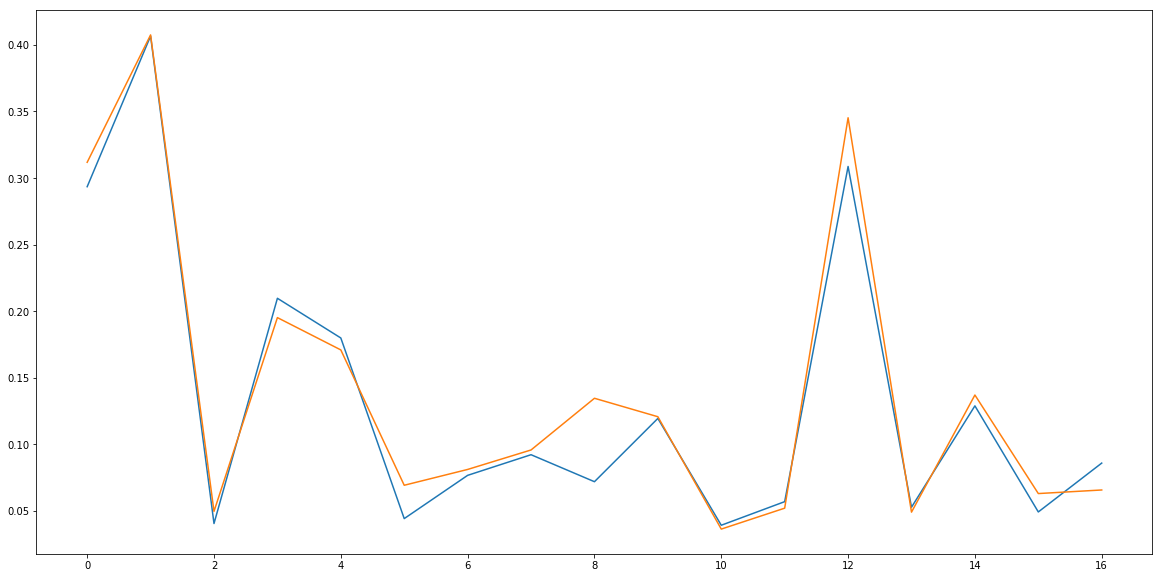

In [58]:
plt.figure(figsize=(20, 10))
plt.plot(val_main_loss)
plt.plot(test_main_loss)

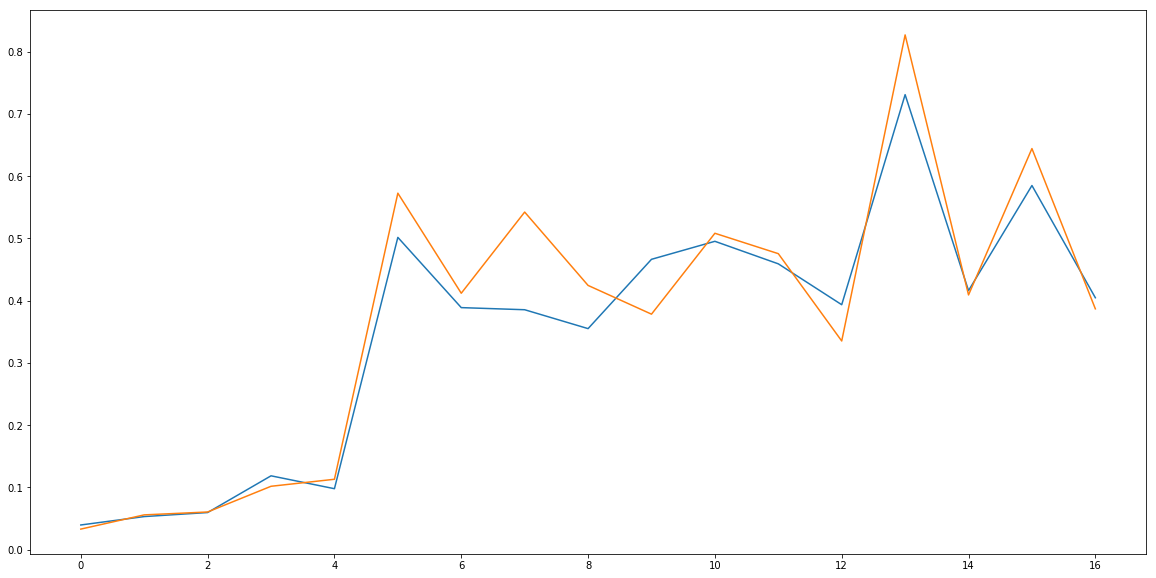

In [59]:
plt.figure(figsize=(20, 10))
plt.plot(val_aux_loss)
plt.plot(test_aux_loss)

In [60]:
min(val_main_loss), min(test_main_loss)

(0.039208869167756066, 0.03632132613035469)

#### Test with imf features and without multitask learning


In [70]:

X = np.zeros((len(data), depth, len(cols) + len(imf_cols)))
for j, name in enumerate(cols + imf_cols):
    for k in range(depth):
        X[:, k, j] = data[name].shift(depth - k - 1).fillna(method='bfill')

X_train = X[:train_length]
X_val = X[train_length:train_length+val_length]
X_test = X[-val_length:]

y_train = y[:train_length]
y_val = y[train_length:train_length+val_length]
y_test = y[-val_length:]

X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)
y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)

y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val)
y_test_t = torch.Tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=64)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=64)

model = SelfBoostedNet(X_train_t.shape[2], i, 32, 3, 64).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()
val_loss = 99999
for e in range(200):
    train_main_loss, train_aux_loss = 0, 0
    for batch_x, batch_y in tqdm_notebook(train_loader):
        opt.zero_grad()
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        
        main_output, _ = model(batch_x)
        main_loss = loss(main_output, batch_y)
        total_loss = main_loss #+ alpha*aux_loss
        total_loss.backward()
        opt.step()
        train_main_loss += main_loss.item()*batch_x.shape[0]
        
    with torch.no_grad():
        val_main_loss, val_aux_loss = 0, 0
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            main_output, _ = model(batch_x)
            main_loss = loss(main_output, batch_y)
            val_main_loss += main_loss.item()*batch_x.shape[0]
            
        train_main_loss /= X_train_t.shape[0]
        
        val_main_loss /= X_val_t.shape[0]
        
        if val_loss > val_main_loss:
            val_loss = val_main_loss
            torch.save(model.state_dict(), 'self_boost_electricity_load.pt')

    print("Iter: ", e,
          "train main loss: ", train_main_loss, 
          "val main loss: ", val_main_loss)

model.load_state_dict(torch.load('self_boost_electricity_load.pt'))

with torch.no_grad():
    val_main_loss = 0
    for batch_x, batch_y in val_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        main_output, _= model(batch_x)
        main_loss = loss(main_output, batch_y)

        val_main_loss += main_loss.item()*batch_x.shape[0]

    test_main_loss = 0
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

        main_output, _ = model(batch_x)
        main_loss = loss(main_output, batch_y)

        test_main_loss += main_loss.item()*batch_x.shape[0]

    val_main_loss = val_main_loss/len(X_val_t)
    test_main_loss = test_main_loss/len(X_test_t)



Iter:  0 train main loss:  0.001044089496370623 val main loss:  0.8225479047404625



Iter:  1 train main loss:  0.0002692054710812785 val main loss:  0.6384832059077173



Iter:  2 train main loss:  0.00021474278434794662 val main loss:  0.6738549157800342



Iter:  3 train main loss:  0.00019987491894600664 val main loss:  0.7197488346982239



Iter:  4 train main loss:  0.00018736639147164322 val main loss:  0.7990652927686268



Iter:  5 train main loss:  0.0001733186835571194 val main loss:  0.7023142304580627



Iter:  6 train main loss:  0.00017020270680907207 val main loss:  0.5996440780506249



Iter:  7 train main loss:  0.00016715905058072567 val main loss:  0.4175740504436295



Iter:  8 train main loss:  0.00016047482745535518 val main loss:  0.7635204511485477



Iter:  9 train main loss:  0.00015856348283874592 val main loss:  0.920130743450424



Iter:  10 train main loss:  0.0001526768865805776 val main loss:  0.876109575149205



Iter:  11 train main loss:  0.00014977980635575292 val main loss:  0.7730423647085211



Iter:  12 train main loss:  0.00014479214211868908 val main loss:  0.7047603255290393



Iter:  13 train main loss:  0.00014319449350404218 val main loss:  0.7601778506103166



Iter:  14 train main loss:  0.00013707614043224876 val main loss:  0.601787861733622



Iter:  15 train main loss:  0.0001358861171575642 val main loss:  0.7125055790766414



Iter:  16 train main loss:  0.00013541340755614104 val main loss:  0.551875198646111



Iter:  17 train main loss:  0.00013287837303186151 val main loss:  0.8132237940993486



Iter:  18 train main loss:  0.0001333444541710523 val main loss:  0.9028825785443869



Iter:  19 train main loss:  0.00013001931847900664 val main loss:  0.915945823211193



Iter:  20 train main loss:  0.00012378625668189592 val main loss:  0.9122034146713645



Iter:  21 train main loss:  0.0001211385095114194 val main loss:  0.8457044938941491



Iter:  22 train main loss:  0.00012186997390692822 val main loss:  0.8427979633948024



Iter:  23 train main loss:  0.00012062929120113515 val main loss:  0.443303419494738



Iter:  24 train main loss:  0.00012191551529588584 val main loss:  0.8816703588433421



Iter:  25 train main loss:  0.00011748235833491164 val main loss:  0.6379884780799913



Iter:  26 train main loss:  0.0001178424594107833 val main loss:  0.961225212731271



Iter:  27 train main loss:  0.00011556580269463027 val main loss:  1.085164682176124



Iter:  28 train main loss:  0.00011558166426018163 val main loss:  1.2822093956486649



Iter:  29 train main loss:  0.00011946556456747164 val main loss:  0.41815957081944777



Iter:  30 train main loss:  0.00011731865885767037 val main loss:  1.2758963217451729



Iter:  31 train main loss:  0.00011610559476521938 val main loss:  1.3471764271706954



Iter:  32 train main loss:  0.00011241228383368578 val main loss:  1.368209455603479



Iter:  33 train main loss:  0.00011371205749799802 val main loss:  1.3637696709258427



Iter:  34 train main loss:  0.00011145786612733037 val main loss:  1.0365002055891221



Iter:  35 train main loss:  0.00010777197634859364 val main loss:  1.273782417618599



Iter:  36 train main loss:  0.00010861390816438226 val main loss:  1.0065127810882009



Iter:  37 train main loss:  0.00010806835693397409 val main loss:  1.1670842475555063



Iter:  38 train main loss:  0.00011109482947858832 val main loss:  0.46621731097352226



Iter:  39 train main loss:  0.00010436114308234755 val main loss:  0.721462994392465



Iter:  40 train main loss:  0.0001053102595929753 val main loss:  0.6537813334209023



Iter:  41 train main loss:  0.00010581198184890023 val main loss:  0.6144040493348847



Iter:  42 train main loss:  0.00010571155539408567 val main loss:  0.8776139739832532



Iter:  43 train main loss:  0.00010392937269055814 val main loss:  0.6508923926200166



Iter:  44 train main loss:  0.0001047204519311724 val main loss:  0.7021101555137249



Iter:  45 train main loss:  0.00010502574899557801 val main loss:  0.7311061505909368



Iter:  46 train main loss:  0.00010246782960464357 val main loss:  0.5755794378902446



Iter:  47 train main loss:  0.00010184314315370823 val main loss:  0.5155737567495117



Iter:  48 train main loss:  0.0001033608255864855 val main loss:  0.5555854577833342



Iter:  49 train main loss:  0.0001005336151523754 val main loss:  0.5273307757771857



Iter:  50 train main loss:  9.978671754119655e-05 val main loss:  0.5523839001987054



Iter:  51 train main loss:  0.00010230742669456706 val main loss:  0.5188332134034388



Iter:  52 train main loss:  9.872290231199524e-05 val main loss:  0.5175861011620717



Iter:  53 train main loss:  0.00010365011539387058 val main loss:  0.421546709616166



Iter:  54 train main loss:  9.776801982193228e-05 val main loss:  0.4710486558204097



Iter:  55 train main loss:  9.977299840109078e-05 val main loss:  0.4669315042857335



Iter:  56 train main loss:  9.810807072959769e-05 val main loss:  0.4022004787066875



Iter:  57 train main loss:  0.00010134908025192552 val main loss:  0.4474625767165375



Iter:  58 train main loss:  9.752303776568246e-05 val main loss:  0.4365880482876821



Iter:  59 train main loss:  9.792848117933977e-05 val main loss:  0.4251076878461301



Iter:  60 train main loss:  9.618165001491496e-05 val main loss:  0.447659916852458



Iter:  61 train main loss:  9.864393616053814e-05 val main loss:  0.4388683184217456



Iter:  62 train main loss:  9.632750786733566e-05 val main loss:  0.4822626313358513



Iter:  63 train main loss:  9.811544445422312e-05 val main loss:  0.43934562595226545



Iter:  64 train main loss:  9.710559049586344e-05 val main loss:  0.43516830019316183



Iter:  65 train main loss:  9.259837067714613e-05 val main loss:  0.4651624372250959



Iter:  66 train main loss:  9.683588804225741e-05 val main loss:  0.443350868881236



Iter:  67 train main loss:  9.498951426420443e-05 val main loss:  0.4488114086101275



Iter:  68 train main loss:  9.697811518681388e-05 val main loss:  0.43737300795578227



Iter:  69 train main loss:  9.487633079689699e-05 val main loss:  0.3953954455925337



Iter:  70 train main loss:  9.313739959200952e-05 val main loss:  0.42495863056910615



Iter:  71 train main loss:  9.621948899584013e-05 val main loss:  0.42505706534235727



Iter:  72 train main loss:  9.602544556816115e-05 val main loss:  0.4309519629324617



Iter:  73 train main loss:  9.105009672816128e-05 val main loss:  0.4515861657753297



Iter:  74 train main loss:  9.118998251187155e-05 val main loss:  0.4524481686424184



Iter:  75 train main loss:  9.242673754727044e-05 val main loss:  0.44349313747305913



Iter:  76 train main loss:  9.436488138220764e-05 val main loss:  0.44436742595991335



Iter:  77 train main loss:  9.247545477037855e-05 val main loss:  0.43793846384220525



Iter:  78 train main loss:  9.019257613483879e-05 val main loss:  0.45268118604128205



Iter:  79 train main loss:  9.290223635837879e-05 val main loss:  0.4260711143353599



Iter:  80 train main loss:  9.14738053219953e-05 val main loss:  0.4536935569606792



Iter:  81 train main loss:  9.029724133492471e-05 val main loss:  0.43280686108603095



Iter:  82 train main loss:  9.09866394164053e-05 val main loss:  0.4275351142670668



Iter:  83 train main loss:  8.614394357942585e-05 val main loss:  0.4519977828006239



Iter:  84 train main loss:  8.936741560825219e-05 val main loss:  0.4516129988601714



Iter:  85 train main loss:  8.957666350589682e-05 val main loss:  0.461317977426264



Iter:  86 train main loss:  8.831645975737558e-05 val main loss:  0.46423924789867543



Iter:  87 train main loss:  8.851655858536728e-05 val main loss:  0.44961433994676847



Iter:  88 train main loss:  8.79498987828903e-05 val main loss:  0.4480275188663742



Iter:  89 train main loss:  8.725478470571874e-05 val main loss:  0.41461988587928383



Iter:  90 train main loss:  8.56001034945463e-05 val main loss:  0.4488470458860781



Iter:  91 train main loss:  8.760501142905266e-05 val main loss:  0.40730712316205314



Iter:  92 train main loss:  8.658159415382284e-05 val main loss:  0.4000282550463129



Iter:  93 train main loss:  8.448362982789051e-05 val main loss:  0.3892049551428



Iter:  94 train main loss:  8.937912977429664e-05 val main loss:  0.36898532291853836



Iter:  95 train main loss:  8.717129842613818e-05 val main loss:  0.3843205902698034



Iter:  96 train main loss:  8.671368864545551e-05 val main loss:  0.3899305331701383



Iter:  97 train main loss:  8.681205603210572e-05 val main loss:  0.3358200307667909



Iter:  98 train main loss:  8.420841608297868e-05 val main loss:  0.36898965739622586



Iter:  99 train main loss:  8.203460235164585e-05 val main loss:  0.36068604983860697



Iter:  100 train main loss:  8.397452437380175e-05 val main loss:  0.35621190019282445



Iter:  101 train main loss:  8.437672251003286e-05 val main loss:  0.3216089051413092



Iter:  102 train main loss:  8.130519886747828e-05 val main loss:  0.3263670079126406



Iter:  103 train main loss:  8.585159934798109e-05 val main loss:  0.3019454858408847



Iter:  104 train main loss:  8.175195974243194e-05 val main loss:  0.2981050370965035



Iter:  105 train main loss:  8.284577363658406e-05 val main loss:  0.3183592196906142



Iter:  106 train main loss:  8.327989955115228e-05 val main loss:  0.2845276296279204



Iter:  107 train main loss:  8.11794361716771e-05 val main loss:  0.2983825926117373



Iter:  108 train main loss:  8.013526110450899e-05 val main loss:  0.3033220082687643



Iter:  109 train main loss:  8.256973696385918e-05 val main loss:  0.31269720319599353



Iter:  110 train main loss:  8.03320539792097e-05 val main loss:  0.30076598413601013



Iter:  111 train main loss:  8.167408658042876e-05 val main loss:  0.28967839213867913



Iter:  112 train main loss:  7.936594579480593e-05 val main loss:  0.2873254116516657



Iter:  113 train main loss:  8.158434400791585e-05 val main loss:  0.2613504968844312



Iter:  114 train main loss:  7.78263328626742e-05 val main loss:  0.282423390780821



Iter:  115 train main loss:  8.043175384371852e-05 val main loss:  0.28608390347079776



Iter:  116 train main loss:  8.068997322267305e-05 val main loss:  0.3006640771673468



Iter:  117 train main loss:  7.77229992658068e-05 val main loss:  0.29026055265612316



Iter:  118 train main loss:  8.172842307065718e-05 val main loss:  0.2745894408826275



Iter:  119 train main loss:  7.893631276789624e-05 val main loss:  0.29673713779416977



Iter:  120 train main loss:  7.887698778081542e-05 val main loss:  0.2904312809416495



Iter:  121 train main loss:  7.959889415112984e-05 val main loss:  0.28435250400808565



Iter:  122 train main loss:  7.801049498094238e-05 val main loss:  0.28877989254604486



Iter:  123 train main loss:  7.763922391681295e-05 val main loss:  0.2780764495071865



Iter:  124 train main loss:  7.786270148438563e-05 val main loss:  0.26470390421257267



Iter:  125 train main loss:  7.859023735440037e-05 val main loss:  0.2667099023965425



Iter:  126 train main loss:  7.65076311703452e-05 val main loss:  0.2673489877037013



Iter:  127 train main loss:  7.748634165338809e-05 val main loss:  0.285056049400103



Iter:  128 train main loss:  7.635769807475493e-05 val main loss:  0.27938779434928257



Iter:  129 train main loss:  7.572919477973137e-05 val main loss:  0.2625064361450175



Iter:  130 train main loss:  7.585301158878698e-05 val main loss:  0.2636625536945632



Iter:  131 train main loss:  7.615769827666796e-05 val main loss:  0.2582684358499263



Iter:  132 train main loss:  7.653150562974696e-05 val main loss:  0.2578725259985016



Iter:  133 train main loss:  7.59422056113503e-05 val main loss:  0.2603284281550574



Iter:  134 train main loss:  7.558156393519125e-05 val main loss:  0.27620932383234764



Iter:  135 train main loss:  7.627523584706333e-05 val main loss:  0.2549963291945915



Iter:  136 train main loss:  7.550370744218881e-05 val main loss:  0.26384680102702507



Iter:  137 train main loss:  7.369317538522842e-05 val main loss:  0.25502643845997974



Iter:  138 train main loss:  7.538975242767746e-05 val main loss:  0.26043546852375127



Iter:  139 train main loss:  7.467606098572433e-05 val main loss:  0.2502440074537571



Iter:  140 train main loss:  7.485119300558003e-05 val main loss:  0.23265693559396358



Iter:  141 train main loss:  7.73251373970438e-05 val main loss:  0.24008073419033893



Iter:  142 train main loss:  7.271031837100706e-05 val main loss:  0.24819436491563043



Iter:  143 train main loss:  7.366663015785112e-05 val main loss:  0.2461630567055485



Iter:  144 train main loss:  7.375069154259905e-05 val main loss:  0.25597921667022855



Iter:  145 train main loss:  7.380844962086984e-05 val main loss:  0.24186658627931273



Iter:  146 train main loss:  7.32418904754083e-05 val main loss:  0.24409438656900806



Iter:  147 train main loss:  7.349427662715761e-05 val main loss:  0.23829465714283918



Iter:  148 train main loss:  7.232728340138469e-05 val main loss:  0.2256388359543991



Iter:  149 train main loss:  7.176431689338293e-05 val main loss:  0.23952979354178153



Iter:  150 train main loss:  7.316806273321527e-05 val main loss:  0.2454287072675079



Iter:  151 train main loss:  7.229855816000487e-05 val main loss:  0.23954164723001697



Iter:  152 train main loss:  7.34481402181972e-05 val main loss:  0.2192961845056349



Iter:  153 train main loss:  7.289263255512959e-05 val main loss:  0.23987409985627542



Iter:  154 train main loss:  7.381128648084498e-05 val main loss:  0.22576929154829378



Iter:  155 train main loss:  7.200245835713417e-05 val main loss:  0.23116130348644778



Iter:  156 train main loss:  7.097924941938327e-05 val main loss:  0.21565268039896268



Iter:  157 train main loss:  7.131715017903087e-05 val main loss:  0.2053711532211998



Iter:  158 train main loss:  7.032469087587525e-05 val main loss:  0.2112005231699311



Iter:  159 train main loss:  6.919316521130197e-05 val main loss:  0.2168058002847238



Iter:  160 train main loss:  7.279680870589195e-05 val main loss:  0.22175922776174956



Iter:  161 train main loss:  7.143937828905742e-05 val main loss:  0.2124206656177913



Iter:  162 train main loss:  7.117769661796572e-05 val main loss:  0.215840234871101



Iter:  163 train main loss:  6.927850100125654e-05 val main loss:  0.21340383764780085



Iter:  164 train main loss:  7.084518131795771e-05 val main loss:  0.20015823229948354



Iter:  165 train main loss:  6.907859001450094e-05 val main loss:  0.20036913339195506



Iter:  166 train main loss:  6.806643608472342e-05 val main loss:  0.20424640679421935



Iter:  167 train main loss:  7.117853609079437e-05 val main loss:  0.2152354543962105



Iter:  168 train main loss:  6.922928900308763e-05 val main loss:  0.1795422224579121



Iter:  169 train main loss:  6.999948897799422e-05 val main loss:  0.2009129058351705



Iter:  170 train main loss:  6.846199014117442e-05 val main loss:  0.17424762995941778



Iter:  171 train main loss:  6.83896771860381e-05 val main loss:  0.1938652726712038



Iter:  172 train main loss:  6.741077363077849e-05 val main loss:  0.18186640890626868



Iter:  173 train main loss:  6.831588745774721e-05 val main loss:  0.1869159355082452



Iter:  174 train main loss:  7.347241496377637e-05 val main loss:  0.19217380808884746



Iter:  175 train main loss:  6.783831150335752e-05 val main loss:  0.1846957436709396



Iter:  176 train main loss:  6.712812313104175e-05 val main loss:  0.1835460235241028



Iter:  177 train main loss:  6.815957052039847e-05 val main loss:  0.17209760003573898



Iter:  178 train main loss:  6.838200441620869e-05 val main loss:  0.19233697070769215



Iter:  179 train main loss:  6.798605044272577e-05 val main loss:  0.18927309320081406



Iter:  180 train main loss:  6.507849725597286e-05 val main loss:  0.18499541828928898



Iter:  181 train main loss:  8.393594059430384e-05 val main loss:  0.1878563662169567



Iter:  182 train main loss:  6.734752328483994e-05 val main loss:  0.1823460421263849



Iter:  183 train main loss:  6.652137431198012e-05 val main loss:  0.16996303195074242



Iter:  184 train main loss:  6.899672269657427e-05 val main loss:  0.186560490971532



Iter:  185 train main loss:  6.5898648806108e-05 val main loss:  0.1874555999312434



Iter:  186 train main loss:  6.60498932440642e-05 val main loss:  0.1835339569548365



Iter:  187 train main loss:  6.553437936565152e-05 val main loss:  0.19048454043429228



Iter:  188 train main loss:  6.51870808637931e-05 val main loss:  0.1958666235649222



Iter:  189 train main loss:  6.684883140063167e-05 val main loss:  0.1989647839751089



Iter:  190 train main loss:  6.896954519052944e-05 val main loss:  0.1889853587199852



Iter:  191 train main loss:  6.52924729640612e-05 val main loss:  0.19462660497445167



Iter:  192 train main loss:  6.501184573765305e-05 val main loss:  0.199455317026721



Iter:  193 train main loss:  6.43106780059905e-05 val main loss:  0.1846855230934097



Iter:  194 train main loss:  6.471928457968763e-05 val main loss:  0.1838833379414728



Iter:  195 train main loss:  6.41606873010931e-05 val main loss:  0.18509205520664473



Iter:  196 train main loss:  6.561987099224317e-05 val main loss:  0.20300583245988624



Iter:  197 train main loss:  6.485545204514642e-05 val main loss:  0.19926645018178007



Iter:  198 train main loss:  6.585774995537328e-05 val main loss:  0.19897181271835654



Iter:  199 train main loss:  6.605425308431903e-05 val main loss:  0.19252124910668925


In [71]:
val_main_loss, test_main_loss

(0.16996303195074242, 0.19056933871680057)

#### Test without imf features and without multitask learning


In [72]:

X = np.zeros((len(data), depth, len(cols)))
for j, name in enumerate(cols):
    for k in range(depth):
        X[:, k, j] = data[name].shift(depth - k - 1).fillna(method='bfill')

X_train = X[:train_length]
X_val = X[train_length:train_length+val_length]
X_test = X[-val_length:]

y_train = y[:train_length]
y_val = y[train_length:train_length+val_length]
y_test = y[-val_length:]

X_train_min, X_train_max = X_train.min(axis=0), X_train.max(axis=0)
X_train = (X_train - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_val = (X_val - X_train_min)/(X_train_max - X_train_min + 1e-9)
X_test = (X_test - X_train_min)/(X_train_max - X_train_min + 1e-9)

y_train_min, y_train_max = y_train.min(axis=0), y_train.max(axis=0)
y_train = (y_train - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_val = (y_val - y_train_min)/(y_train_max - y_train_min + 1e-9)
y_test = (y_test - y_train_min)/(y_train_max - y_train_min + 1e-9)

X_train_t = torch.Tensor(X_train)
X_val_t = torch.Tensor(X_val)
X_test_t = torch.Tensor(X_test)

y_train_t = torch.Tensor(y_train)
y_val_t = torch.Tensor(y_val)
y_test_t = torch.Tensor(y_test)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=64)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), shuffle=False, batch_size=64)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=64)

model = SelfBoostedNet(X_train_t.shape[2], i, 32, 3, 64).cuda()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
loss = nn.MSELoss()
val_loss = 99999
for e in range(200):
    train_main_loss, train_aux_loss = 0, 0
    for batch_x, batch_y in tqdm_notebook(train_loader):
        opt.zero_grad()
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        
        main_output, _ = model(batch_x)
        main_loss = loss(main_output, batch_y)
        total_loss = main_loss #+ alpha*aux_loss
        total_loss.backward()
        opt.step()
        train_main_loss += main_loss.item()*batch_x.shape[0]
        
    with torch.no_grad():
        val_main_loss, val_aux_loss = 0, 0
        for batch_x, batch_y in val_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            main_output, _ = model(batch_x)
            main_loss = loss(main_output, batch_y)
            val_main_loss += main_loss.item()*batch_x.shape[0]
            
        train_main_loss /= X_train_t.shape[0]
        
        val_main_loss /= X_val_t.shape[0]
        
        if val_loss > val_main_loss:
            val_loss = val_main_loss
            torch.save(model.state_dict(), 'self_boost_electricity_load.pt')

    print("Iter: ", e,
          "train main loss: ", train_main_loss, 
          "val main loss: ", val_main_loss)

model.load_state_dict(torch.load('self_boost_electricity_load.pt'))

with torch.no_grad():
    val_main_loss = 0
    for batch_x, batch_y in val_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()
        main_output, _= model(batch_x)
        main_loss = loss(main_output, batch_y)

        val_main_loss += main_loss.item()*batch_x.shape[0]

    test_main_loss = 0
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

        main_output, aux_output = model(batch_x)
        main_loss = loss(main_output, batch_y)

        test_main_loss += main_loss.item()*batch_x.shape[0]

val_main_loss = val_main_loss/len(X_val_t)
test_main_loss = test_main_loss/len(X_test_t)



Iter:  0 train main loss:  0.0023329595985499183 val main loss:  1.1434803723282352



Iter:  1 train main loss:  0.000300061215871989 val main loss:  1.0201791785242227



Iter:  2 train main loss:  0.0002530875696194055 val main loss:  0.9323264833992653



Iter:  3 train main loss:  0.0002377087171825204 val main loss:  0.9314692587875942



Iter:  4 train main loss:  0.0002157006387318745 val main loss:  0.9649851550210152



Iter:  5 train main loss:  0.0002147622895983892 val main loss:  1.0070173673479217



Iter:  6 train main loss:  0.00019028995637006342 val main loss:  1.2284640115841972



Iter:  7 train main loss:  0.0001825773385945292 val main loss:  1.3339925863344184



Iter:  8 train main loss:  0.00017737784308322657 val main loss:  1.2224336648541172



Iter:  9 train main loss:  0.00018046563231306003 val main loss:  1.1742419644263



Iter:  10 train main loss:  0.0001692127447301162 val main loss:  1.0876324055017845



Iter:  11 train main loss:  0.0001724526498687625 val main loss:  1.084747997015592



Iter:  12 train main loss:  0.00016797786770996278 val main loss:  0.9980278738248223



Iter:  13 train main loss:  0.00016367513869469048 val main loss:  0.9657203144248806



Iter:  14 train main loss:  0.00016088875664079555 val main loss:  0.9242839236620539



Iter:  15 train main loss:  0.0001629638472896905 val main loss:  0.8506706129481458



Iter:  16 train main loss:  0.00015571622416170122 val main loss:  0.8724871617320396



Iter:  17 train main loss:  0.000152857866768153 val main loss:  0.7679915149532955



Iter:  18 train main loss:  0.00015248673636095167 val main loss:  0.80918284975364



Iter:  19 train main loss:  0.00015231482291705548 val main loss:  0.7490571994114801



Iter:  20 train main loss:  0.00014272838284609427 val main loss:  0.8182746570571366



Iter:  21 train main loss:  0.00014286437758630414 val main loss:  0.756183640770391



Iter:  22 train main loss:  0.00015527516399932212 val main loss:  0.706507058922669



Iter:  23 train main loss:  0.0001477766984316692 val main loss:  0.7383962403055573



Iter:  24 train main loss:  0.00014353660279324142 val main loss:  0.753693854193147



Iter:  25 train main loss:  0.00014111335047327657 val main loss:  0.7417199563610947



Iter:  26 train main loss:  0.00014235711133738207 val main loss:  0.6827045822407052



Iter:  27 train main loss:  0.0001367344825792444 val main loss:  0.6769647466064845



Iter:  28 train main loss:  0.0001416922292674383 val main loss:  0.6573549640804992



Iter:  29 train main loss:  0.00013918009333334545 val main loss:  0.6136084633297448



Iter:  30 train main loss:  0.00013536232558542097 val main loss:  0.641097293303789



Iter:  31 train main loss:  0.00013396611961573305 val main loss:  0.6042167138024949



Iter:  32 train main loss:  0.0001326516998818269 val main loss:  0.5906298477589114



Iter:  33 train main loss:  0.00013613116144182776 val main loss:  0.5470758575609368



Iter:  34 train main loss:  0.00013159112575700872 val main loss:  0.5535810027545385



Iter:  35 train main loss:  0.0001408124387286383 val main loss:  0.4905329324077265



Iter:  36 train main loss:  0.00014027346645709585 val main loss:  0.50207423187349



Iter:  37 train main loss:  0.00013825900524782513 val main loss:  0.5056283337113457



Iter:  38 train main loss:  0.00013183760436048995 val main loss:  0.4626753995153895



Iter:  39 train main loss:  0.00013359954328706037 val main loss:  0.4737220852095321



Iter:  40 train main loss:  0.000130958663558484 val main loss:  0.4885125166427043



Iter:  41 train main loss:  0.00013345334471546398 val main loss:  0.4185173529765371



Iter:  42 train main loss:  0.00013139014745324956 val main loss:  0.44996031294820354



Iter:  43 train main loss:  0.00013179935353484053 val main loss:  0.4285303978165598



Iter:  44 train main loss:  0.0001312711269918879 val main loss:  0.5219757661723685



Iter:  45 train main loss:  0.00012713470080615502 val main loss:  0.394521414718033



Iter:  46 train main loss:  0.00012578389943970417 val main loss:  0.4519301469906975



Iter:  47 train main loss:  0.00012644201204213592 val main loss:  0.3429033127903377



Iter:  48 train main loss:  0.0001263212965081406 val main loss:  0.3908249149142486



Iter:  49 train main loss:  0.00012751034715667803 val main loss:  0.3807080972269633



Iter:  50 train main loss:  0.0001277179189269501 val main loss:  0.39728130277431567



Iter:  51 train main loss:  0.0001262589893957388 val main loss:  0.42902375744330823



Iter:  52 train main loss:  0.00012299544442049925 val main loss:  0.45186064094353845



Iter:  53 train main loss:  0.00012366626291324687 val main loss:  0.3906945242026537



Iter:  54 train main loss:  0.00012206188782445543 val main loss:  0.3850231753406381



Iter:  55 train main loss:  0.0001251933764456902 val main loss:  0.4804825910871661



Iter:  56 train main loss:  0.00012273849126187184 val main loss:  0.49843646742578873



Iter:  57 train main loss:  0.00012282522360316687 val main loss:  0.4244640400007509



Iter:  58 train main loss:  0.0001287630792192846 val main loss:  0.4141622480866394



Iter:  59 train main loss:  0.00012532891747698974 val main loss:  0.3438058514208921



Iter:  60 train main loss:  0.0001206663354632922 val main loss:  0.3477248717467794



Iter:  61 train main loss:  0.00012356021100018132 val main loss:  0.31646665616609637



Iter:  62 train main loss:  0.00012309495785490292 val main loss:  0.29558919660886096



Iter:  63 train main loss:  0.00011908650450071027 val main loss:  0.6122676797178899



Iter:  64 train main loss:  0.00012345147293252992 val main loss:  0.6226069486439968



Iter:  65 train main loss:  0.00012284307587039292 val main loss:  0.8172062553434755



Iter:  66 train main loss:  0.00012102975205677736 val main loss:  1.01741684301088



Iter:  67 train main loss:  0.00011978678830528736 val main loss:  0.8446182697301194



Iter:  68 train main loss:  0.00011852699969954752 val main loss:  0.9337208774373079



Iter:  69 train main loss:  0.00011761400972891348 val main loss:  1.0782329769393415



Iter:  70 train main loss:  0.00012989358056994868 val main loss:  1.1116380887478245



Iter:  71 train main loss:  0.0001295485435890641 val main loss:  1.1807264918126776



Iter:  72 train main loss:  0.00012675879638752362 val main loss:  1.083844575336138



Iter:  73 train main loss:  0.00012753630980320529 val main loss:  0.7099635383703338



Iter:  74 train main loss:  0.00012599872309112476 val main loss:  0.8797499195078339



Iter:  75 train main loss:  0.00013063398360661397 val main loss:  0.8478353537007817



Iter:  76 train main loss:  0.00012300099626502526 val main loss:  0.722316124327868



Iter:  77 train main loss:  0.0001216932008779779 val main loss:  0.7159853843501429



Iter:  78 train main loss:  0.00012474044945262649 val main loss:  0.26617022704453985



Iter:  79 train main loss:  0.00012282125517848726 val main loss:  0.22855332382721222



Iter:  80 train main loss:  0.0001222536208166803 val main loss:  0.14828285643825118



Iter:  81 train main loss:  0.00012043891337177345 val main loss:  0.11294477218095696



Iter:  82 train main loss:  0.00012037772993294806 val main loss:  0.1345866390434287



Iter:  83 train main loss:  0.00011971240778312383 val main loss:  0.15877272314196642



Iter:  84 train main loss:  0.0001192654619393434 val main loss:  0.17540174292966956



Iter:  85 train main loss:  0.00011799229663878212 val main loss:  0.12324788155520115



Iter:  86 train main loss:  0.00011817939168231009 val main loss:  0.17036057794721599



Iter:  87 train main loss:  0.00011695204504008714 val main loss:  0.09934813595636839



Iter:  88 train main loss:  0.00012039766522704412 val main loss:  0.36709003947836055



Iter:  89 train main loss:  0.00011779149947431644 val main loss:  0.2945043507210486



Iter:  90 train main loss:  0.00011867446544937313 val main loss:  0.4019699056997464



Iter:  91 train main loss:  0.00011531208165898395 val main loss:  0.10450321695690018



Iter:  92 train main loss:  0.00011546464640912233 val main loss:  0.19665725405815468



Iter:  93 train main loss:  0.0001157106412306343 val main loss:  0.09209121285086551



Iter:  94 train main loss:  0.00011412852958657264 val main loss:  0.13207248452104822



Iter:  95 train main loss:  0.0001153007960006987 val main loss:  0.24397654698859253



Iter:  96 train main loss:  0.00011677513853825824 val main loss:  0.21348577919042783



Iter:  97 train main loss:  0.00011382331219914675 val main loss:  0.07378677125886193



Iter:  98 train main loss:  0.00011613347902031291 val main loss:  0.09524469296063298



Iter:  99 train main loss:  0.00011292259826193096 val main loss:  0.08822667970662416



Iter:  100 train main loss:  0.00011402746855391801 val main loss:  0.08011509297136526



Iter:  101 train main loss:  0.00011163805161757999 val main loss:  0.07003284413462797



Iter:  102 train main loss:  0.0001139103937346171 val main loss:  0.08293382222315814



Iter:  103 train main loss:  0.00011354002511532752 val main loss:  0.07697649653953105



Iter:  104 train main loss:  0.00011329697368682948 val main loss:  0.070177202361356



Iter:  105 train main loss:  0.00011134694318098813 val main loss:  0.0785213120578746



Iter:  106 train main loss:  0.00011231456105358049 val main loss:  0.08711692252998875



Iter:  107 train main loss:  0.00011401814410146254 val main loss:  0.08678699348167765



Iter:  108 train main loss:  0.0001098334231663498 val main loss:  0.09414483272860945



Iter:  109 train main loss:  0.00011048908036986039 val main loss:  0.07808638843762024



Iter:  110 train main loss:  0.00011193274204010454 val main loss:  0.09635739022607122



Iter:  111 train main loss:  0.00011041961391800388 val main loss:  0.09120876086318816



Iter:  112 train main loss:  0.00011037532772238913 val main loss:  0.08330803808695514



Iter:  113 train main loss:  0.00011065845805749356 val main loss:  0.08348973740459417



Iter:  114 train main loss:  0.0001089915859750155 val main loss:  0.09880040239312705



Iter:  115 train main loss:  0.00011211110973471847 val main loss:  0.14007472138341115



Iter:  116 train main loss:  0.0001111415526113534 val main loss:  0.09999451064283066



Iter:  117 train main loss:  0.00010799232238924561 val main loss:  0.11451593565672818



Iter:  118 train main loss:  0.00010776591115812213 val main loss:  0.13397434590538615



Iter:  119 train main loss:  0.00010983892731787416 val main loss:  0.13205201830801264



Iter:  120 train main loss:  0.00011192707270943645 val main loss:  0.12945363155501513



Iter:  121 train main loss:  0.00010650148892345291 val main loss:  0.12173105858451018



Iter:  122 train main loss:  0.00010729134424706182 val main loss:  0.11915405894848485



Iter:  123 train main loss:  0.00010805187975508135 val main loss:  0.12568140063734112



Iter:  124 train main loss:  0.00010778958969900907 val main loss:  0.1236971033591178



Iter:  125 train main loss:  0.00010899867429431769 val main loss:  0.1346124286521932



Iter:  126 train main loss:  0.00010698153840159586 val main loss:  0.12219803437471673



Iter:  127 train main loss:  0.00010486431968351446 val main loss:  0.10321795889745992



Iter:  128 train main loss:  0.00010580826150927562 val main loss:  0.11778372821432376



Iter:  129 train main loss:  0.00010654414885443708 val main loss:  0.10546954497978506



Iter:  130 train main loss:  0.00010493554200967027 val main loss:  0.13899717010557786



Iter:  131 train main loss:  0.00010431447124485452 val main loss:  0.11950698195401227



Iter:  132 train main loss:  0.0001069934711935099 val main loss:  0.11725184612203175



Iter:  133 train main loss:  0.00010734519657143386 val main loss:  0.12302692402833833



Iter:  134 train main loss:  0.00010311794570961395 val main loss:  0.12491939928787223



Iter:  135 train main loss:  0.00010552862508464259 val main loss:  0.1156854702768072



Iter:  136 train main loss:  0.00010472895462161252 val main loss:  0.11678307323895634



Iter:  137 train main loss:  0.0001030013062587574 val main loss:  0.1083785812813547



Iter:  138 train main loss:  0.00010278350437717305 val main loss:  0.12159362692149321



Iter:  139 train main loss:  0.0001045530520232626 val main loss:  0.09204626124865373



Iter:  140 train main loss:  0.00010611063770757784 val main loss:  0.10114782971384205



Iter:  141 train main loss:  0.00010274326405464057 val main loss:  0.10926037906019302



Iter:  142 train main loss:  0.00010160803372790798 val main loss:  0.17573713658465245



Iter:  143 train main loss:  0.00010273600985819452 val main loss:  0.20413427838712292



Iter:  144 train main loss:  0.00010282320864385469 val main loss:  0.16537067302167063



Iter:  145 train main loss:  0.00010145611834693556 val main loss:  0.10746573334888355



Iter:  146 train main loss:  0.00010287318947095663 val main loss:  0.12978222630757333



Iter:  147 train main loss:  9.966175743246581e-05 val main loss:  0.15742884099819218



Iter:  148 train main loss:  0.00010157806019714421 val main loss:  0.20512891694701046



Iter:  149 train main loss:  0.00010098058477718402 val main loss:  0.17411130804057298



Iter:  150 train main loss:  0.00010479549172877788 val main loss:  0.15806291301820968



Iter:  151 train main loss:  0.00010124224033318797 val main loss:  0.16384501069667495



Iter:  152 train main loss:  0.00010061264982283948 val main loss:  0.1392812621781234



Iter:  153 train main loss:  0.0001037402921567959 val main loss:  0.18293799495165525



Iter:  154 train main loss:  0.00010067060818720556 val main loss:  0.17705988938114775



Iter:  155 train main loss:  9.94650237240198e-05 val main loss:  0.24071921549076686



Iter:  156 train main loss:  9.922905038855556e-05 val main loss:  0.14525558996498666



Iter:  157 train main loss:  0.00010065781011124253 val main loss:  0.28065974849134245



Iter:  158 train main loss:  9.741745046833061e-05 val main loss:  0.19642610159381843



Iter:  159 train main loss:  9.761293020426393e-05 val main loss:  0.1979980586686096



Iter:  160 train main loss:  0.00010198020709996615 val main loss:  0.252281502718425



Iter:  161 train main loss:  9.771138370180723e-05 val main loss:  0.2757390021286714



Iter:  162 train main loss:  9.803372628612159e-05 val main loss:  0.2535437866671559



Iter:  163 train main loss:  9.820232985442075e-05 val main loss:  0.26924214381350753



Iter:  164 train main loss:  9.674154948660925e-05 val main loss:  0.22680410833435086



Iter:  165 train main loss:  9.739449782078683e-05 val main loss:  0.17608042975005106



Iter:  166 train main loss:  9.695266600818544e-05 val main loss:  0.16897656441870407



Iter:  167 train main loss:  0.00010005161106196636 val main loss:  0.2337642949421491



Iter:  168 train main loss:  9.623785352392535e-05 val main loss:  0.2335958657306827



Iter:  169 train main loss:  9.863583305001827e-05 val main loss:  0.25950452935021373



Iter:  170 train main loss:  9.658200698119502e-05 val main loss:  0.21992879882207192



Iter:  171 train main loss:  9.602172276405047e-05 val main loss:  0.2430951487112318



Iter:  172 train main loss:  9.468914558762513e-05 val main loss:  0.14898594402295456



Iter:  173 train main loss:  9.766076920840256e-05 val main loss:  0.23262866935735058



Iter:  174 train main loss:  9.62047684380541e-05 val main loss:  0.27343456899349305



Iter:  175 train main loss:  9.54203545910818e-05 val main loss:  0.2808759895052313



Iter:  176 train main loss:  9.655022366389974e-05 val main loss:  0.2793867322993111



Iter:  177 train main loss:  9.317903889401165e-05 val main loss:  0.21960248013501554



Iter:  178 train main loss:  9.635779828558076e-05 val main loss:  0.16014655865725536



Iter:  179 train main loss:  9.568854897435862e-05 val main loss:  0.13583106711696885



Iter:  180 train main loss:  9.315455053950916e-05 val main loss:  0.25261985228187883



Iter:  181 train main loss:  9.686028346162503e-05 val main loss:  0.2660512904750807



Iter:  182 train main loss:  9.27034775373613e-05 val main loss:  0.24142416438869307



Iter:  183 train main loss:  9.426757710994823e-05 val main loss:  0.1802041815321889



Iter:  184 train main loss:  9.213724212130416e-05 val main loss:  0.27832515838432387



Iter:  185 train main loss:  9.406361309688421e-05 val main loss:  0.25783198518998734



Iter:  186 train main loss:  9.22897521176416e-05 val main loss:  0.1229553163335939



Iter:  187 train main loss:  9.504149970415498e-05 val main loss:  0.18668213935476563



Iter:  188 train main loss:  9.373083532833212e-05 val main loss:  0.1874048326310137



Iter:  189 train main loss:  9.338611550131538e-05 val main loss:  0.24607152590429987



Iter:  190 train main loss:  9.201248372665958e-05 val main loss:  0.30567520833480444



Iter:  191 train main loss:  9.16051358744786e-05 val main loss:  0.2665338170660924



Iter:  192 train main loss:  9.129659287147906e-05 val main loss:  0.2534687756022222



Iter:  193 train main loss:  9.177636882953873e-05 val main loss:  0.23436765731369275



Iter:  194 train main loss:  9.242308329147705e-05 val main loss:  0.15009082808331903



Iter:  195 train main loss:  8.999552313438613e-05 val main loss:  0.14028504788459903



Iter:  196 train main loss:  9.261184568619087e-05 val main loss:  0.1867207769529252



Iter:  197 train main loss:  9.119751944458792e-05 val main loss:  0.27333564138809746



Iter:  198 train main loss:  8.933106557229677e-05 val main loss:  0.2292267543338336



Iter:  199 train main loss:  9.121533877213856e-05 val main loss:  0.22792046951247366


In [73]:
val_main_loss, test_main_loss

(0.07003284413462797, 0.06693113315800694)